- [빅쿼리 공식문서: Python 라이브러리](https://cloud.google.com/bigquery/docs/python-libraries?hl=ko#features_not_supported_by_pandas-gbq)

In [1]:
# %pip install google-cloud-bigquery

### 라이브러리 import

In [2]:
import glob
from google.cloud import bigquery
from google.oauth2 import service_account

# 서비스 계정 키 JSON 파일 경로
key_path = glob.glob("./config/*.json")[0]

# Credentials 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

# GCP 클라이언트 객체 생성
client = bigquery.Client(credentials=credentials, project=credentials.project_id)


import warnings

# 경고메세지 끄기
warnings.filterwarnings(action='ignore')

### 사용주기
#### stickiness: DAU/MAU
일간 방문자 대비 한 달 안에 재방문하는 비율이 얼마나 될까?

In [3]:
sql = f"""
WITH dau_list AS (
  -- 단순 DAU: 날짜별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, mau_list AS (
  -- 단순 MAU: 월별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    DATE_TRUNC(event_date, MONTH) AS event_month,
    COUNT(DISTINCT user_pseudo_id) AS mau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY DATE_TRUNC(event_date, MONTH)
  -- ORDER BY event_month
)

-- stickiness 계산: dau/mau
SELECT
  d.event_date,
  -- m.event_month,
  d.dau,
  m.mau,
  ROUND(SAFE_DIVIDE(d.dau, m.mau)*100,4) AS stickiness,
  SUM(d.dau) OVER (PARTITION BY m.event_month) AS sum_of_dau,
FROM mau_list m
CROSS JOIN dau_list d
WHERE DATE_TRUNC(d.event_date, MONTH) = m.event_month
ORDER BY m.event_month, d.event_date;
"""

query_job = client.query(sql)
df_stickiness_daumau = query_job.to_dataframe()
df_stickiness_daumau.head()

,event_date,dau,mau,stickiness,sum_of_dau
0,2022-08-01,154,7351,2.0950,7864
1,2022-08-02,157,7351,2.1358,7864
2,2022-08-03,174,7351,2.3670,7864
3,2022-08-04,162,7351,2.2038,7864
4,2022-08-05,170,7351,2.3126,7864


In [4]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_daumau['event_date'],
                         y=df_stickiness_daumau['mau'],
                         name='mau'
))

fig.add_trace(go.Scatter(x=df_stickiness_daumau['event_date'],
                         y=df_stickiness_daumau['sum_of_dau'],
                         name='sum of dau'
))

fig.update_layout(title_text="MAU vs.DAU 월간 합계 비교 추이")
fig.update_xaxes(title_text='날짜')
fig.update_yaxes(title_text='사용자 수')

fig.show()

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_daumau['event_date'],
                         y=df_stickiness_daumau['stickiness'],
))

fig.update_layout(title_text="stickiness: DAU/MAU")
fig.update_xaxes(title_text='날짜')
fig.update_yaxes(title_text='stickiness (%)')

fig.show()

#### stickiness: DAU/WAU
일간 방문자 대비 일주일 안에 재방문하는 비율이 얼마나 될까?

In [6]:
sql = f"""
WITH dau_list AS (
  -- 단순 DAU: 날짜별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, wau_list AS (
  -- 단순 WAU: 주차별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_week
  -- ORDER BY event_week
)

-- stickiness 계산: dau/wau
SELECT
  d.event_date,
  -- w.event_week,
  w.wau,
  d.dau,
  ROUND(SAFE_DIVIDE(d.dau, w.wau)*100,4) AS stickiness,
  SUM(d.dau) OVER (PARTITION BY w.event_week) AS sum_of_dau,
FROM wau_list w
CROSS JOIN dau_list d
WHERE DATE_TRUNC(d.event_date, WEEK(MONDAY)) = w.event_week
ORDER BY w.event_week, d.event_date;
"""

query_job = client.query(sql)
df_stickiness_dauwau = query_job.to_dataframe()
df_stickiness_dauwau.head()

,event_date,wau,dau,stickiness,sum_of_dau
0,2022-08-01,1181,154,13.0398,1190
1,2022-08-02,1181,157,13.2938,1190
2,2022-08-03,1181,174,14.7333,1190
3,2022-08-04,1181,162,13.7172,1190
4,2022-08-05,1181,170,14.3946,1190


In [7]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_dauwau['event_date'],
                         y=df_stickiness_dauwau['wau'],
                         name='wau'
))

fig.add_trace(go.Scatter(x=df_stickiness_dauwau['event_date'],
                         y=df_stickiness_dauwau['sum_of_dau'],
                         name='sum of dau'
))

fig.update_layout(
    title_text="WAU vs.DAU 주간 합계 비교 추이",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98
)
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='사용자 수')

fig.show()

In [8]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_dauwau['event_date'],
                         y=df_stickiness_dauwau['stickiness'],
))

fig.update_layout(
    title_text="stickiness: DAU/WAU",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98
)
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='stickiness (%)')

fig.show()

#### 유입일 이후 방문 간격 분포
사용자는 몇 일에 한 번 방문할까?

In [9]:
sql = f"""
WITH user_active_sequence AS (
  -- 1. 유저별 활동 일자 시퀀스: 유입 일자, 활동 일자, 직전 활동 일자
  SELECT DISTINCT
    user_pseudo_id,
    FIRST_VALUE(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS first_event_date,
    event_date,
    LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
  FROM advanced.app_logs_cleaned_target
)

, user_active_interval AS (
  -- 2. 유저별 유입일 이후 각 방문 간격 계산
  SELECT
    user_pseudo_id,
    event_date,
    prev_event_date,
    IFNULL(DATE_DIFF(event_date, prev_event_date, DAY),0) AS day_diff
  FROM user_active_sequence
  ORDER BY user_pseudo_id, event_date
)

SELECT
  *
FROM user_active_interval
WHERE day_diff != 0
"""

query_job = client.query(sql)
df_visit_interval = query_job.to_dataframe()
df_visit_interval.head()

,user_pseudo_id,event_date,prev_event_date,day_diff
0,1001016485.1302650668,2022-09-26,2022-08-27,30
1,1001016485.1302650668,2022-11-02,2022-09-26,37
2,1001081079.2295351100,2022-10-06,2022-10-01,5
3,1001081079.2295351100,2022-12-16,2022-10-06,71
4,1001261584.8948661538,2023-01-09,2022-11-04,66


In [10]:
import numpy as np

# 사분위수 계산 (q1=12일, q2=27일, q3=50일)
q1, q2, q3 = np.percentile(df_visit_interval["day_diff"], [25, 50, 75])
q1, q2,q3 = int(q1), int(q2), int(q3)
print(q1, q2, q3)

12 27 50


In [11]:
# IQR 계산
iqr = q3 - q1

# Lower & Upper Fence 계산
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

# 이상치가 아닌 min/max 값 찾기
non_outliers = df_visit_interval[(df_visit_interval["day_diff"] >= lower_fence) & (df_visit_interval["day_diff"] <= upper_fence)]
min_value = non_outliers["day_diff"].min()

if lower_fence < 0:
    lower_fence = min_value    

lower_fence, upper_fence = int(lower_fence), int(upper_fence)

print(lower_fence, upper_fence)

1 107


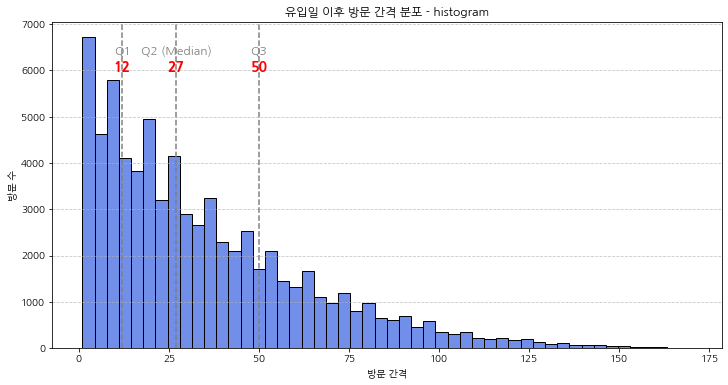

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumGothic')
%matplotlib inline

plt.figure(figsize=(12,6), facecolor='white')
sns.histplot(df_visit_interval['day_diff'], bins=50, color='royalblue')

# 사분위수
for q, label in zip([q1, q2, q3], ["Q1", "Q2 (Median)", "Q3"]):
    plt.axvline(q, color="gray", linestyle="dashed", linewidth=1.5)
    plt.text(q, plt.ylim()[1] * 0.9, label, color="gray", ha="center", fontsize=12)
    plt.text(q, plt.ylim()[1] * 0.85, q, color="red", ha="center", fontsize=14, fontweight="bold")


plt.xlabel("방문 간격")
plt.ylabel("방문 수")
plt.title("유입일 이후 방문 간격 분포 - histogram")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 차트 출력
plt.show()

#### 주차별 리텐션
유입일 이후 주 단위로 봤을 때 얼마나 꾸준히 방문하는가?

In [13]:
sql = f"""
/* weekly range retention */

-- 2) 사용자별 첫방문일 기준 주 차이 계산
WITH week_diff_per_user AS (
  SELECT
    user_pseudo_id,
    first_week,
    event_week,
    DATE_DIFF(event_week, first_week, WEEK) AS week_diff
  FROM (
    -- 1) 사용자별 첫방문일, 방문일 리스트 추출
    SELECT DISTINCT
      user_pseudo_id,
      MIN(event_week) OVER(PARTITION BY user_pseudo_id) AS first_week,
      event_week
    FROM advanced.app_logs_cleaned_target
  )
)
, week_retain AS (
  -- 3) 주 차이별 이용자수 계산
  SELECT
    week_diff,
    COUNT(DISTINCT user_pseudo_id) AS retain_user
  FROM week_diff_per_user
  GROUP BY week_diff
)

-- 5) 주 차이별 리텐션 비율 계산
, first_week_retain AS (
  SELECT
    COUNT(DISTINCT user_pseudo_id) AS first_week_retain_user
  FROM week_diff_per_user
  WHERE 1=1
  AND week_diff=0
)

SELECT
  week_.week_diff,
  week_.retain_user,
  first_week_.first_week_retain_user,
  ROUND(SAFE_DIVIDE(week_.retain_user, first_week_.first_week_retain_user)*100, 3) AS retention_ratio
FROM week_retain AS week_
CROSS JOIN first_week_retain AS first_week_
ORDER BY week_.week_diff ASC
"""

query_job = client.query(sql)
df_weekly_retention = query_job.to_dataframe()
df_weekly_retention.head()

,week_diff,retain_user,first_week_retain_user,retention_ratio
0,0,49678,49678,100.000
1,1,4375,49678,8.807
2,2,4599,49678,9.258
3,3,4673,49678,9.407
4,4,4545,49678,9.149


In [14]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_weekly_retention['week_diff'],
                         y=df_weekly_retention['retention_ratio'],
))

fig.update_layout(title_text="주차별 리텐션")
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='retention (%)')

fig.show()

### 사용 시간, 요일
#### 사용 시간대 분포

In [15]:
sql = f"""
-- 전체 유저 기준 주로 어느 시간대에 접속했는가?
SELECT
  EXTRACT(HOUR FROM event_time) AS event_hour,
  COUNT(DISTINCT user_pseudo_id) AS user_cnt
FROM advanced.app_logs_cleaned_target
GROUP BY event_hour
ORDER BY event_hour;
"""

query_job = client.query(sql)
df_visithour = query_job.to_dataframe()
df_visithour.head()

,event_hour,user_cnt
0,0,1069
1,1,1065
2,2,1066
3,3,1074
4,4,1058


In [16]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_visithour['event_hour'],
                         y=df_visithour['user_cnt'],
))

fig.update_layout(title_text="시간대별 사용자 수 분포")
fig.update_xaxes(title_text='시간 (hour)')
fig.update_yaxes(title_text='사용자 수')

fig.show()

#### 사용 요일 + 시간대 분포

In [17]:
sql = f"""
-- 전체 유저 기준 주로 어느 요일+시간에 접속했는가?
SELECT DISTINCT
  FORMAT_DATETIME("%a %Hh", event_datetime) AS event_dow_hour,  -- 요일 + 시간 출력
  RANK() OVER (ORDER BY event_dow, event_hour) AS order_num,
  COUNT(DISTINCT user_pseudo_id) OVER (PARTITION BY event_dow, event_hour) AS user_cnt
FROM (
  SELECT
    event_datetime,
    event_dow,
    EXTRACT(HOUR FROM event_datetime) AS event_hour,
    user_pseudo_id
  FROM advanced.app_logs_cleaned_target
)
ORDER BY order_num
"""

query_job = client.query(sql)
df_visitdowhour = query_job.to_dataframe()
df_visitdowhour.head()

,event_dow_hour,order_num,user_cnt
0,Mon 00h,1,108
1,Mon 01h,749,110
2,Mon 02h,1409,109
3,Mon 03h,2118,106
4,Mon 04h,2786,108


In [18]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_visitdowhour['event_dow_hour'],
                         y=df_visitdowhour['user_cnt'],
))

fig.update_layout(title_text="요일+시간대별 사용자 수 분포")
fig.update_xaxes(title_text="요일 + 시간")
fig.update_yaxes(title_text='사용자 수')

fig.show()

### 세션, 스크린뷰, 체류시간
#### 일별 유저당 평균 세션 수

In [19]:
sql = f"""
  -- 하루에 사용자들이 평균적으로 몇 번 방문하는가?
  -- 일별 유저당 평균 세션 수
  SELECT
    event_date,
    ROUND(AVG(session_cnt), 2) AS avg_sessions_per_user
  FROM (
    -- 일별 유저별 세션 수
    SELECT
      event_date,
      user_pseudo_id,
      COUNT(DISTINCT session_id) AS session_cnt,
    FROM `advanced.app_logs_cleaned_target`
    GROUP BY event_date, user_pseudo_id
  )
  GROUP BY event_date
  ORDER BY event_date
"""

query_job = client.query(sql)
df_sess_per_day_user = query_job.to_dataframe()
df_sess_per_day_user.head()

,event_date,avg_sessions_per_user
0,2022-08-01,1.0
1,2022-08-02,1.0
2,2022-08-03,1.0
3,2022-08-04,1.0
4,2022-08-05,1.0


In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sess_per_day_user['event_date'],
                         y=df_sess_per_day_user['avg_sessions_per_user'],
))

fig.update_layout(
    title_text="일별 유저당 평균 세션 수 추이",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98
)
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='세션 수')

fig.show()

#### 일별 세션당 평균 스크린뷰

In [21]:
sql = f"""
-- 하루에 한 번 방문할 때 몇 개의 화면을 보는가?
-- 일별 세션당 평균 스크린뷰, 유니크뷰
SELECT
  event_date,
  ROUND(AVG(screen_view_cnt), 2) AS avg_screen_view_per_sess,
  ROUND(AVG(unique_view_cnt), 2) AS avg_unique_view_per_sess,
FROM (
  -- 일별 세션별 스크린뷰, 유니크뷰
  SELECT
    event_date,
    user_pseudo_id,
    session_id,
    COUNT(*) AS screen_view_cnt,
    COUNT(DISTINCT firebase_screen) AS unique_view_cnt,
  FROM `advanced.app_logs_cleaned_target`
  WHERE event_name='screen_view'
  GROUP BY event_date, user_pseudo_id, session_id
)
GROUP BY event_date
ORDER BY event_date
"""

query_job = client.query(sql)
df_screenview_per_sess = query_job.to_dataframe()
df_screenview_per_sess.head()

,event_date,avg_screen_view_per_sess,avg_unique_view_per_sess
0,2022-08-01,3.06,3.05
1,2022-08-02,3.46,3.43
2,2022-08-03,3.27,3.25
3,2022-08-04,3.30,3.30
4,2022-08-05,3.18,3.16


In [22]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_screenview_per_sess['event_date'],
                         y=df_screenview_per_sess['avg_screen_view_per_sess'],
                         name="screen view"
))

fig.add_trace(go.Scatter(x=df_screenview_per_sess['event_date'],
                         y=df_screenview_per_sess['avg_unique_view_per_sess'],
                         name="unique view"
))

fig.update_layout(
    title_text="일별 세션당 평균 스크린뷰 추이",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98
)
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='스크린뷰')

fig.show()

#### 일별 세션당 화면당 평균 체류시간

In [23]:
sql = f"""
-- 하루에 한 번 방문할 때 화면당 얼마나 머무르는가?
-- 일별 세션당 화면당 평균 체류시간 (firebase_screen별 체류시간)
SELECT
  event_date,
  ROUND(AVG(duration_time),2) AS avg_duration_time_per_screen,
FROM (
  -- 일별 세션당 화면당 체류시간
  SELECT
    event_date,
    user_pseudo_id,
    session_id,
    firebase_screen,
    DATETIME_DIFF(MAX(event_datetime), MIN(event_datetime), SECOND) AS duration_time,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date, user_pseudo_id, session_id, firebase_screen
)
GROUP BY event_date
ORDER BY event_date
"""

query_job = client.query(sql)
df_duration_per_screen = query_job.to_dataframe()
df_duration_per_screen.head()

,event_date,avg_duration_time_per_screen
0,2022-08-01,10.99
1,2022-08-02,12.11
2,2022-08-03,11.63
3,2022-08-04,11.10
4,2022-08-05,10.80


In [24]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_duration_per_screen['event_date'],
                         y=df_duration_per_screen['avg_duration_time_per_screen'],
))

fig.update_layout(
    title_text="일별 세션당 화면당 평균 체류시간",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98    
)
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='체류시간 (초)')

fig.show()

### 주문
#### 일별 주문수 추이

In [25]:
sql = f"""
-- 일일 주문한 유저 수
SELECT
  event_date,
  COUNT(DISTINCT user_id) AS order_users_cnt
FROM advanced.app_logs_cleaned_target
WHERE event_name = 'click_payment'
GROUP BY event_date
ORDER BY event_date
"""

query_job = client.query(sql)
df_order_user = query_job.to_dataframe()
df_order_user.head()

,event_date,order_users_cnt
0,2022-08-01,12
1,2022-08-02,21
2,2022-08-03,24
3,2022-08-04,12
4,2022-08-05,10


In [26]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_order_user['event_date'],
                         y=df_order_user['order_users_cnt'],
))

fig.update_layout(
    title_text="일별 주문 유저 수 추이",
    margin_l=60,
    margin_r=20,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98 
)
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='주문한 사람 수')

fig.show()

#### DAU 대비 주문 유저 수 추이

In [27]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
  ORDER BY event_date
)

-- DAU와 일별 주문 유저 수 비교
-- 접속한 사람에 비해 주문까지 한 사람은 얼마나 될까?
SELECT
  d.event_date,
  d.dau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
FROM dau_list d
INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
ORDER BY d.event_date ASC;
"""

query_job = client.query(sql)
df_order_ratio = query_job.to_dataframe()
df_order_ratio.head()

,event_date,dau,order_users_cnt,order_ratio
0,2022-08-01,154,12,7.792
1,2022-08-02,157,21,13.376
2,2022-08-03,174,24,13.793
3,2022-08-04,162,12,7.407
4,2022-08-05,170,10,5.882


In [28]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_order_ratio['event_date'],
                         y=df_order_ratio['order_ratio'],
                         name="order ratio",
                         line={'color':'orange'}),
              secondary_y = False
)

fig.add_trace(go.Scatter(x=df_order_ratio['event_date'],
                         y=df_order_ratio['dau'],
                         name="DAU",
                         line={'color':'darkgray'}),
              secondary_y = True
)

fig.update_layout(
    title_text="DAU 대비 주문 유저 수 추이",
    margin_l=70,
    margin_r=20,
    margin_b=50,
    margin_t=50,
    legend_yanchor="bottom",
    legend_xanchor="right",
    legend_y=0.01,
    legend_x=0.93 
)
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='주문율 (%)', secondary_y=False)
fig.update_yaxes(title_text='사용자 수', secondary_y=True)

fig.show()

#### WAU 대비 주문 유저 수 추이

In [29]:
sql = f"""
WITH wau_list AS (
  SELECT
    event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_week
)
, order_cnt_list_w AS (
  -- 주차별 주문 유저 수
  SELECT
    event_week,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_week
)

-- WAU와 주간 주문 수 비교
-- 접속한 사람에 비해 주문까지 한 사람은 얼마나 될까?
SELECT
  w.event_week,
  w.wau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, w.wau) * 100, 3) AS order_ratio  -- 주문율
FROM wau_list w
INNER JOIN order_cnt_list_w o ON w.event_week = o.event_week
ORDER BY w.event_week ASC

"""

query_job = client.query(sql)
df_order_ratio_w = query_job.to_dataframe()
df_order_ratio_w.head()

,event_week,wau,order_users_cnt,order_ratio
0,2022-08-01,1181,120,10.161
1,2022-08-08,1367,105,7.681
2,2022-08-15,1985,255,12.846
3,2022-08-22,2191,225,10.269
4,2022-08-29,2612,267,10.222


In [30]:
df_order_ratio_w.loc[df_order_ratio_w['order_ratio'] > 12]

,event_week,wau,order_users_cnt,order_ratio
2,2022-08-15,1985,255,12.846
5,2022-09-05,2840,639,22.500
6,2022-09-12,3661,454,12.401
9,2022-10-03,5397,916,16.972
10,2022-10-10,6541,867,13.255
20,2022-12-19,5884,868,14.752
21,2022-12-26,5641,793,14.058


In [31]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    x=df_order_ratio_w['event_week'],
    y=df_order_ratio_w['order_ratio'],
    name="order ratio",
    line={'color':'orange'}),
    secondary_y = False
)

fig.add_trace(go.Scatter(
    x=df_order_ratio_w['event_week'],
    y=df_order_ratio_w['wau'],
    name="WAU",
    line={'color':'darkgray'}),
    secondary_y = True
)

fig.update_layout(
    title_text="WAU 대비 주문 유저 수 추이",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98  
)
fig.update_xaxes(title_text="주차")
fig.update_yaxes(title_text='주문율 (%)', secondary_y=False)
fig.update_yaxes(title_text='사용자 수', secondary_y=True)

fig.show()

### 유저 세분화

#### 일회성 vs. 재방문

In [32]:
# 일회성 vs. 재방문

sql = f"""
WITH user_active_sequence AS (
  -- 1. 유저별 활동 일자 시퀀스: 활동 일자, 직전 활동 일자
  -- 회원 49678명
  SELECT DISTINCT
    user_pseudo_id,
    event_date,
    LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
  FROM advanced.app_logs_cleaned_target
)
, user_only_1day AS (
  -- 2. 일회성 유저 13151명
  SELECT DISTINCT
    user_pseudo_id,
    'one_day' AS visit_interval_cat,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM user_active_sequence
    GROUP BY user_pseudo_id
    HAVING COUNT(DISTINCT event_date) = 1
  )
)
, user_revisit AS (
  -- 3. 재방문 유저 36527명
  SELECT DISTINCT
    user_pseudo_id,
    'revisit' AS visit_interval_cat,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM user_active_sequence
    GROUP BY user_pseudo_id
    HAVING COUNT(DISTINCT event_date) > 1
  )
)

SELECT
  COUNT(DISTINCT IF(visit_interval_cat='one_day',user_pseudo_id,NULL)) AS one_day_users,
  COUNT(DISTINCT IF(visit_interval_cat='revisit',user_pseudo_id,NULL)) AS revisit_users,
FROM (
  SELECT * FROM user_only_1day 
  UNION DISTINCT 
  SELECT * FROM user_revisit
)
"""

query_job = client.query(sql)
df_visit_seg1 = query_job.to_dataframe()
df_visit_seg1.head()

,one_day_users,revisit_users
0,13151,36527


In [33]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Pie(
        # labels=list(df_visit_seg1.columns),
        labels=['일회성 유저','재방문 유저'],
        values=list(df_visit_seg1.values[0]),
        textinfo='value+percent+label'
))

fig.update_layout(
    # title_text="회원 유저의 방문 주기 구분",
    width=550,
    # margin_l=0,
    # margin_r=0,
    margin_b=50,
    margin_t=50,
    showlegend=False,
    # legend_yanchor="top",
    # legend_xanchor="right",
    # legend_y=0.98,
    # legend_x=0.98,
)

fig.show()

#### 일회성 vs. 단기 vs. 중기 vs. 장기

재방문 주기 패턴

1. 유저 그룹 정의
- 일회성 유저: 재방문 없음.
- 단기 재방문자: 14일 이내 재방문.
- 중기 재방문자: 15~30일 이내 재방문.
- 장기 재방문자: 30일 초과 재방문.

2. 1에 대한 기준 설정  
- 각 유저별로 방문 간격 유형 카운팅 (단기 2번, 중기 2번, ..)
- 위에 대해 최빈 유형으로 해당 유저의 그룹을 정의함. (단기 2번, 중기 1번, 장기 0번 → 단기 재방문자 그룹)
- 최빈 유형이 다수인 경우, 최신 유형으로 유저의 그룹을 정의함. (단기 2번, 중기 2번, 장기 1번 / 최신 방문 주기가 '중기'에 해당함. → 중기 재방문자 그룹)

In [ ]:
# # 일회성 vs. 단기 vs. 중기 vs. 장기

# sql = f"""
# WITH user_active_sequence AS (
#   -- 1. 유저별 활동 일자 시퀀스: 유입 일자, 활동 일자, 직전 활동 일자
#   -- 회원 49678명
#   SELECT DISTINCT
#     user_pseudo_id,
#     event_date,
#     LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
#   FROM advanced.app_logs_cleaned_target
# )
# , user_only_1day AS (
#   -- 2-1. 정합성 검증: 하루만 사용하고 이탈한 사람 13151명
#   SELECT DISTINCT
#     user_pseudo_id,
#   FROM advanced.app_logs_cleaned_target
#   WHERE user_pseudo_id IN (
#     SELECT user_pseudo_id
#     FROM user_active_sequence
#     GROUP BY user_pseudo_id
#     HAVING COUNT(DISTINCT event_date) = 1
#   )
# )
# , user_visit_interval_calc AS (
#   -- 2. 유저별 유입일 이후 각 방문 간격 계산 (36527명; 49678-13151)
#   SELECT
#     user_pseudo_id,
#     event_date,
#     prev_event_date,
#     DATE_DIFF(event_date, prev_event_date, DAY) AS day_diff,
#     ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_date DESC) AS visit_interval_order,  -- 방문 간격 순서 (맨 마지막을 1로 둠.)
#     CASE
#       WHEN DATE_DIFF(event_date, prev_event_date, DAY) <= 14 THEN 'short'
#       WHEN DATE_DIFF(event_date, prev_event_date, DAY) BETWEEN 15 AND 30 THEN 'mid'
#       ELSE 'long'
#     END AS visit_interval_cat,
#   FROM user_active_sequence
#   WHERE 1=1
#   AND user_pseudo_id NOT IN (SELECT * FROM user_only_1day)  -- 재방문한 유저만 남김
#   AND prev_event_date IS NOT NULL  -- 유입일 이전 제외
#   AND DATE_DIFF(event_date, prev_event_date, DAY) != 0
# )
# , visit_interval_count_per_user AS (
#   -- 3. 유저별 방문 간격 유형별 카운팅
#   SELECT
#     user_pseudo_id,
#     visit_interval_cat,
#     COUNT(*) AS cnt,
#   FROM user_visit_interval_calc
#   GROUP BY user_pseudo_id, visit_interval_cat
# )
# , mode_visit_interval_cat_per_user AS (
#   -- 4. 유저별 최빈 방문 간격 유형 추출 (공동 1위 존재함.)
#   SELECT
#     user_pseudo_id,
#     visit_interval_cat,
#     cnt,
#     RANK() OVER (PARTITION BY user_pseudo_id ORDER BY cnt DESC) AS cat_cnt_order
#   FROM visit_interval_count_per_user
#   QUALIFY cat_cnt_order = 1
# )

# , result AS (
#   -- 한번만 방문한 유저 (13151명)
#   SELECT
#     user_pseudo_id,
#     'one_day' AS visit_interval_cat,
#   FROM user_only_1day

#   UNION DISTINCT

#   -- 최빈 방문 간격 유형이 하나인 경우: 바로 분류 (26370명)
#   SELECT
#     user_pseudo_id,
#     visit_interval_cat,
#   FROM mode_visit_interval_cat_per_user
#   WHERE user_pseudo_id IN (
#     SELECT user_pseudo_id
#     FROM mode_visit_interval_cat_per_user
#     GROUP BY user_pseudo_id
#     HAVING COUNT(*) = 1
#   )

#   UNION DISTINCT

#   -- 최빈 방문 간격 유형이 여러 개인 경우: 최신 방문 간격 유형으로 분류 (10157명)
#   SELECT
#     user_pseudo_id,
#     visit_interval_cat,
#   FROM user_visit_interval_calc
#   WHERE 1=1
#   AND user_pseudo_id NOT IN (
#     SELECT user_pseudo_id
#     FROM mode_visit_interval_cat_per_user
#     GROUP BY user_pseudo_id
#     HAVING COUNT(*) = 1
#   )
#   AND visit_interval_order = 1
# )


# SELECT
#   COUNT(DISTINCT IF(visit_interval_cat='one_day',user_pseudo_id,NULL)) AS one_day_users,
#   COUNT(DISTINCT IF(visit_interval_cat='short',user_pseudo_id,NULL)) AS short_term_users,
#   COUNT(DISTINCT IF(visit_interval_cat='mid',user_pseudo_id,NULL)) AS mid_term_users,
#   COUNT(DISTINCT IF(visit_interval_cat='long',user_pseudo_id,NULL)) AS long_term_users,
# --  COUNT(DISTINCT user_pseudo_id) AS tot_member_users,
# FROM result
# """

# query_job = client.query(sql)
# df_visit_seg2 = query_job.to_dataframe()
# df_visit_seg2.head()

In [35]:
# import plotly.graph_objects as go

# fig = go.Figure()

# fig.add_trace(go.Pie(
#         # labels=list(df_visit_seg2.columns),
#         labels=['일회성 유저','단기 재방문 유저','중기 재방문 유저','장기 재방문 유저'],
#         values=list(df_visit_seg2.values[0]),
#         textinfo='value+percent+label'
# ))

# fig.update_layout(
#     # title_text="회원 유저의 방문 주기 구분",
#     width=550,
#     # margin_l=0,
#     # margin_r=0,
#     margin_b=50,
#     margin_t=50,
#     showlegend=False,
#     # legend_yanchor="top",
#     # legend_xanchor="right",
#     # legend_y=0.98,
#     # legend_x=0.98,
# )

# fig.show()

#### 일회성 vs. 재방문 (단기, 중기, 장기)

In [ ]:
sql = f"""
WITH user_active_sequence AS (
  -- 1. (49678명) 회원 유저별 활동 일자 시퀀스: 활동 일자, 직전 활동 일자
  SELECT DISTINCT
    user_pseudo_id,
    event_date,
    LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
  FROM advanced.app_logs_cleaned_target
)
, user_only_1day AS (
  -- 일회성 유저 13151명
  SELECT DISTINCT
    user_pseudo_id,
    'one_day' AS visit_interval_cat,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM user_active_sequence
    GROUP BY user_pseudo_id
    HAVING COUNT(DISTINCT event_date) = 1
  )
)
, user_revisit AS (
  -- 재방문 유저 36527명
  SELECT DISTINCT
    user_pseudo_id,
    'revisit' AS visit_interval_cat,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM user_active_sequence
    GROUP BY user_pseudo_id
    HAVING COUNT(DISTINCT event_date) > 1
  )
)

, user_visit_interval_calc AS (
  -- 2. 유저별 유입일 이후 각 방문 간격 계산 (36527명; 49678-13151)
  SELECT
    user_pseudo_id,
    event_date,
    prev_event_date,
    DATE_DIFF(event_date, prev_event_date, DAY) AS day_diff,
    ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_date DESC) AS visit_interval_order,  -- 방문 간격 순서 (맨 마지막을 1로 둠.)
    CASE
      WHEN DATE_DIFF(event_date, prev_event_date, DAY) <= 14 THEN 'short'
      WHEN DATE_DIFF(event_date, prev_event_date, DAY) BETWEEN 15 AND 30 THEN 'mid'
      ELSE 'long'
    END AS visit_interval_cat,
  FROM user_active_sequence
  WHERE 1=1
  AND user_pseudo_id IN (SELECT user_pseudo_id FROM user_revisit)  -- 재방문 유저 대상
  AND prev_event_date IS NOT NULL  -- 유입일 이전 제외
  AND DATE_DIFF(event_date, prev_event_date, DAY) != 0
)
, visit_interval_count_per_user AS (
  -- 3. 유저별 방문 간격 유형별 카운팅
  SELECT
    user_pseudo_id,
    visit_interval_cat,
    COUNT(*) AS cnt,
  FROM user_visit_interval_calc
  GROUP BY user_pseudo_id, visit_interval_cat
)
, mode_visit_interval_cat_per_user AS (
  -- 4. 유저별 최빈 방문 간격 유형 추출 (공동 1위 존재함.)
  SELECT
    user_pseudo_id,
    visit_interval_cat,
    cnt,
    RANK() OVER (PARTITION BY user_pseudo_id ORDER BY cnt DESC) AS cat_cnt_order
  FROM visit_interval_count_per_user
  QUALIFY cat_cnt_order = 1
)

, result AS (

  -- 일회성 유저
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM user_only_1day

  UNION DISTINCT

  -- 재방문 유저
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM user_revisit

  UNION DISTINCT

  -- 최빈 방문 간격 유형이 하나인 경우: 바로 분류
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM mode_visit_interval_cat_per_user
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM mode_visit_interval_cat_per_user
    GROUP BY user_pseudo_id
    HAVING COUNT(*) = 1
  )

  UNION DISTINCT

  -- 최빈 방문 간격 유형이 여러 개인 경우: 최신 방문 간격 유형으로 분류
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM user_visit_interval_calc
  WHERE 1=1
  AND user_pseudo_id NOT IN (
    SELECT user_pseudo_id
    FROM mode_visit_interval_cat_per_user
    GROUP BY user_pseudo_id
    HAVING COUNT(*) = 1
  )
  AND visit_interval_order = 1
)


SELECT
  COUNT(DISTINCT IF(visit_interval_cat='one_day',user_pseudo_id,NULL)) AS oneday_users,
  COUNT(DISTINCT IF(visit_interval_cat='revisit',user_pseudo_id,NULL)) AS revisit_users,
  COUNT(DISTINCT IF(visit_interval_cat='short',user_pseudo_id,NULL)) AS short_term_users,
  COUNT(DISTINCT IF(visit_interval_cat='mid',user_pseudo_id,NULL)) AS mid_term_users,
  COUNT(DISTINCT IF(visit_interval_cat='long',user_pseudo_id,NULL)) AS long_term_users,
FROM result
"""

query_job = client.query(sql)
df_visit_seg_tot = query_job.to_dataframe()
df_visit_seg_tot.head()

,oneday_users,revisit_users,short_term_users,mid_term_users,long_term_users
0,13151,36527,9661,8517,18349


In [37]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Sunburst(
        labels=['일회성 유저','재방문 유저','단기 재방문','중기 재방문','장기 재방문'],
        parents=['','','재방문 유저','재방문 유저','재방문 유저'],
        values=list(df_visit_seg_tot.values[0]),
        textinfo="value+label+percent parent",  # label,text,value,current path,percent root,percent entry,percent parent
        branchvalues="total",
        
        # textposition='inside',
        # textfont_size=20
        # insidetextorientation='tangential'
))


fig.update_layout(
    width=550,
    margin_l=10,
    margin_r=10,
    margin_b=10,
    margin_t=10,
    showlegend=False,
    uniformtext=dict(minsize=17, mode='show')
    # legend_yanchor="top",
    # legend_xanchor="right",
    # legend_y=0.98,
    # legend_x=0.98,
)


fig.show()

#### 단기 vs. 중기 vs. 장기

In [38]:
# # 단기 vs. 중기 vs. 장기

# sql = f"""
# WITH user_active_sequence AS (
#   -- 1. (49678명) 회원 유저별 활동 일자 시퀀스: 활동 일자, 직전 활동 일자
#   SELECT DISTINCT
#     user_pseudo_id,
#     event_date,
#     LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
#   FROM advanced.app_logs_cleaned_target
# )
# , user_revisit AS (
#   -- 2. 재방문 유저 36527명
#   SELECT DISTINCT
#     user_pseudo_id,
#   FROM advanced.app_logs_cleaned_target
#   WHERE user_pseudo_id IN (
#     SELECT user_pseudo_id
#     FROM user_active_sequence
#     GROUP BY user_pseudo_id
#     HAVING COUNT(DISTINCT event_date) > 1
#   )
# )

# , user_visit_interval_calc AS (
#   -- 2. 유저별 유입일 이후 각 방문 간격 계산 (36527명; 49678-13151)
#   SELECT
#     user_pseudo_id,
#     event_date,
#     prev_event_date,
#     DATE_DIFF(event_date, prev_event_date, DAY) AS day_diff,
#     ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_date DESC) AS visit_interval_order,  -- 방문 간격 순서 (맨 마지막을 1로 둠.)
#     CASE
#       WHEN DATE_DIFF(event_date, prev_event_date, DAY) <= 14 THEN 'short'
#       WHEN DATE_DIFF(event_date, prev_event_date, DAY) BETWEEN 15 AND 30 THEN 'mid'
#       ELSE 'long'
#     END AS visit_interval_cat,
#   FROM user_active_sequence
#   WHERE 1=1
#   AND user_pseudo_id IN (SELECT * FROM user_revisit)  -- 재방문 유저 대상
#   AND prev_event_date IS NOT NULL  -- 유입일 이전 제외
#   AND DATE_DIFF(event_date, prev_event_date, DAY) != 0
# )
# , visit_interval_count_per_user AS (
#   -- 3. 유저별 방문 간격 유형별 카운팅
#   SELECT
#     user_pseudo_id,
#     visit_interval_cat,
#     COUNT(*) AS cnt,
#   FROM user_visit_interval_calc
#   GROUP BY user_pseudo_id, visit_interval_cat
# )
# , mode_visit_interval_cat_per_user AS (
#   -- 4. 유저별 최빈 방문 간격 유형 추출 (공동 1위 존재함.)
#   SELECT
#     user_pseudo_id,
#     visit_interval_cat,
#     cnt,
#     RANK() OVER (PARTITION BY user_pseudo_id ORDER BY cnt DESC) AS cat_cnt_order
#   FROM visit_interval_count_per_user
#   QUALIFY cat_cnt_order = 1
# )

# , result AS (
#   -- 최빈 방문 간격 유형이 하나인 경우: 바로 분류
#   SELECT
#     user_pseudo_id,
#     visit_interval_cat,
#   FROM mode_visit_interval_cat_per_user
#   WHERE user_pseudo_id IN (
#     SELECT user_pseudo_id
#     FROM mode_visit_interval_cat_per_user
#     GROUP BY user_pseudo_id
#     HAVING COUNT(*) = 1
#   )

#   UNION DISTINCT

#   -- 최빈 방문 간격 유형이 여러 개인 경우: 최신 방문 간격 유형으로 분류
#   SELECT
#     user_pseudo_id,
#     visit_interval_cat,
#   FROM user_visit_interval_calc
#   WHERE 1=1
#   AND user_pseudo_id NOT IN (
#     SELECT user_pseudo_id
#     FROM mode_visit_interval_cat_per_user
#     GROUP BY user_pseudo_id
#     HAVING COUNT(*) = 1
#   )
#   AND visit_interval_order = 1
# )


# SELECT
#   COUNT(DISTINCT IF(visit_interval_cat='short',user_pseudo_id,NULL)) AS short_term_users,
#   COUNT(DISTINCT IF(visit_interval_cat='mid',user_pseudo_id,NULL)) AS mid_term_users,
#   COUNT(DISTINCT IF(visit_interval_cat='long',user_pseudo_id,NULL)) AS long_term_users,
# FROM result
# """

# query_job = client.query(sql)
# df_visit_seg3 = query_job.to_dataframe()
# df_visit_seg3.head()

In [39]:
# import plotly.graph_objects as go

# fig = go.Figure()

# fig.add_trace(go.Pie(
#         # labels=list(df_visit_seg3.columns),
#         labels=['단기 재방문 유저','중기 재방문 유저','장기 재방문 유저'],
#         values=list(df_visit_seg3.values[0]),
#         textinfo='value+percent+label'
# ))

# fig.update_layout(
#     # title_text="회원 유저의 방문 주기 구분",
#     width=550,
#     # margin_l=0,
#     # margin_r=0,
#     margin_b=50,
#     margin_t=50,
#     showlegend=False,
#     # legend_yanchor="top",
#     # legend_xanchor="right",
#     # legend_y=0.98,
#     # legend_x=0.98,
# )

# fig.show()

#### (재방문) 연휴 유입 vs. 연휴 외 유입

In [40]:
# # 연휴 유입 vs. 연휴 외 유입
# sql = f"""
# WITH dau_list AS (
#   SELECT
#     event_date,
#     COUNT(DISTINCT user_pseudo_id) AS dau,
#   FROM advanced.app_logs_cleaned_target
#   GROUP BY event_date
# )
# , order_cnt_list_d AS (
#   -- 일일 주문 유저 수
#   SELECT
#     event_date,
#     COUNT(DISTINCT user_id) AS order_users_cnt
#   FROM advanced.app_logs_cleaned_target
#   WHERE event_name = 'click_payment'
#   GROUP BY event_date
# )
# , dau_vs_order_user AS (
#   -- DAU와 일별 주문 유저 수 비교
#   SELECT
#     d.event_date,
#     d.dau,
#     o.order_users_cnt,
#     ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
#   FROM dau_list d
#   INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
# )
# , holiday AS (
#   -- 연휴 정의
#   SELECT
#     event_date AS holiday_date,
#     DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
#   FROM dau_vs_order_user
#   WHERE order_ratio > 30
# )
# , revisit_user_logs AS (
#   -- 재방문 유저 로그
#   SELECT
#     *
#   FROM advanced.app_logs_cleaned_target
#   WHERE 1=1
#   AND user_pseudo_id NOT IN (
#     SELECT user_pseudo_id
#     FROM advanced.app_logs_target_visit_seg
#     WHERE visit_interval_cat = 'one_day'
#   )
# )
# , result AS (
#   -- 연휴 유입 2901명
#   SELECT
#     'holiday' AS user_segment,
#     user_pseudo_id,
#   FROM revisit_user_logs
#   GROUP BY user_pseudo_id
#   HAVING MIN(event_date) IN (SELECT holiday_date FROM holiday)

#   UNION DISTINCT

#   -- 연휴 외 유입 33626명
#   SELECT
#     'normalday' AS user_segment,
#     user_pseudo_id,
#   FROM revisit_user_logs
#   GROUP BY user_pseudo_id
#   HAVING MIN(event_date) NOT IN (SELECT holiday_date FROM holiday)
# )


# SELECT
#   COUNT(DISTINCT IF(user_segment='holiday',user_pseudo_id,NULL)) AS holiday_inflow,
#   COUNT(DISTINCT IF(user_segment='normalday',user_pseudo_id,NULL)) AS normalday_inflow,
# FROM result
# """

# query_job = client.query(sql)
# df_holiday_seg = query_job.to_dataframe()
# df_holiday_seg.head()

In [41]:
# import plotly.graph_objects as go

# fig = go.Figure()

# fig.add_trace(go.Pie(
#         # labels=list(df_visit_seg3.columns),
#         labels=['연휴 유입','연휴 외 유입'],
#         values=list(df_holiday_seg.values[0]),
#         textinfo='value+percent+label'
# ))

# fig.update_layout(
#     width=550,
#     # margin_l=0,
#     # margin_r=0,
#     margin_b=50,
#     margin_t=50,
#     showlegend=False,
#     # legend_yanchor="top",
#     # legend_xanchor="right",
#     # legend_y=0.98,
#     # legend_x=0.98,
# )

# fig.show()

#### (전체) 연휴 유입 vs. 연휴 외 유입

In [ ]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)
, dau_vs_order_user AS (
  -- DAU와 일별 주문 유저 수 비교
  SELECT
    d.event_date,
    d.dau,
    o.order_users_cnt,
    ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
  FROM dau_list d
  INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
)
, holiday AS (
  -- 연휴 정의
  SELECT
    event_date AS holiday_date,
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
  FROM dau_vs_order_user
  WHERE order_ratio > 30
)
, result AS (
  -- 연휴 유입 3615명
  SELECT
    'holiday' AS user_segment,
    user_pseudo_id,
  FROM advanced.app_logs_cleaned_target
  GROUP BY user_pseudo_id
  HAVING MIN(event_date) IN (SELECT holiday_date FROM holiday)

  UNION DISTINCT

  -- 연휴 외 유입 46063명
  SELECT
    'normalday' AS user_segment,
    user_pseudo_id,
  FROM advanced.app_logs_cleaned_target
  GROUP BY user_pseudo_id
  HAVING MIN(event_date) NOT IN (SELECT holiday_date FROM holiday)
)


SELECT
  COUNT(DISTINCT IF(user_segment='holiday',user_pseudo_id,NULL)) AS holiday_inflow,
  COUNT(DISTINCT IF(user_segment='normalday',user_pseudo_id,NULL)) AS normalday_inflow,
FROM result
"""

query_job = client.query(sql)
df_holiday_seg_tot = query_job.to_dataframe()
df_holiday_seg_tot.head()

,holiday_inflow,normalday_inflow
0,3615,46063


In [43]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Pie(
        labels=['연휴 유입','연휴 외 유입'],
        values=list(df_holiday_seg_tot.values[0]),
        textinfo='value+percent+label',
        textposition='inside'
))

fig.update_layout(
    width=550,
    # margin_l=0,
    # margin_r=0,
    margin_b=50,
    margin_t=50,
    showlegend=False,
    uniformtext=dict(minsize=15, mode='show')
    # legend_yanchor="top",
    # legend_xanchor="right",
    # legend_y=0.98,
    # legend_x=0.98,
)

fig.show()

### 주문 퍼널

#### 일회성 vs. 재방문: 전체 기간

In [44]:
sql = f"""
/* 주문 퍼널: 일회성 유저 */

WITH one_day_user_logs AS (
  -- 1) 일회성 유저의 로그
  -- 일회성 유저 전체 인원인 13151명, 분석 대상 로그 수 39114건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
  
)

, one_day_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 39114건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM one_day_user_logs
)
, one_day_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM one_day_funnel_annot
)
, one_day_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM one_day_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


/* 주문 퍼널: 재방문 유저 */

, revisit_user_logs AS (
  -- 1) 재방문 유저의 로그
  -- 재방문 유저 전체 인원인 36527명, 분석 대상 로그 수 273441건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id NOT IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
  
)

, revisit_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 273441건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM revisit_user_logs
)
, revisit_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM revisit_funnel_annot
)
, revisit_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM revisit_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'one_day' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM one_day_funnel_cnt
CROSS JOIN one_day_tot
-- ORDER BY funnel_step ASC

UNION ALL

-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'revisit' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM revisit_funnel_cnt
CROSS JOIN revisit_tot

ORDER BY user_segment, funnel_step
"""

query_job = client.query(sql)
df_order_funnel_visit = query_job.to_dataframe()
df_order_funnel_visit.head()

,user_segment,funnel_step,funnel_users,tot_users,conversion_rate
0,one_day,1,13151,13151,1.000
1,one_day,2,9763,13151,0.742
2,one_day,3,2539,13151,0.193
3,one_day,4,1616,13151,0.123
4,revisit,1,36527,36527,1.000


In [45]:
funnel_oneday = df_order_funnel_visit.loc[df_order_funnel_visit['user_segment']=='one_day']
funnel_revisit = df_order_funnel_visit.loc[df_order_funnel_visit['user_segment']=='revisit']


fig = go.Figure()

fig.add_trace(go.Funnel(
    x = funnel_oneday['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'one-day users',
    textinfo = 'value+percent initial',
    textposition='inside',
    textfont_size=20
))

fig.add_trace(go.Funnel(
    x = funnel_revisit['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'revisit users',
    textinfo = 'value+percent initial',
    textposition='inside',
    textfont_size=20
))

fig.update_layout(
    # title_text="주문 퍼널 전환율: 일회성 유저 vs. 재방문 유저",
    margin_l=10,
    margin_r=10,
    margin_b=50,
    margin_t=70,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98 
)


fig.show()

#### 통계적 검정: 그룹간 주문수 차이 검정

##### Mann-Whitney U test

- 귀무가설: 일회성 유저와 재방문 유저 간의 평균 주문수 차이는 없다.
- 대립가설: 일회성 유저보다 재방문 유저의 평균 주문 수가 더 클 것이다.

In [46]:
sql = f"""
/* 주문 횟수: 일회성 vs. 재방문 */

WITH one_day_user_logs AS (
  -- 1) 일회성 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출 
)
, revisit_user_logs AS (
  -- 1) 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id NOT IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)


SELECT
  'one_day' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM one_day_user_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'revisit' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM revisit_user_logs
GROUP BY user_pseudo_id
"""

query_job = client.query(sql)
df_order_cnt_visit = query_job.to_dataframe()
df_order_cnt_visit.head()

,user_segment,user_pseudo_id,order_cnt
0,revisit,8818489140.1116089665,3
1,revisit,5955149783.5100637456,4
2,revisit,1957494386.9120874452,3
3,revisit,8110621461.6229009123,4
4,revisit,5068261789.6054453269,3


In [47]:
from scipy.stats import mannwhitneyu

df_oneday_order_cnt = df_order_cnt_visit.loc[df_order_cnt_visit['user_segment']=='one_day', 'order_cnt']
df_revisit_order_cnt = df_order_cnt_visit.loc[df_order_cnt_visit['user_segment']=='revisit', 'order_cnt']

stat, p = mannwhitneyu(df_oneday_order_cnt.astype(float), df_revisit_order_cnt.astype(float))
print(stat, p)

203702582.0 4.732275805405372e-273


- 검정 결과 p-value가 0.05보다 작으므로 대립가설 채택.
- 즉, 재방문 유저의 주문 수가 유의미하게 더 크다.

#### 통계적 검정: 그룹간 주문율 차이 검정

##### chi-square test

- 귀무가설: 일회성 유저와 재방문 유저 간의 주문율 차이는 없다.
- 대립가설: 일회성 유저보다 재방문 유저의 주문율이 더 클 것이다.

In [48]:
from scipy.stats import chi2_contingency

# 주문 인원
oneday_s = funnel_oneday.loc[funnel_oneday['funnel_step']==4,'funnel_users'].values[0]
revisit_s = funnel_revisit.loc[funnel_revisit['funnel_step']==4,'funnel_users'].values[0]

# 주문 안 한 인원
oneday_f = funnel_oneday['tot_users'].values[0] - funnel_oneday.loc[funnel_oneday['funnel_step']==4,'funnel_users'].values[0]
revisit_f = funnel_revisit['tot_users'].values[0] - funnel_revisit.loc[funnel_revisit['funnel_step']==4,'funnel_users'].values[0]

observed= [
    [oneday_s, oneday_f],
    [revisit_s, revisit_f],
]

chi2, p, _, _ = chi2_contingency(observed=observed)
print(f"χ²: {chi2: .3f}, p-value: {p}")

χ²:  1173.024, p-value: 4.445213364200209e-257


In [49]:
# import numpy as np
# from statsmodels.stats.proportion import proportions_ztest

# count = np.array([
#     funnel_oneday.loc[funnel_oneday['funnel_step']==4,'funnel_users'].values[0],
#     funnel_revisit.loc[funnel_revisit['funnel_step']==4,'funnel_users'].values[0]
# ])


# nobs = np.array([
#     funnel_oneday['tot_users'].values[0],
#     funnel_revisit['tot_users'].values[0]
# ])

# proportions_ztest(count=count, nobs=nobs)

- 검증 결과 p값이 0.05보다 작으므로 대립가설을 채택한다.
- 즉, 일회성 유저보다 재방문 유저의 주문율이 유의미하게 더 크다.

##### 효과 크기 측정: Risk Ratio

In [50]:
risk_ratio = funnel_revisit.loc[funnel_revisit['funnel_step']==4,'conversion_rate'].values[0] / funnel_oneday.loc[funnel_oneday['funnel_step']==4,'conversion_rate'].values[0]
print(f"Risk Ratio: {risk_ratio:.3f}")

Risk Ratio: 2.195


- 측정 결과 재방문 유저가 일회성 유저보다 주문을 할 확률이 2.195배 더 높다.

#### 단기 vs. 중기 vs. 장기

In [51]:
sql = f"""
/* 주문 퍼널: 단기 재방문 유저 */

WITH short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  -- 단기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'short'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)

, short_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM short_user_logs
)
, short_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM short_funnel_annot
)
, short_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM short_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


/* 주문 퍼널: 중기 재방문 유저 */

, mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  -- 중기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'mid'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출 
)

, mid_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM mid_user_logs
)
, mid_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM mid_funnel_annot
)
, mid_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM mid_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


/* 주문 퍼널: 장기 재방문 유저 */

, long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  -- 장기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'long'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)

, long_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM long_user_logs
)
, long_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM long_funnel_annot
)
, long_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM long_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'short' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM short_funnel_cnt
CROSS JOIN short_tot

UNION ALL

-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'mid' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM mid_funnel_cnt
CROSS JOIN mid_tot

UNION ALL

-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'long' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM long_funnel_cnt
CROSS JOIN long_tot

ORDER BY user_segment, funnel_step
"""

query_job = client.query(sql)
df_order_funnel_visit2 = query_job.to_dataframe()
df_order_funnel_visit2.head()

,user_segment,funnel_step,funnel_users,tot_users,conversion_rate
0,long,1,18349,18349,1.000
1,long,2,16863,18349,0.919
2,long,3,6918,18349,0.377
3,long,4,4626,18349,0.252
4,mid,1,8517,8517,1.000


In [52]:
funnel_short = df_order_funnel_visit2.loc[df_order_funnel_visit2['user_segment']=='short']
funnel_mid = df_order_funnel_visit2.loc[df_order_funnel_visit2['user_segment']=='mid']
funnel_long = df_order_funnel_visit2.loc[df_order_funnel_visit2['user_segment']=='long']

fig = go.Figure()

fig.add_trace(go.Funnel(
    x = funnel_short['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'short-revisit users',
    textinfo = 'value+percent initial',
    textposition='inside',
    textfont_size=20
))

fig.add_trace(go.Funnel(
    x = funnel_mid['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'mid-revisit users',
    textinfo = 'value+percent initial',
    textposition='inside',
    textfont_size=20
))

fig.add_trace(go.Funnel(
    x = funnel_long['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'long-revisit users',
    textinfo = 'value+percent initial',
    textposition='inside',
    textfont_size=20
))

fig.update_layout(
    # title_text="주문 퍼널 전환율: 단기 vs. 중기 vs. 장기",
    margin_l=50,
    margin_r=30,
    margin_b=20,
    margin_t=50,
    legend_yanchor="bottom",
    legend_xanchor="right",
    legend_y=0.05,
    legend_x=0.98
)

fig.show()

#### 통계적 검정: 그룹간 주문수 차이 검정

##### Kruskal-Wallis test

- 귀무가설: 단기, 중기, 장기 재방문 유저 간 주문 수 차이는 없다.
- 대립가설: 단기, 중기, 장기 재방문 유저 간 주문 수 차이가 있다.

In [53]:
sql = f"""
/* 주문 횟수: 단기 vs. 중기 vs. 장기 */

WITH short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'short'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출 
)
, mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'mid'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)
, long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'long'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)


SELECT
  'short' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM short_user_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'mid' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM mid_user_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'long' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM long_user_logs
GROUP BY user_pseudo_id
"""

query_job = client.query(sql)
df_order_cnt_visit2 = query_job.to_dataframe()
df_order_cnt_visit2.head()

,user_segment,user_pseudo_id,order_cnt
0,short,7604552544.6965246031,3
1,short,9154309312.3688274381,3
2,short,6224142746.1108362637,3
3,short,6426811591.9507495586,3
4,short,9574717549.1969679756,3


In [54]:
from scipy.stats import kruskal

df_short_order_cnt = df_order_cnt_visit2.loc[df_order_cnt_visit2['user_segment']=='short', 'order_cnt']
df_mid_order_cnt = df_order_cnt_visit2.loc[df_order_cnt_visit2['user_segment']=='mid', 'order_cnt']
df_long_order_cnt = df_order_cnt_visit2.loc[df_order_cnt_visit2['user_segment']=='long', 'order_cnt']

kruskal(df_short_order_cnt, df_mid_order_cnt, df_long_order_cnt)

KruskalResult(statistic=73.65204000118008, pvalue=1.0154597720449856e-16)

- 검정 결과 p-value가 0.05보다 더 작으므로 대립가설 채택.
- 즉, 세 그룹간 주문 수 차이가 유의미하다.

##### 사후검정: Bonferroni Corection


In [55]:
from scipy.stats import kruskal

stat_short_mid, p_short_mid = kruskal(df_short_order_cnt, df_mid_order_cnt)
print(f"short vs. mid: H={stat_short_mid:.3f}, p={p_short_mid}")

stat_short_long, p_short_long = kruskal(df_short_order_cnt, df_long_order_cnt)
print(f"short vs. long: H={stat_short_long:.3f}, p={p_short_long}")

stat_mid_long, p_mid_long = kruskal(df_mid_order_cnt, df_long_order_cnt)
print(f"mid vs. long: H={stat_mid_long:.3f}, p={p_mid_long}")

# Bonferroni 보정 유의수준
alpha = 0.05 / 3
print(f"Bonferroni corrected alpha: {alpha:.4f}")

short vs. mid: H=8.295, p=0.003974785705697555
short vs. long: H=69.848, p=6.406731929133341e-17
mid vs. long: H=22.468, p=2.1363546823608175e-06
Bonferroni corrected alpha: 0.0167


##### 그룹 간 순위 계산
- Kruskal-Wallis test는 순위 기반 검정
- kruskal() 메소드는 개별 그룹의 순위 정보를 제공하진 않음 
- 순위 정보를 알아내기 위해 따로 계산 진행

In [56]:
import pandas as pd
from scipy.stats import rankdata

# https://gils-lab.tistory.com/94
# rankdata: 순위 매길 때 1부터 시작 / 값이 작을수록 높은 순위 / 동점에 대해 순위의 평균 (method=average)
# method=min: 공동 순위 그대로 부여. 다음 순위는 공동 순위 수만큼 밀려서 표현 (~ 빅쿼리의 RANK())
# method=average: 공동 순위 내에서도 순서대로 순위 부여. 이후 이의 평균값을 최종 순위로 부여.

# 데이터 병합
all_data = pd.concat([
    df_short_order_cnt, 
    df_mid_order_cnt, 
    df_long_order_cnt
], ignore_index=True)

ranks = rankdata(-all_data)  # 순위 계산 (-를 붙였으므로 값이 클수록 높은 순위)

# ranks는 (순서대로) short + mid + long의 순위가 하나의 배열에 들어있다.
# 이를 인덱스로 구분해줘야 한다. 
split_indices = np.cumsum([len(df_short_order_cnt), len(df_mid_order_cnt)])
group_ranks = {
    "단기": ranks[:split_indices[0]],
    "중기": ranks[split_indices[0]:split_indices[1]],
    "장기": ranks[split_indices[1]:]
}

# 각 그룹별 랭킹 배열의 평균값 계산
mean_ranks = {group: np.mean(ranks) for group, ranks in group_ranks.items()}

print("[그룹별 평균 순위]")
for group, mean in mean_ranks.items():
    print(f"{group}: {mean:.1f}")

[그룹별 평균 순위]
단기: 17751.7
중기: 18106.7
장기: 18606.7


- 순위 계산 결과 단기 > 중기 > 장기 순으로 주문 수가 많음.

#### 통계적 검정: 그룹간 주문율 차이 검정

##### Chi-square test
- 귀무가설: 단기, 중기, 장기 재방문 유저간 주문율 차이가 없다.
- 대립가설: 단기, 중기, 장기 재방문 유저간 주문율 차이가 있다.

In [57]:
from scipy.stats import chi2_contingency

# 단기, 중기, 장기 재방문 유저의 결제 인원
short_order_s = funnel_short.loc[funnel_short['funnel_step']==4, 'funnel_users'].values[0]
mid_order_s = funnel_mid.loc[funnel_mid['funnel_step']==4, 'funnel_users'].values[0]
long_order_s = funnel_long.loc[funnel_long['funnel_step']==4, 'funnel_users'].values[0]

# 단기, 중기, 장기 재방문 유저의 결제 안 한 인원
short_order_f = funnel_short['tot_users'].values[0] - funnel_short.loc[funnel_short['funnel_step']==4, 'funnel_users'].values[0]
mid_order_f = funnel_mid['tot_users'].values[0] - funnel_mid.loc[funnel_mid['funnel_step']==4, 'funnel_users'].values[0]
long_order_f = funnel_long['tot_users'].values[0] - funnel_long.loc[funnel_long['funnel_step']==4, 'funnel_users'].values[0]

observed= [
    [short_order_s,short_order_f],
    [mid_order_s,mid_order_f],
    [long_order_s,long_order_f] 
]

chi2, p, _, _ = chi2_contingency(observed=observed)
print(f"χ²: {chi2: .3f}, p-value: {p}")

χ²:  64.343, p-value: 1.0667768931877638e-14


- 검정 결과 p-value가 0.05보다 작으므로 대립가설 채택
- 즉, 단기, 중기, 장기 재방문 유저간 주문율 차이가 유의미하다.

##### 사후검정: Bonferroni Correction
- 기존의 chi-square test를 pairwise하게 진행한다.
- bonferroni correction에 의해 유의수준은 0.05/3 = 0.0167이 된다.
- p-value가 0.0167보다 작은지 비교하면 된다.

In [58]:
from scipy.stats import chi2_contingency

# 단기 vs 중기
obs_short_mid = [[short_order_s, short_order_f], [mid_order_s, mid_order_f]]
chi2, p, _, _ = chi2_contingency(obs_short_mid)
print(f"short vs. mid: χ²={chi2:.3f}, p={p}")

# 단기 vs 장기 
obs_short_long = [[short_order_s, short_order_f], [long_order_s, long_order_f]]
chi2, p, _, _ = chi2_contingency(obs_short_long)
print(f"short vs. long: χ²={chi2:.3f}, p={p}")

# 중기 vs 장기
obs_mid_long = [[mid_order_s, mid_order_f], [long_order_s, long_order_f]]
chi2, p, _, _ = chi2_contingency(obs_mid_long)
print(f"mid vs. long: χ²={chi2:.3f}, p={p}")

short vs. mid: χ²=6.163, p=0.013047630961077064
short vs. long: χ²=60.125, p=8.901682862209445e-15
mid vs. long: χ²=20.894, p=4.854486692729251e-06


- 단기 재방문 vs. 중기 재방문: p-value가 0.0167보다 작다. (대립가설 채택)
- 단기 재방문 vs. 장기 재방문: p-value가 0.0167보다 작다. (대립가설 채택)
- 중기 재방문 vs. 장기 재방문: p-value가 0.0167보다 작다. (대립가설 채택)
- 결론: 단기, 중기, 장기 재방문 유저 간의 주문율 차이가 유의미하다.

##### 그룹 간 순위 계산
- Kruskal-Wallis test는 순위 기반 검정
- kruskal() 메소드는 개별 그룹의 순위 정보를 제공하진 않음 
- 순위 정보를 알아내기 위해 따로 계산 진행

In [59]:
import pandas as pd
from scipy.stats import rankdata

# https://gils-lab.tistory.com/94
# rankdata: 순위 매길 때 1부터 시작 / 값이 작을수록 높은 순위 / 동점에 대해 순위의 평균 (method=average)
# method=min: 공동 순위 그대로 부여. 다음 순위는 공동 순위 수만큼 밀려서 표현 (~ 빅쿼리의 RANK())
# method=average: 공동 순위 내에서도 순서대로 순위 부여. 이후 이의 평균값을 최종 순위로 부여.

# 데이터 병합
all_data = pd.concat([
    df_short_order_cnt, 
    df_mid_order_cnt, 
    df_long_order_cnt
], ignore_index=True)

ranks = rankdata(-all_data)  # 순위 계산 (-를 붙였으므로 값이 클수록 높은 순위)

# ranks는 (순서대로) short + mid + long의 순위가 하나의 배열에 들어있다.
# 이를 인덱스로 구분해줘야 한다. 
split_indices = np.cumsum([len(df_short_order_cnt), len(df_mid_order_cnt)])
group_ranks = {
    "단기": ranks[:split_indices[0]],
    "중기": ranks[split_indices[0]:split_indices[1]],
    "장기": ranks[split_indices[1]:]
}

# 각 그룹별 랭킹 배열의 평균값 계산
mean_ranks = {group: np.mean(ranks) for group, ranks in group_ranks.items()}

print("[그룹별 평균 순위]")
for group, mean in mean_ranks.items():
    print(f"{group}: {mean:.1f}")

[그룹별 평균 순위]
단기: 17751.7
중기: 18106.7
장기: 18606.7


- 순위 계산 결과 단기 > 중기 > 장기 순으로 주문 수가 많음.

#### (재방문) 연휴 유입 vs. 연휴 외 유입

In [60]:
# sql = f"""
# WITH dau_list AS (
#   SELECT
#     event_date,
#     COUNT(DISTINCT user_pseudo_id) AS dau,
#   FROM advanced.app_logs_cleaned_target
#   GROUP BY event_date
# )
# , order_cnt_list_d AS (
#   -- 일일 주문 유저 수
#   SELECT
#     event_date,
#     COUNT(DISTINCT user_id) AS order_users_cnt
#   FROM advanced.app_logs_cleaned_target
#   WHERE event_name = 'click_payment'
#   GROUP BY event_date
# )
# , dau_vs_order_user AS (
#   -- DAU와 일별 주문 유저 수 비교
#   SELECT
#     d.event_date,
#     d.dau,
#     o.order_users_cnt,
#     ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
#   FROM dau_list d
#   INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
# )
# , holiday AS (
#   -- 연휴 정의
#   SELECT
#     event_date AS holiday_date,
#     DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
#   FROM dau_vs_order_user
#   WHERE order_ratio > 30
# )



# , revisit_user_logs AS (
#   -- 1) 재방문 유저 로그
#   SELECT
#     *
#   FROM advanced.app_logs_cleaned_target
#   WHERE 1=1
#   AND user_pseudo_id NOT IN (
#     SELECT user_pseudo_id
#     FROM advanced.app_logs_target_visit_seg
#     WHERE visit_interval_cat = 'one_day'
#   )
# )
# , week_diff_revisit_users AS (
#   -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
#   SELECT
#     user_pseudo_id,
#     first_date,
#     event_date,
#     DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
#   FROM (
#   SELECT DISTINCT
#     user_pseudo_id,
#     MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
#     event_date,
#   FROM revisit_user_logs
#   )
# )

# , revisit_holiday_logs AS (
#   -- 재방문 + 연휴 유입 유저 로그
#   SELECT
#     *
#   FROM (
#     SELECT
#       event_datetime,
#       event_date,
#       event_time,
#       event_week,
#       event_dow,
#       user_pseudo_id,
#       user_id,
#       firebase_screen,
#       event_name,
#       CONCAT(firebase_screen, ": ", event_name) AS screen_event,
#     FROM advanced.app_logs_cleaned_target
#     WHERE user_pseudo_id IN (
#       SELECT DISTINCT user_pseudo_id
#       FROM week_diff_revisit_users
#       WHERE first_date IN (SELECT holiday_date FROM holiday)
#     )
#   )
#   WHERE screen_event IN (
#     'home: screen_view','home: click_food_category', 
#     'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
#     'home: click_banner','food_category: click_restaurant','search: request_search', 
#     'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
#     'cart: click_recommend_extra_food','cart: click_payment'
#   )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
# )
# , revisit_holiday_funnel_annot AS (
#   -- 2) 퍼널 단계 표시
#   SELECT
#     event_datetime,
#     event_date,
#     event_time,
#     event_week,
#     event_dow,
#     user_pseudo_id,
#     user_id,
#     firebase_screen,
#     event_name,
#     screen_event,
#     CASE
#       WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
#       WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
#                           'home: click_search','home: click_banner','food_category: click_restaurant',
#                           'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
#       WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
#       WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
#       ELSE 0  -- 이상치 처리 (해당 케이스 없음)
#     END AS funnel_step,
#   FROM revisit_holiday_logs
# )
# , revisit_holiday_tot AS (
#   -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
#   SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
#   FROM revisit_holiday_funnel_annot
# )
# , revisit_holiday_funnel_cnt AS (
#   -- 3-2) 각 퍼널 단계 인원 계산
#   SELECT
#     funnel_step,
#     COUNT(DISTINCT user_pseudo_id) AS funnel_users,
#   FROM revisit_holiday_funnel_annot
#   WHERE funnel_step != 0
#   GROUP BY funnel_step
#   ORDER BY funnel_step
# )

# , revisit_normal_day_logs AS (
#   -- 재방문 + 연휴 외 유입 유저 로그
#   SELECT
#     *
#   FROM (
#     SELECT
#       event_datetime,
#       event_date,
#       event_time,
#       event_week,
#       event_dow,
#       user_pseudo_id,
#       user_id,
#       firebase_screen,
#       event_name,
#       CONCAT(firebase_screen, ": ", event_name) AS screen_event,
#     FROM advanced.app_logs_cleaned_target
#     WHERE user_pseudo_id IN (
#       SELECT DISTINCT user_pseudo_id
#       FROM week_diff_revisit_users
#       WHERE first_date NOT IN (SELECT holiday_date FROM holiday)
#     )
#   )
#   WHERE screen_event IN (
#     'home: screen_view','home: click_food_category', 
#     'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
#     'home: click_banner','food_category: click_restaurant','search: request_search', 
#     'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
#     'cart: click_recommend_extra_food','cart: click_payment'
#   )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
# )
# , revisit_normal_day_funnel_annot AS (
#   -- 2) 퍼널 단계 표시
#   SELECT
#     event_datetime,
#     event_date,
#     event_time,
#     event_week,
#     event_dow,
#     user_pseudo_id,
#     user_id,
#     firebase_screen,
#     event_name,
#     screen_event,
#     CASE
#       WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
#       WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
#                           'home: click_search','home: click_banner','food_category: click_restaurant',
#                           'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
#       WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
#       WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
#       ELSE 0  -- 이상치 처리 (해당 케이스 없음)
#     END AS funnel_step,
#   FROM revisit_normal_day_logs
# )
# , revisit_normal_day_tot AS (
#   -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
#   SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
#   FROM revisit_normal_day_funnel_annot
# )
# , revisit_normal_day_funnel_cnt AS (
#   -- 3-2) 각 퍼널 단계 인원 계산
#   SELECT
#     funnel_step,
#     COUNT(DISTINCT user_pseudo_id) AS funnel_users,
#   FROM revisit_normal_day_funnel_annot
#   WHERE funnel_step != 0
#   GROUP BY funnel_step
#   ORDER BY funnel_step
# )



# -- 4) 전환율 및 최종 결과 추출
# -- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
# -- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
# SELECT
#   'holiday' AS user_segment,
#   funnel_step,
#   funnel_users,
#   tot_users,
#   SAFE_DIVIDE(funnel_users, tot_users) AS conversion_rate
# FROM revisit_holiday_funnel_cnt
# CROSS JOIN revisit_holiday_tot

# UNION ALL

# SELECT
#   'normal_day' AS user_segment,
#   funnel_step,
#   funnel_users,
#   tot_users,
#   SAFE_DIVIDE(funnel_users, tot_users) AS conversion_rate
# FROM revisit_normal_day_funnel_cnt
# CROSS JOIN revisit_normal_day_tot

# ORDER BY user_segment, funnel_step
# """

# query_job = client.query(sql)
# df_order_funnel_revisit_holiday = query_job.to_dataframe()
# df_order_funnel_revisit_holiday

In [61]:
# funnel_holiday = df_order_funnel_revisit_holiday.loc[df_order_funnel_revisit_holiday['user_segment']=='holiday']
# funnel_normal_day = df_order_funnel_revisit_holiday.loc[df_order_funnel_revisit_holiday['user_segment']=='normal_day']


# fig = go.Figure()

# fig.add_trace(go.Funnel(
#     x = funnel_holiday['funnel_users'],
#     y = ['방문','탐색','장바구니','결제'],
#     name = 'holiday-inflow users',
#     textinfo = 'value+percent initial'
# ))

# fig.add_trace(go.Funnel(
#     x = funnel_normal_day['funnel_users'],
#     y = ['방문','탐색','장바구니','결제'],
#     name = 'normal_day-inflow users',
#     textinfo = 'value+percent initial'
# ))

# fig.update_layout(
#     # title_text="재방문 유저 내 주문 퍼널 전환율: 연휴 유입 vs. 연휴 외 유입",
#     margin_l=50,
#     margin_r=20,
#     margin_b=20,
#     margin_t=50,
#     legend_yanchor="bottom",
#     legend_xanchor="right",
#     legend_y=0.05,
#     legend_x=0.98
# )

# fig.show()

#### 통계적 검정: 그룹간 주문수 차이 검정

##### Mann-Whitney U test

- 귀무가설: 재방문+연휴 유입 유저와 재방문+연휴 외 유입 유저간 주문수 차이가 없다.
- 대립가설: 재방문+연휴 유입 유저가 재방문+연휴 외 유입 유저보다 주문수가 더 클 것이다.

In [62]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)
, dau_vs_order_user AS (
  -- DAU와 일별 주문 유저 수 비교
  SELECT
    d.event_date,
    d.dau,
    o.order_users_cnt,
    ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
  FROM dau_list d
  INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
)
, holiday AS (
  -- 연휴 정의
  SELECT
    event_date AS holiday_date,
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
  FROM dau_vs_order_user
  WHERE order_ratio > 30
)
, revisit_user_logs AS (
  -- 재방문 유저 로그
  SELECT
    *
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id NOT IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'one_day'
  )
)
, revisit_users_inflow AS (
  -- 사용자별 첫방문일 추출
  SELECT DISTINCT
    user_pseudo_id,
    MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
    event_date,
  FROM revisit_user_logs
)


, revisit_holiday_logs AS (
  -- 재방문 + 연휴 유입 유저 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE user_pseudo_id IN (
      SELECT DISTINCT user_pseudo_id
      FROM revisit_users_inflow
      WHERE first_date IN (SELECT holiday_date FROM holiday)
    )
  )
  WHERE screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)
, revisit_normal_day_logs AS (
  -- 재방문 + 연휴 외 유입 유저 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE user_pseudo_id IN (
      SELECT DISTINCT user_pseudo_id
      FROM revisit_users_inflow
      WHERE first_date NOT IN (SELECT holiday_date FROM holiday)
    )
  )
  WHERE screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)



SELECT
  'holiday_inflow' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM revisit_holiday_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'normal-day_inflow' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM revisit_normal_day_logs
GROUP BY user_pseudo_id
"""

query_job = client.query(sql)
df_revisit_inflow = query_job.to_dataframe()
df_revisit_inflow.head()

,user_segment,user_pseudo_id,order_cnt
0,normal-day_inflow,3230540046.8806365236,3
1,normal-day_inflow,8145018044.8104388288,3
2,normal-day_inflow,2884764363.1462658720,4
3,normal-day_inflow,7928005426.5170837639,3
4,normal-day_inflow,8034136254.8055294477,3


In [63]:
from scipy.stats import mannwhitneyu

holiday_inflow_order_cnt = df_revisit_inflow.loc[df_revisit_inflow['user_segment']=='holiday_inflow', 'order_cnt']
normal_day_inflow_order_cnt = df_revisit_inflow.loc[df_revisit_inflow['user_segment']=='normal-day_inflow', 'order_cnt']

stat, p = mannwhitneyu(holiday_inflow_order_cnt.astype(float), normal_day_inflow_order_cnt.astype(float))
print(stat, p)

59502794.5 7.421799601357622e-143


- 검정 결과 p-value가 0.05보다 작으므로 대립가설 채택.
- 즉, 연휴에 유입된 유저의 주문 수가 유의미하게 더 크다.

##### 효과 크기 측정: Rank-Biserial Correlation

In [64]:
n1 = len(holiday_inflow_order_cnt)
n2 = len(normal_day_inflow_order_cnt)
result = (2 * stat) / (n1 * n2) - 1

print(f"Rank-Biserial Correlation: {result:.3f}")

Rank-Biserial Correlation: 0.220


- 측정 결과 0.22로 보통 수준의 효과에 해당한다.

#### 통계적 검정: 그룹간 주문율 차이 검정

##### chi-square test

- 귀무가설: 재방문+연휴 유입 유저와 재방문+연휴 외 유입 유저간 주문율 차이가 없다.
- 대립가설: 재방문+연휴 유입 유저가 재방문+연휴 외 유입 유저보다 주문율이 더 클 것이다.

In [65]:
# from scipy.stats import chi2_contingency

# # 주문 인원
# holiday_s = funnel_holiday.loc[funnel_holiday['funnel_step']==4,'funnel_users'].values[0]
# normal_day_s = funnel_normal_day.loc[funnel_normal_day['funnel_step']==4,'funnel_users'].values[0]

# # 주문 안 한 인원
# holiday_f = funnel_holiday['tot_users'].values[0] - funnel_holiday.loc[funnel_holiday['funnel_step']==4,'funnel_users'].values[0]
# normal_day_f = funnel_normal_day['tot_users'].values[0] - funnel_normal_day.loc[funnel_normal_day['funnel_step']==4,'funnel_users'].values[0]

# observed= [
#     [holiday_s, holiday_f],
#     [normal_day_s, normal_day_f],
# ]

# chi2, p, _, _ = chi2_contingency(observed=observed)
# print(f"χ²: {chi2: .3f}, p-value: {p}")

In [66]:
# from statsmodels.stats.proportion import proportions_ztest

# count = np.array([
#     funnel_holiday.loc[funnel_holiday['funnel_step']==4,'funnel_users'].values[0],
#     funnel_normal_day.loc[funnel_normal_day['funnel_step']==4,'funnel_users'].values[0]
# ])


# nobs = np.array([
#     funnel_holiday['tot_users'].values[0],
#     funnel_normal_day['tot_users'].values[0]
# ])

# proportions_ztest(count=count, nobs=nobs)

- 검증 결과 p값이 0.05보다 작으므로 대립가설을 채택한다.
- 즉, 재방문 유저 중 연휴에 유입된 유저의 주문율이 더 높다.

##### 효과 크기 측정: Risk Ratio

In [67]:
# risk_ratio = funnel_holiday.loc[funnel_holiday['funnel_step']==4,'conversion_rate'].values[0] / funnel_normal_day.loc[funnel_normal_day['funnel_step']==4,'conversion_rate'].values[0]
# print(f"Risk Ratio: {risk_ratio:.3f}")

- 측정 결과 재방문 유저 중 연휴 유입된 경우가 연휴 외 유입된 경우보다 주문율이 1.863배 더 높다.

#### (전체) 연휴 유입 vs. 연휴 외 유입

In [68]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)
, dau_vs_order_user AS (
  -- DAU와 일별 주문 유저 수 비교
  SELECT
    d.event_date,
    d.dau,
    o.order_users_cnt,
    ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
  FROM dau_list d
  INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
)
, holiday AS (
  -- 연휴 정의
  SELECT
    event_date AS holiday_date,
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
  FROM dau_vs_order_user
  WHERE order_ratio > 30
)

, holiday_inflow_logs AS (
  -- 연휴 유입 유저 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_cleaned_target
      GROUP BY user_pseudo_id
      HAVING MIN(event_date) IN (SELECT holiday_date FROM holiday)
    )
  )
  WHERE screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)
, holiday_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM holiday_inflow_logs
)
, holiday_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM holiday_funnel_annot
)
, holiday_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM holiday_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)

, normalday_inflow_logs AS (
  -- 연휴 외 유입 유저 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_cleaned_target
      GROUP BY user_pseudo_id
      HAVING MIN(event_date) NOT IN (SELECT holiday_date FROM holiday)
    )
  )
  WHERE screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)
, normalday_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM normalday_inflow_logs
)
, normalday_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM normalday_funnel_annot
)
, normalday_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM normalday_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)



-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'holiday' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  SAFE_DIVIDE(funnel_users, tot_users) AS conversion_rate
FROM holiday_funnel_cnt
CROSS JOIN holiday_tot

UNION ALL

SELECT
  'normal_day' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  SAFE_DIVIDE(funnel_users, tot_users) AS conversion_rate
FROM normalday_funnel_cnt
CROSS JOIN normalday_tot

ORDER BY user_segment, funnel_step
"""

query_job = client.query(sql)
df_order_funnel_holiday = query_job.to_dataframe()
df_order_funnel_holiday

,user_segment,funnel_step,funnel_users,tot_users,conversion_rate
0,holiday,1,3615,3615,1.000000
1,holiday,2,3495,3615,0.966805
2,holiday,3,2050,3615,0.567082
3,holiday,4,1617,3615,0.447303
4,normal_day,1,46063,46063,1.000000
5,normal_day,2,40137,46063,0.871350
6,normal_day,3,15182,46063,0.329592
7,normal_day,4,9850,46063,0.213838


In [69]:
funnel_holiday_ = df_order_funnel_holiday.loc[df_order_funnel_holiday['user_segment']=='holiday']
funnel_normalday_ = df_order_funnel_holiday.loc[df_order_funnel_holiday['user_segment']=='normal_day']


fig = go.Figure()

fig.add_trace(go.Funnel(
    x = funnel_holiday_['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'holiday-inflow users',
    textinfo = 'value+percent initial',
    textposition='inside',
    textfont_size=20
))

fig.add_trace(go.Funnel(
    x = funnel_normalday_['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'normalday-inflow users',
    textinfo = 'value+percent initial',
    textposition='inside',
    textfont_size=20
))

fig.update_layout(
    # title_text="재방문 유저 내 주문 퍼널 전환율: 연휴 유입 vs. 연휴 외 유입",
    margin_l=50,
    margin_r=20,
    margin_b=20,
    margin_t=50,
    legend_yanchor="bottom",
    legend_xanchor="right",
    legend_y=0.05,
    legend_x=0.98
)

fig.show()

#### 통계적 검정: 그룹간 주문수 차이 검정

##### Mann-Whitney U test

- 귀무가설: 연휴 유입 유저와 연휴 외 유입 유저간 주문수 차이가 없다.
- 대립가설: 연휴 유입 유저가 연휴 외 유입 유저보다 주문수가 더 클 것이다.

In [70]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)
, dau_vs_order_user AS (
  -- DAU와 일별 주문 유저 수 비교
  SELECT
    d.event_date,
    d.dau,
    o.order_users_cnt,
    ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
  FROM dau_list d
  INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
)
, holiday AS (
  -- 연휴 정의
  SELECT
    event_date AS holiday_date,
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
  FROM dau_vs_order_user
  WHERE order_ratio > 30
)


, holiday_inflow_logs AS (
  -- 연휴 유입 유저 로그
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    CONCAT(firebase_screen, ": ", event_name) AS screen_event,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_cleaned_target
    GROUP BY user_pseudo_id
    HAVING MIN(event_date) IN (SELECT holiday_date FROM holiday)
  )
)
, normalday_inflow_logs AS (
  -- 연휴 외 유입 유저 로그
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    CONCAT(firebase_screen, ": ", event_name) AS screen_event,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_cleaned_target
    GROUP BY user_pseudo_id
    HAVING MIN(event_date) NOT IN (SELECT holiday_date FROM holiday)
  )
)



SELECT
  'holiday_inflow' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM holiday_inflow_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'normal-day_inflow' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM normalday_inflow_logs
GROUP BY user_pseudo_id
"""

query_job = client.query(sql)
df_inflow = query_job.to_dataframe()
df_inflow.head()

,user_segment,user_pseudo_id,order_cnt
0,holiday_inflow,4506908920.2844415359,4
1,holiday_inflow,5433823975.8621342368,3
2,holiday_inflow,6418263216.1905108798,3
3,holiday_inflow,7782549507.4642118070,3
4,holiday_inflow,5955149783.5100637456,4


In [71]:
from scipy.stats import mannwhitneyu

holiday_inflow_order_cnt = df_inflow.loc[df_inflow['user_segment']=='holiday_inflow', 'order_cnt']
normalday_inflow_order_cnt = df_inflow.loc[df_inflow['user_segment']=='normal-day_inflow', 'order_cnt']

stat, p = mannwhitneyu(holiday_inflow_order_cnt.astype(float), normalday_inflow_order_cnt.astype(float))
print(stat, p)

102797627.5 2.5247945419745957e-226


- 검정 결과 p-value가 0.05보다 작으므로 대립가설 채택.
- 즉, 연휴에 유입된 유저의 주문 수가 유의미하게 더 크다.

#### 통계적 검정: 그룹간 주문율 차이 검정

##### chi-square test

- 귀무가설: 연휴 유입 유저와 연휴 외 유입 유저간 주문율 차이가 없다.
- 대립가설: 연휴 유입 유저가 연휴 외 유입 유저보다 주문율이 더 클 것이다.

In [72]:
from scipy.stats import chi2_contingency

# 주문 인원
holiday_s = funnel_holiday_.loc[funnel_holiday_['funnel_step']==4,'funnel_users'].values[0]
normalday_s = funnel_normalday_.loc[funnel_normalday_['funnel_step']==4,'funnel_users'].values[0]

# 주문 안 한 인원
holiday_f = funnel_holiday_['tot_users'].values[0] - funnel_holiday_.loc[funnel_holiday_['funnel_step']==4,'funnel_users'].values[0]
normalday_f = funnel_normalday_['tot_users'].values[0] - funnel_normalday_.loc[funnel_normalday_['funnel_step']==4,'funnel_users'].values[0]

observed= [
    [holiday_s, holiday_f],
    [normalday_s, normalday_f],
]

chi2, p, _, _ = chi2_contingency(observed=observed)
print(f"χ²: {chi2: .3f}, p-value: {p}")

χ²:  1027.723, p-value: 1.6918717780773753e-225


In [73]:
# import numpy as np
# from statsmodels.stats.proportion import proportions_ztest

# count = np.array([
#     funnel_holiday_.loc[funnel_holiday_['funnel_step']==4,'funnel_users'].values[0],
#     funnel_normalday_.loc[funnel_normalday_['funnel_step']==4,'funnel_users'].values[0]
# ])


# nobs = np.array([
#     funnel_holiday['tot_users'].values[0],
#     funnel_normalday_['tot_users'].values[0]
# ])

# proportions_ztest(count=count, nobs=nobs)

- 검증 결과 p값이 0.05보다 작으므로 대립가설을 채택한다.
- 즉, 재방문 유저 중 연휴에 유입된 유저의 주문율이 더 높다.

##### 효과 크기 측정: Risk Ratio

In [74]:
risk_ratio = funnel_holiday_.loc[funnel_holiday_['funnel_step']==4,'conversion_rate'].values[0] / funnel_normalday_.loc[funnel_normalday_['funnel_step']==4,'conversion_rate'].values[0]
print(f"Risk Ratio: {risk_ratio:.3f}")

Risk Ratio: 2.092


- 측정 결과 재방문 유저 중 연휴 유입된 경우가 연휴 외 유입된 경우보다 주문율이 2.092배 더 높다.

### 리텐션

#### (코호트) 회원 전체

In [75]:
sql = f"""
WITH logs AS (
  SELECT
    event_date,
    user_pseudo_id,
    user_id,
  FROM advanced.app_logs_cleaned_target
  GROUP BY ALL
)

-- 3) 사용자별 첫방문일 기준 주 차이 계산
, week_diff_per_user AS (
  SELECT
    *,
    DATE_TRUNC(first_date, WEEK(MONDAY)) AS cohort_week,
    DATE_DIFF(event_date, first_date, WEEK) AS week_diff
  FROM (
    -- 2) 사용자별 첫방문일, 방문주차 리스트 추출
    SELECT DISTINCT
      user_pseudo_id,
      MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
      event_date
    FROM logs
  )
)

, cohort_base AS (
  -- 4) 시작일별, 주차별 사용자수 계산
  SELECT
    cohort_week,
    week_diff,
    COUNT(DISTINCT user_pseudo_id) AS active_users,
  FROM week_diff_per_user
  GROUP BY cohort_week, week_diff
)

-- 5) 시작일별, 주차별 코호트 리텐션 비율 계산
SELECT
  *,
  ROUND(SAFE_DIVIDE(active_users, first_week_users)*100,3) AS cohort_retention_rate
FROM (
  SELECT
    cohort_week,
    week_diff,
    active_users,
    FIRST_VALUE(active_users) OVER (PARTITION BY cohort_week ORDER BY week_diff) AS first_week_users,
  FROM cohort_base
)
ORDER BY cohort_week, week_diff
"""

query_job = client.query(sql)
cohort_retention = query_job.to_dataframe()
cohort_retention.head()

,cohort_week,week_diff,active_users,first_week_users,cohort_retention_rate
0,2022-08-01,0,1181,1181,100.000
1,2022-08-01,1,33,1181,2.794
2,2022-08-01,2,40,1181,3.387
3,2022-08-01,3,52,1181,4.403
4,2022-08-01,4,54,1181,4.572


In [76]:
# 피봇 테이블 생성

# active user per cohort
cohort_retention['active_users'] = cohort_retention['active_users'].astype(float)

cohort_au_pivot = pd.pivot_table(
    data=cohort_retention,
    index='cohort_week', 
    columns='week_diff', 
    values='active_users'
).reset_index().rename_axis(None, axis=1)

# retention per cohort
cohort_retention_pivot = pd.pivot_table(
    data=cohort_retention, 
    index='cohort_week', 
    columns='week_diff', 
    values='cohort_retention_rate'
).reset_index().rename_axis(None, axis=1)

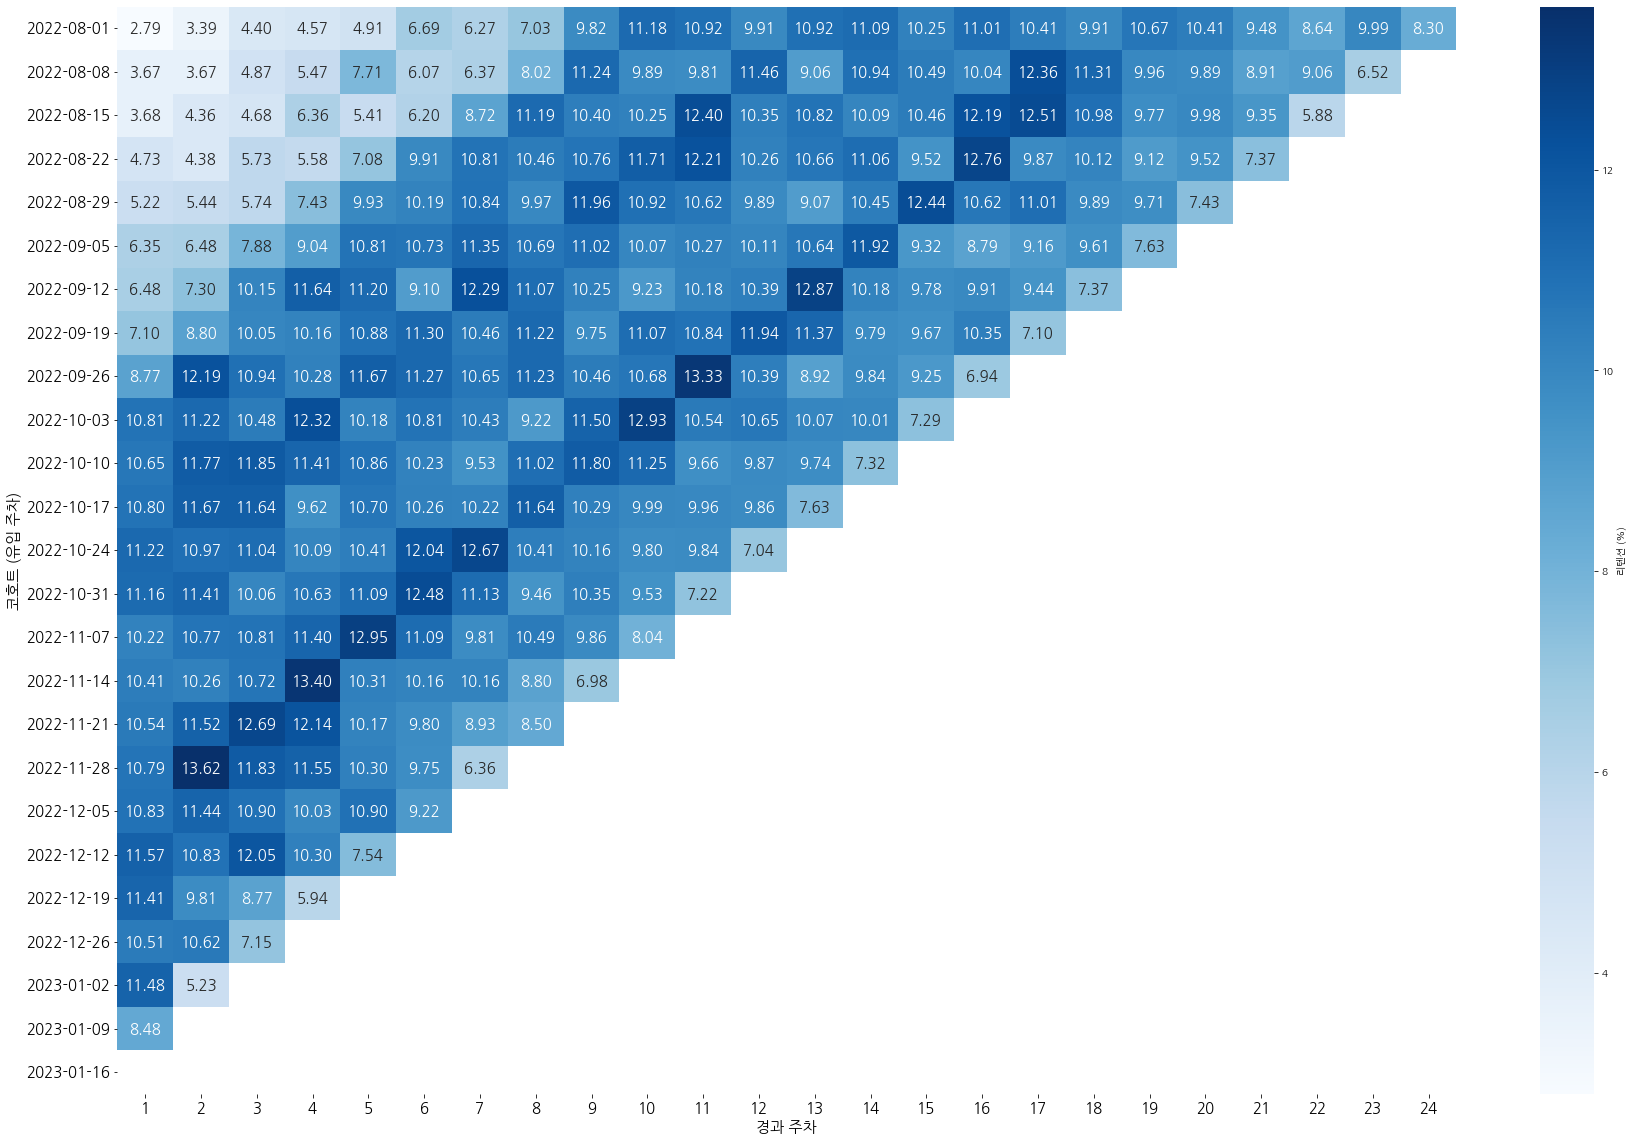

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,20), facecolor='white')

sns.heatmap(
    data=cohort_retention_pivot.drop(columns=[0]).set_index('cohort_week'),
    annot=True,
    fmt='.2f',
    cmap='Blues',
    cbar_kws={'label': '리텐션 (%)'},
    annot_kws={'size': 15},
)

plt.xlabel("경과 주차", fontsize=15)
plt.ylabel("코호트 (유입 주차)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 차트 출력
plt.show()

#### 단기 vs. 중기 vs. 장기

In [78]:
sql = f"""
/* 단기, 중기, 장기 유저별 리텐션 계산 */

/* 주차별 리텐션: 단기 재방문 유저 */

WITH short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  -- 단기 재방문 유저 전체 인원인 9661명, 분석 대상 로그 수 190787건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'short'
  )
)
, week_diff_short_users AS (
    -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
    SELECT
    user_pseudo_id,
    first_date,
    event_date,
    DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
        event_date,
    FROM short_user_logs
    )
)
, week_retain_short_users AS (
    -- 3) 주차별 유저 수 카운팅
    SELECT
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_short_users
    GROUP BY week_diff
)
, week0_retain_short_users AS (
    -- 4) 유입주차 유저 수 카운팅
    SELECT
        ANY_VALUE(week_diff) AS week_diff,
        COUNT(DISTINCT user_pseudo_id) AS first_users
    FROM week_diff_short_users
    WHERE week_diff = 0
)


/* 주문 퍼널: 중기 재방문 유저 */

, mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  -- 중기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'mid'
  )
)
, week_diff_mid_users AS (
    -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
    SELECT
        user_pseudo_id,
        first_date,
        event_date,
        DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
        event_date,
    FROM mid_user_logs
    )
)
, week_retain_mid_users AS (
    -- 3) 주차별 유저 수 카운팅
    SELECT
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_mid_users
    GROUP BY week_diff
)
, week0_retain_mid_users AS (
    -- 4) 유입주차 유저 수 카운팅
    SELECT
        ANY_VALUE(week_diff) AS week_diff,
        COUNT(DISTINCT user_pseudo_id) AS first_users
    FROM week_diff_mid_users
    WHERE week_diff = 0
)


/* 주문 퍼널: 장기 재방문 유저 */

, long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  -- 장기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'long'
  )
)
, week_diff_long_users AS (
    -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
    SELECT
        user_pseudo_id,
        first_date,
        event_date,
        DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
        event_date,
    FROM long_user_logs
    )
)
, week_retain_long_users AS (
    -- 3) 주차별 유저 수 카운팅
    SELECT
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_long_users
    GROUP BY week_diff
)
, week0_retain_long_users AS (
    -- 4) 유입주차 유저 수 카운팅
    SELECT
        ANY_VALUE(week_diff) AS week_diff,
        COUNT(DISTINCT user_pseudo_id) AS first_users
    FROM week_diff_long_users
    WHERE week_diff = 0
)


-- 주차별 리텐션 계산
SELECT
    'short' AS user_segment,
    w.week_diff,
    w.retain_users,
    f.first_users AS first_users,
    ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
FROM week_retain_short_users w
CROSS JOIN week0_retain_short_users f

UNION ALL

-- 주차별 리텐션 계산
SELECT
    'mid' AS user_segment,
    w.week_diff,
    w.retain_users,
    f.first_users AS first_users,
    ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
FROM week_retain_mid_users w
CROSS JOIN week0_retain_mid_users f

UNION ALL

-- 주차별 리텐션 계산
SELECT
    'long' AS user_segment,
    w.week_diff,
    w.retain_users,
    f.first_users AS first_users,
    ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
FROM week_retain_long_users w
CROSS JOIN week0_retain_long_users f

ORDER BY user_segment, week_diff
"""

query_job = client.query(sql)
df_retention_w_visit_interval = query_job.to_dataframe()
df_retention_w_visit_interval.head()

,user_segment,week_diff,retain_users,first_users,retention_rate
0,long,0,18349,18349,100.000
1,long,1,1080,18349,5.886
2,long,2,1018,18349,5.548
3,long,3,933,18349,5.085
4,long,4,1239,18349,6.752


In [79]:
retention_w_short = df_retention_w_visit_interval.loc[df_retention_w_visit_interval['user_segment']=='short']
retention_w_mid = df_retention_w_visit_interval.loc[df_retention_w_visit_interval['user_segment']=='mid']
retention_w_long = df_retention_w_visit_interval.loc[df_retention_w_visit_interval['user_segment']=='long']

fig = go.Figure()

fig.add_trace(go.Scatter(x = retention_w_short['week_diff'],
                         y = retention_w_short['retention_rate'],
                         name = 'short_term users'
))

fig.add_trace(go.Scatter(x = retention_w_mid['week_diff'],
                         y = retention_w_mid['retention_rate'],
                         name = 'mid_term users'
))


fig.add_trace(go.Scatter(x = retention_w_long['week_diff'],
                         y = retention_w_long['retention_rate'],
                         name = 'long_term users'
))

fig.update_layout(
    title_text="주차별 리텐션: 단기 vs. 중기 vs. 장기",
    margin_l=50,
    margin_r=20,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98
)
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='retention (%)')

fig.show()

#### 통계적 검정: 그룹간 재방문율 차이

##### Kruskal-Wallis test

- 귀무가설: 단기, 중기, 장기 재방문 유저간 재방문율 차이가 없다.
- 대립가설: 단기, 중기, 장기 재방문 유저간 재방문율 차이가 있다.

In [80]:
from scipy.stats import kruskal

kruskal(retention_w_short['retention_rate'], retention_w_mid['retention_rate'], retention_w_long['retention_rate'])

KruskalResult(statistic=0.35522021167633644, pvalue=0.8372688060766738)

- 검정 결과 p-value가 0.05보다 크므로 대립가설 기각.
- 즉, 단기/중기/장기 재방문 유저간 리텐션 차이가 유의미하지 않다.

#### (코호트) 단기 vs. 중기 vs. 장기

In [81]:
sql = f"""
/* 단기, 중기, 장기 유저별 코호트 리텐션 계산 */

/* 주차별 리텐션: 단기 재방문 유저 */

WITH short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  -- 단기 재방문 유저 전체 인원인 9661명, 분석 대상 로그 수 190787건
  SELECT
    event_date,
    user_pseudo_id,
    user_id,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'short'
  )
  GROUP BY ALL
)
, week_diff_short_users AS (
    -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
    SELECT
        user_pseudo_id,
        first_date,
        event_date,
        DATE_TRUNC(first_date, WEEK(MONDAY)) AS cohort_week,
        DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
    FROM (
        SELECT DISTINCT
            user_pseudo_id,
            MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
            event_date,
        FROM short_user_logs
    )
)
, week_retain_short_users AS (
    -- 3) 주차별 유저 수 카운팅
    SELECT
        cohort_week,
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_short_users
    GROUP BY cohort_week, week_diff
)


/* 주문 퍼널: 중기 재방문 유저 */

, mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  SELECT
    event_date,
    user_pseudo_id,
    user_id,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'mid'
  )
  GROUP BY ALL
)
, week_diff_mid_users AS (
    -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
    SELECT
        user_pseudo_id,
        first_date,
        event_date,
        DATE_TRUNC(first_date, WEEK(MONDAY)) AS cohort_week,
        DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
    FROM (
        SELECT DISTINCT
            user_pseudo_id,
            MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
            event_date,
        FROM mid_user_logs
    )
)
, week_retain_mid_users AS (
    -- 3) 주차별 유저 수 카운팅
    SELECT
        cohort_week,
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_mid_users
    GROUP BY cohort_week, week_diff
)


/* 주문 퍼널: 장기 재방문 유저 */

, long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  SELECT
    event_date,
    user_pseudo_id,
    user_id,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'long'
  )
  GROUP BY ALL
)
, week_diff_long_users AS (
    -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
    SELECT
        user_pseudo_id,
        first_date,
        event_date,
        DATE_TRUNC(first_date, WEEK(MONDAY)) AS cohort_week,
        DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
    FROM (
        SELECT DISTINCT
            user_pseudo_id,
            MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
            event_date,
        FROM long_user_logs
    )
)
, week_retain_long_users AS (
    -- 3) 주차별 유저 수 카운팅
    SELECT
        cohort_week,
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_long_users
    GROUP BY cohort_week, week_diff
)


-- 주차별 리텐션 계산
SELECT
    'short' AS user_segment,
    *,
    ROUND(SAFE_DIVIDE(retain_users, first_week_users)*100,3) AS cohort_retention_rate
FROM (
    SELECT
        cohort_week,
        week_diff,
        retain_users,
        FIRST_VALUE(retain_users) OVER (PARTITION BY cohort_week ORDER BY week_diff) AS first_week_users,
    FROM week_retain_short_users
)


UNION ALL

-- 주차별 리텐션 계산
SELECT
    'mid' AS user_segment,
    *,
    ROUND(SAFE_DIVIDE(retain_users, first_week_users)*100,3) AS cohort_retention_rate
FROM (
    SELECT
        cohort_week,
        week_diff,
        retain_users,
        FIRST_VALUE(retain_users) OVER (PARTITION BY cohort_week ORDER BY week_diff) AS first_week_users,
    FROM week_retain_mid_users
)


UNION ALL

-- 주차별 리텐션 계산
SELECT
    'long' AS user_segment,
    *,
    ROUND(SAFE_DIVIDE(retain_users, first_week_users)*100,3) AS cohort_retention_rate
FROM (
    SELECT
        cohort_week,
        week_diff,
        retain_users,
        FIRST_VALUE(retain_users) OVER (PARTITION BY cohort_week ORDER BY week_diff) AS first_week_users,
    FROM week_retain_long_users
)

ORDER BY user_segment, cohort_week, week_diff
"""

query_job = client.query(sql)
cohort_retention_visit_interval = query_job.to_dataframe()
cohort_retention_visit_interval.head()

,user_segment,cohort_week,week_diff,retain_users,first_week_users,cohort_retention_rate
0,long,2022-08-01,0,735,735,100.000
1,long,2022-08-01,1,15,735,2.041
2,long,2022-08-01,2,21,735,2.857
3,long,2022-08-01,3,21,735,2.857
4,long,2022-08-01,4,21,735,2.857


In [82]:
# 피봇 테이블 생성

cohort_retention_short = cohort_retention_visit_interval.loc[cohort_retention_visit_interval['user_segment']=='short']
cohort_retention_mid = cohort_retention_visit_interval.loc[cohort_retention_visit_interval['user_segment']=='mid']
cohort_retention_long = cohort_retention_visit_interval.loc[cohort_retention_visit_interval['user_segment']=='long']

# 단기 재방문 유저

# active user per cohort
cohort_retention_short['retain_users'] = cohort_retention_short['retain_users'].astype(float)

cohort_au_pivot_short = pd.pivot_table(
    data=cohort_retention_short,
    index='cohort_week', 
    columns='week_diff', 
    values='retain_users'
).reset_index().rename_axis(None, axis=1)

# retention per cohort
cohort_retention_pivot_short = pd.pivot_table(
    data=cohort_retention_short, 
    index='cohort_week', 
    columns='week_diff', 
    values='cohort_retention_rate'
).reset_index().rename_axis(None, axis=1)


# 중기 재방문 유저

# active user per cohort
cohort_retention_mid['retain_users'] = cohort_retention_mid['retain_users'].astype(float)

cohort_au_pivot_mid = pd.pivot_table(
    data=cohort_retention_mid,
    index='cohort_week', 
    columns='week_diff', 
    values='retain_users'
).reset_index().rename_axis(None, axis=1)

# retention per cohort
cohort_retention_pivot_mid = pd.pivot_table(
    data=cohort_retention_mid, 
    index='cohort_week', 
    columns='week_diff', 
    values='cohort_retention_rate'
).reset_index().rename_axis(None, axis=1)


# 장기 재방문 유저

# active user per cohort
cohort_retention_long['retain_users'] = cohort_retention_long['retain_users'].astype(float)

cohort_au_pivot_long = pd.pivot_table(
    data=cohort_retention_long,
    index='cohort_week', 
    columns='week_diff', 
    values='retain_users'
).reset_index().rename_axis(None, axis=1)

# retention per cohort
cohort_retention_pivot_long = pd.pivot_table(
    data=cohort_retention_long, 
    index='cohort_week', 
    columns='week_diff', 
    values='cohort_retention_rate'
).reset_index().rename_axis(None, axis=1)

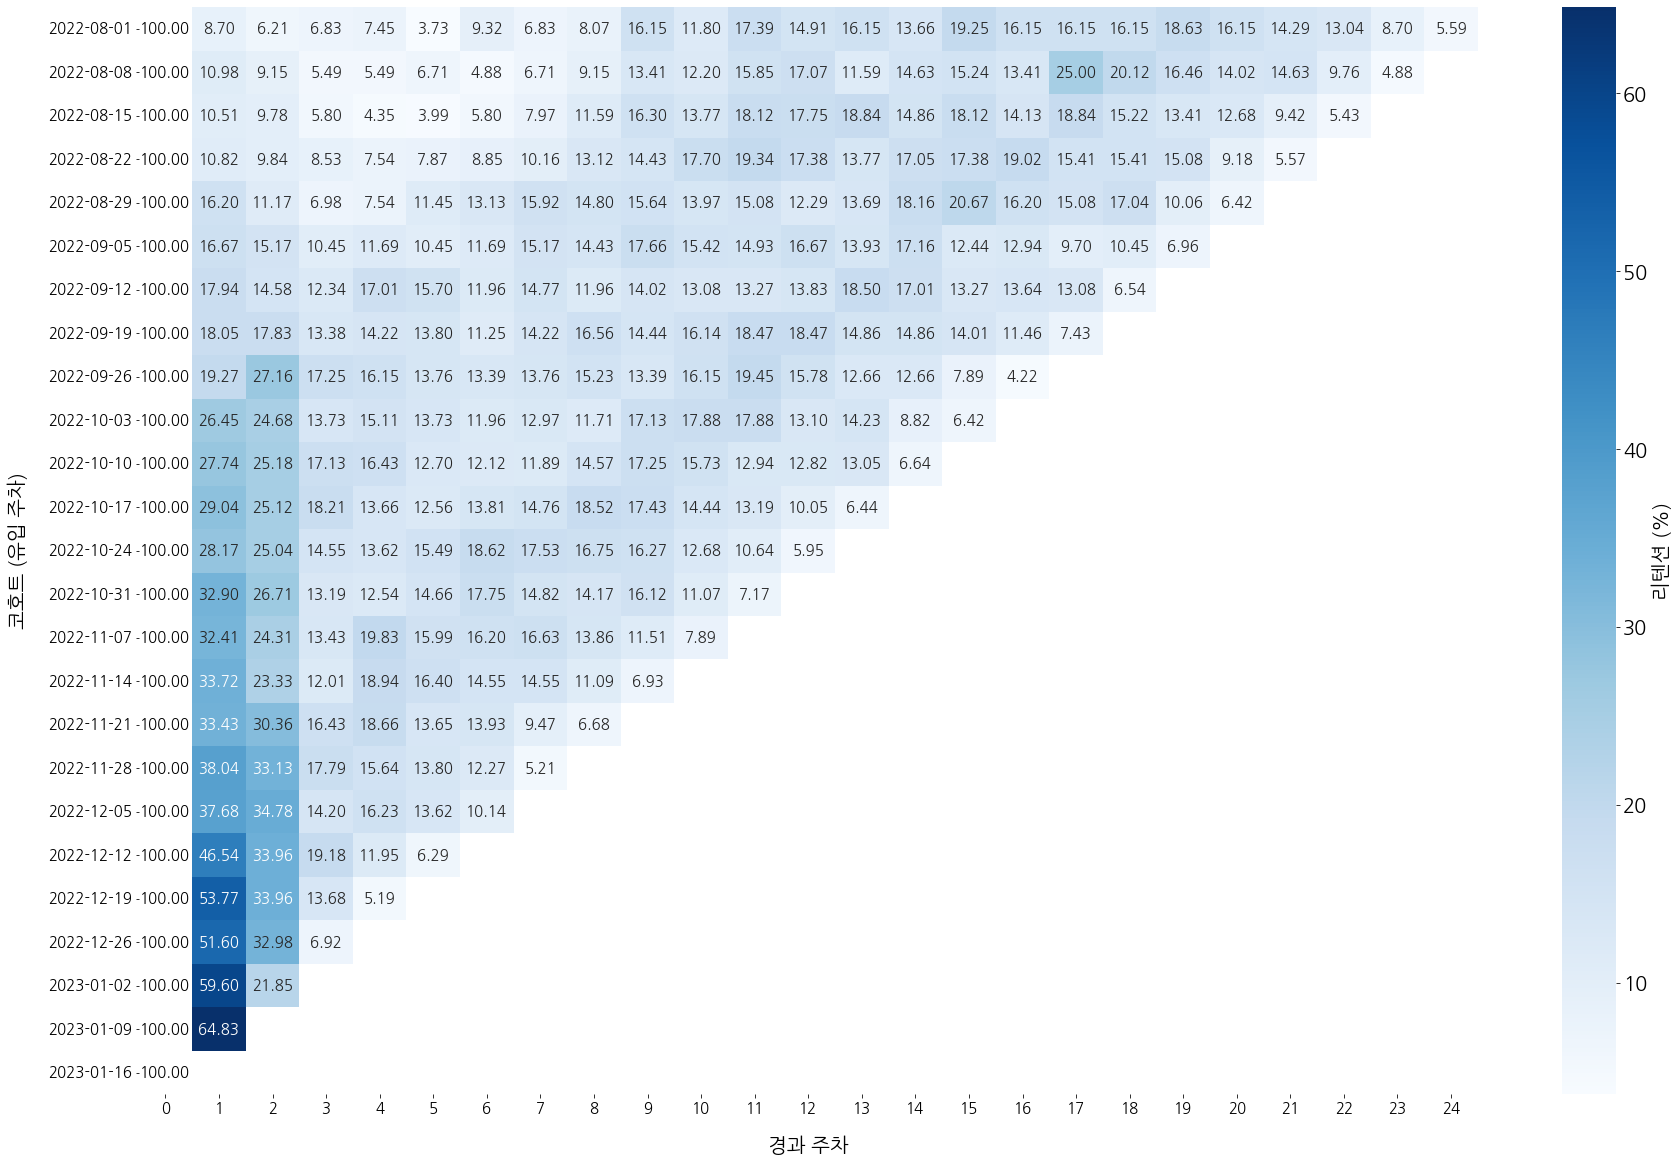

In [83]:
# 단기 재방문 유저: 리텐션

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(30,20), facecolor='white')

# 0주차에 대해서만 색 칠하기 제외 (True로 설정)
mask = np.zeros_like(cohort_retention_pivot_short.set_index('cohort_week'), dtype=bool)
mask[:,:1] = True

# 0주차 제외한 파트: 값 표시 제외
sns.heatmap(
    data=cohort_retention_pivot_short.set_index('cohort_week'),
    mask=mask,
    annot=False,
    cmap='Blues',
    cbar=True
)

# 0주차 제외한 파트: 값 표시 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_retention_pivot_short.set_index('cohort_week'),
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    annot_kws={'size': 15},
    cbar=False,
    alpha=0.0
)

# 0주차 글자 표기 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_retention_pivot_short.set_index('cohort_week'),
    mask=~mask,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    annot_kws={
        'size': 15,
        'color': 'black',
    },
    cbar=False,
    alpha=0.0
)

plt.xlabel("경과 주차", fontsize=20, labelpad=20)
plt.ylabel("코호트 (유입 주차)", fontsize=20, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# colorbar 설정
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('리텐션 (%)', fontsize=20)


# 차트 출력
plt.show()

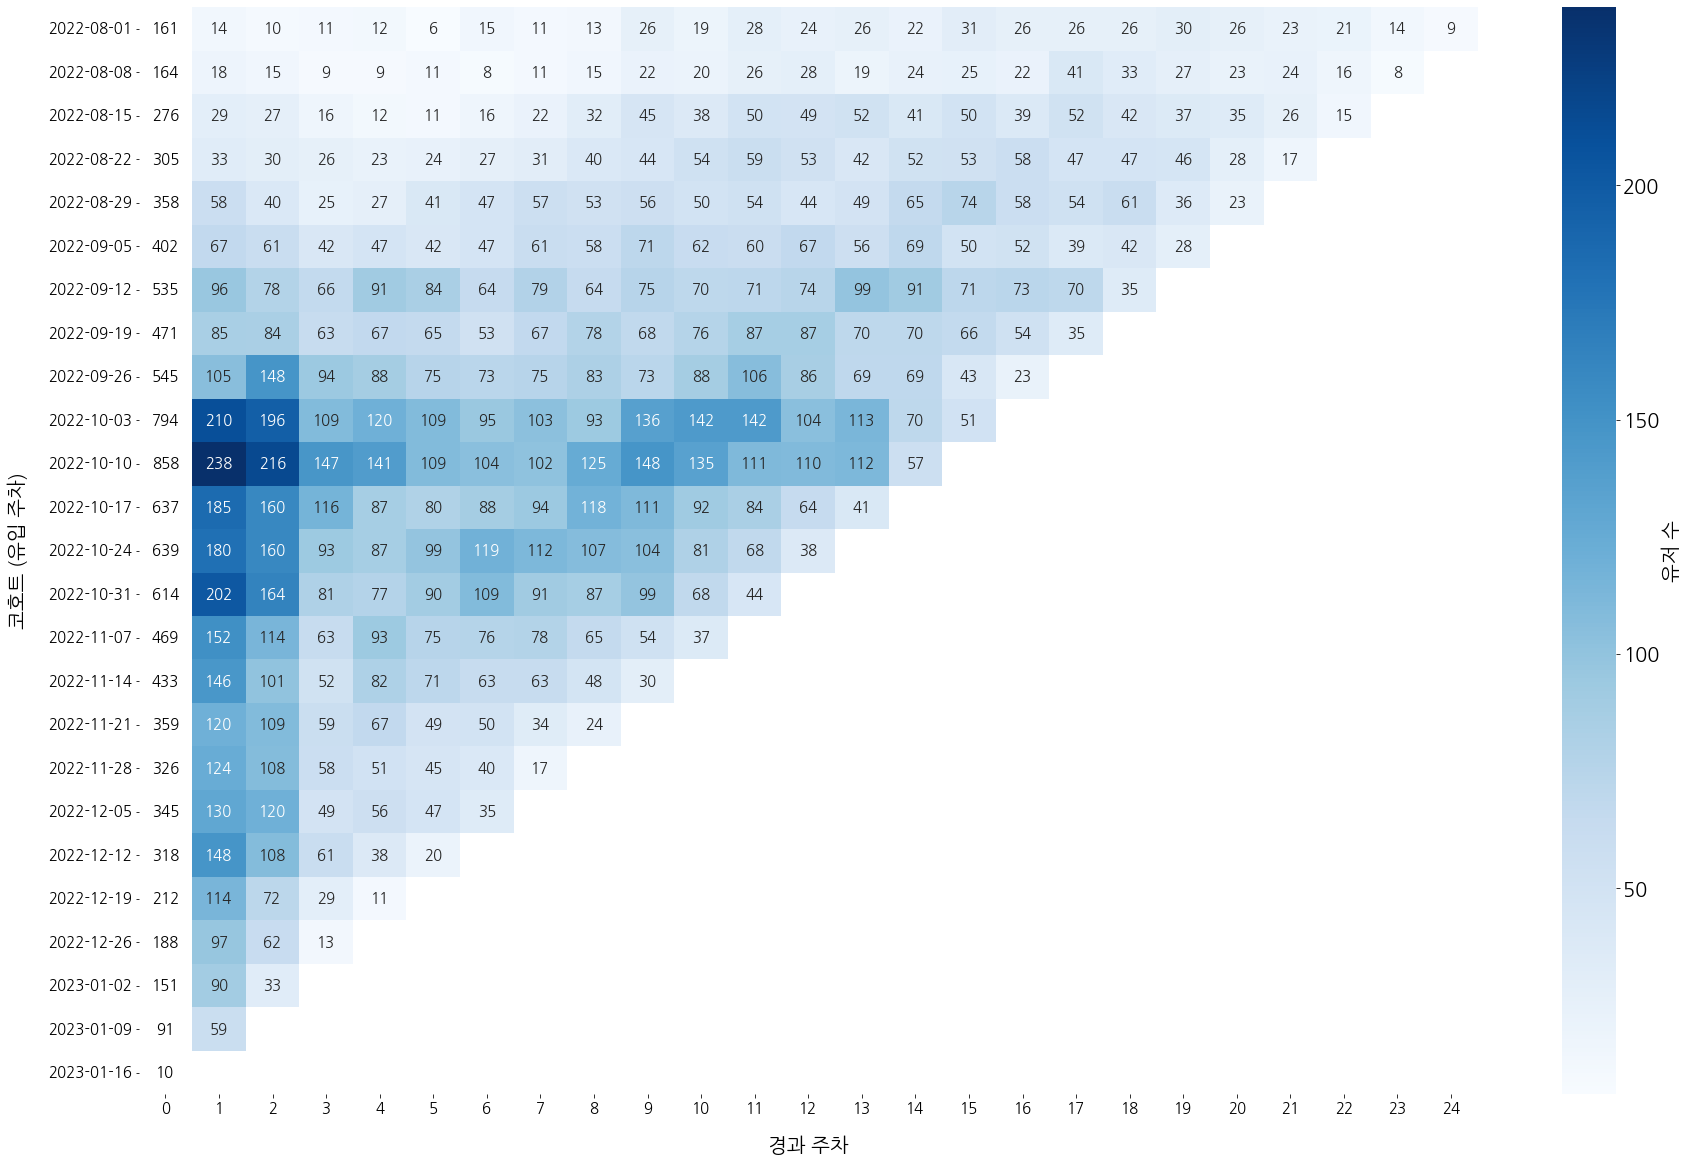

In [84]:
# 단기 재방문 유저: 유저 수

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(30,20), facecolor='white')

# 0주차에 대해서만 색 칠하기 제외 (True로 설정)
mask = np.zeros_like(cohort_au_pivot_short.set_index('cohort_week'), dtype=bool)
mask[:,:1] = True


# 0주차 제외한 파트: 값 표시 제외
sns.heatmap(
    data=cohort_au_pivot_short.set_index('cohort_week'),
    mask=mask,
    annot=False,
    cmap='Blues',
    cbar=True
)

# 0주차 제외한 파트: 값 표시 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_au_pivot_short.set_index('cohort_week'),
    mask=mask,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    annot_kws={'size': 15},
    cbar=False,
    alpha=0.0
)

# 0주차 글자 표기 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_au_pivot_short.set_index('cohort_week'),
    mask=~mask,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    annot_kws={
        'size': 15,
        'color': 'black',
    },
    cbar=False,
    alpha=0.0
)


plt.xlabel("경과 주차", fontsize=20, labelpad=20)
plt.ylabel("코호트 (유입 주차)", fontsize=20, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# colorbar 설정
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('유저 수', fontsize=20)

# 차트 출력
plt.show()

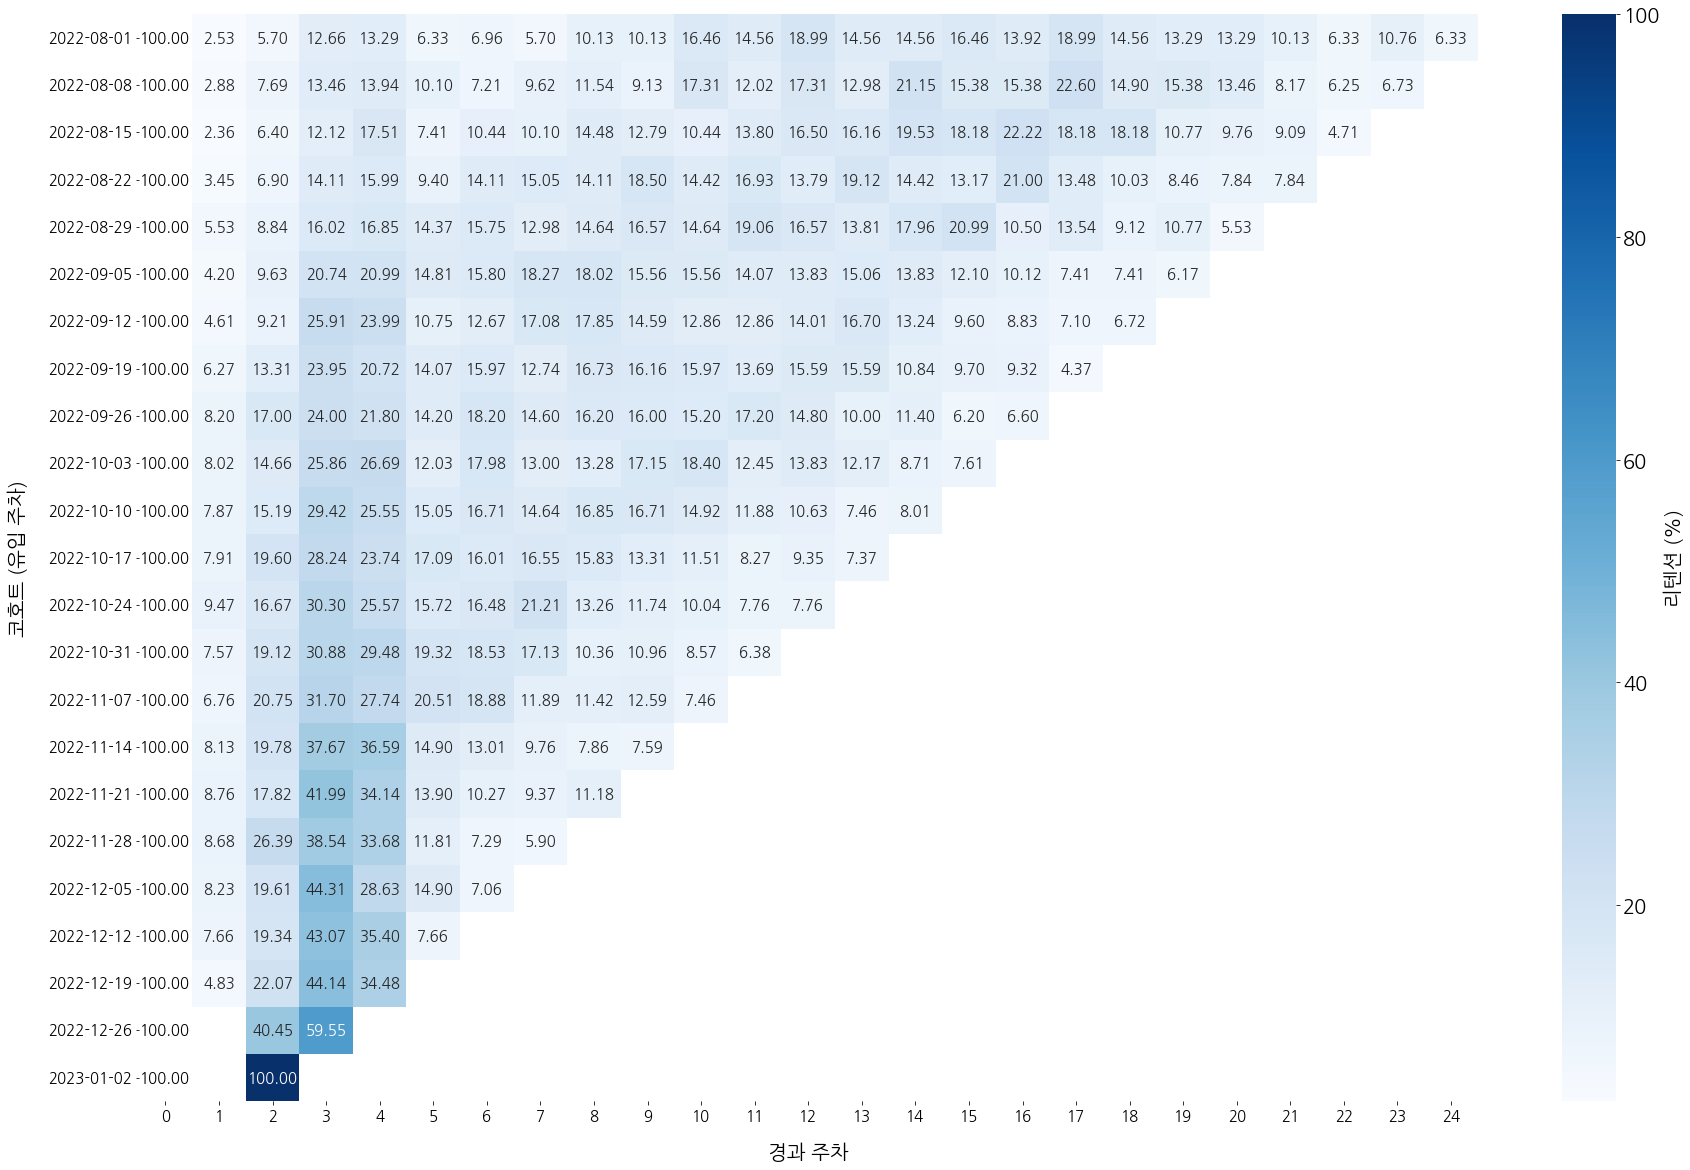

In [85]:
# 중기 재방문 유저: 리텐션

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(30,20), facecolor='white')

# 0주차에 대해서만 색 칠하기 제외 (True로 설정)
mask = np.zeros_like(cohort_retention_pivot_mid.set_index('cohort_week'), dtype=bool)
mask[:,:1] = True


# 0주차 제외한 파트: 값 표시 제외
sns.heatmap(
    data=cohort_retention_pivot_mid.set_index('cohort_week'),
    mask=mask,
    annot=False,
    cmap='Blues',
    cbar=True
)

# 0주차 제외한 파트: 값 표시 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_retention_pivot_mid.set_index('cohort_week'),
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    annot_kws={'size': 15},
    cbar=False,
    alpha=0.0
)

# 0주차 글자 표기 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_retention_pivot_mid.set_index('cohort_week'),
    mask=~mask,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    annot_kws={
        'size': 15,
        'color': 'black',
    },
    cbar=False,
    alpha=0.0
)


plt.xlabel("경과 주차", fontsize=20, labelpad=20)
plt.ylabel("코호트 (유입 주차)", fontsize=20, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# colorbar 설정
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('리텐션 (%)', fontsize=20)

# 차트 출력
plt.show()

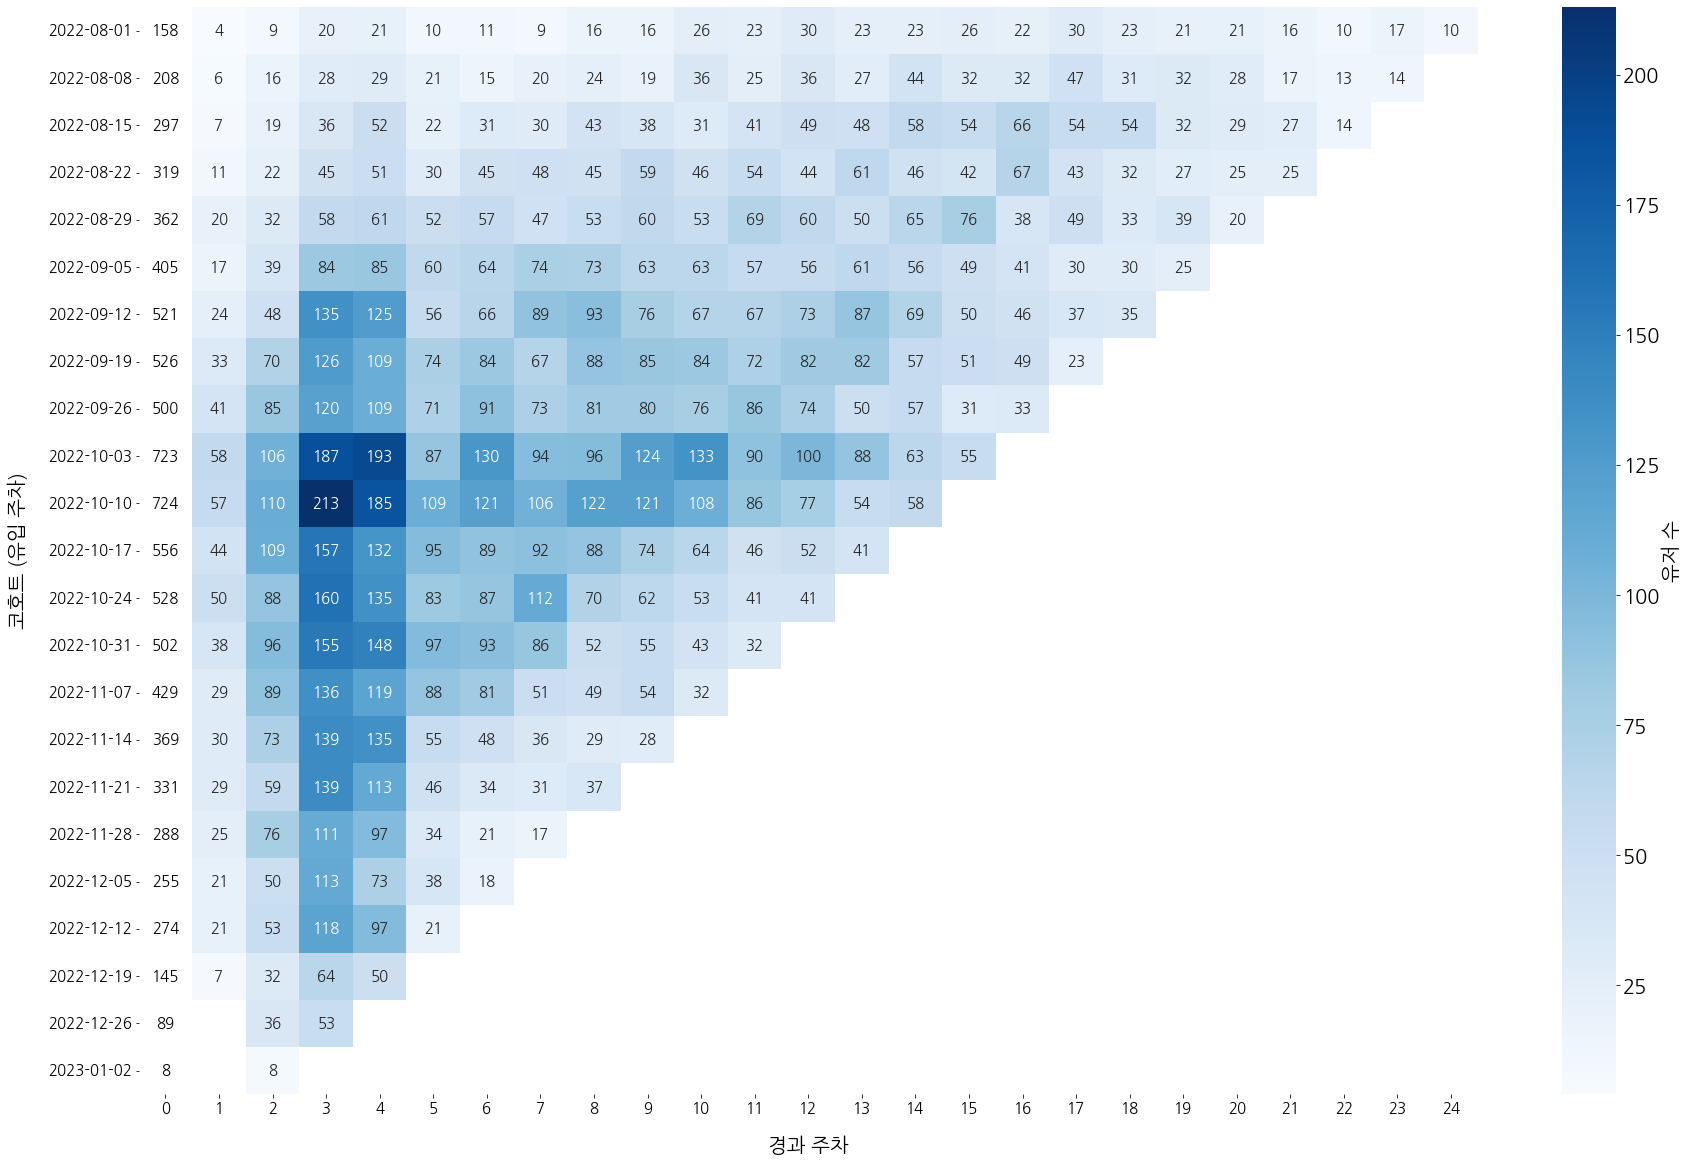

In [86]:
# 중기 재방문 유저: 유저 수

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,20), facecolor='white')

# 0주차에 대해서만 색 칠하기 제외 (True로 설정)
mask = np.zeros_like(cohort_au_pivot_mid.set_index('cohort_week'), dtype=bool)
mask[:,:1] = True


# 0주차 제외한 파트: 값 표시 제외
sns.heatmap(
    data=cohort_au_pivot_mid.set_index('cohort_week'),
    mask=mask,
    annot=False,
    cmap='Blues',
    cbar=True
)

# 0주차 제외한 파트: 값 표시 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_au_pivot_mid.set_index('cohort_week'),
    mask=mask,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    annot_kws={'size': 15},
    cbar=False,
    alpha=0.0
)

# 0주차 글자 표기 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_au_pivot_mid.set_index('cohort_week'),
    mask=~mask,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    annot_kws={
        'size': 15,
        'color': 'black',
    },
    cbar=False,
    alpha=0.0
)

plt.xlabel("경과 주차", fontsize=20, labelpad=20)
plt.ylabel("코호트 (유입 주차)", fontsize=20, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# colorbar 설정
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('유저 수', fontsize=20)

# 차트 출력
plt.show()

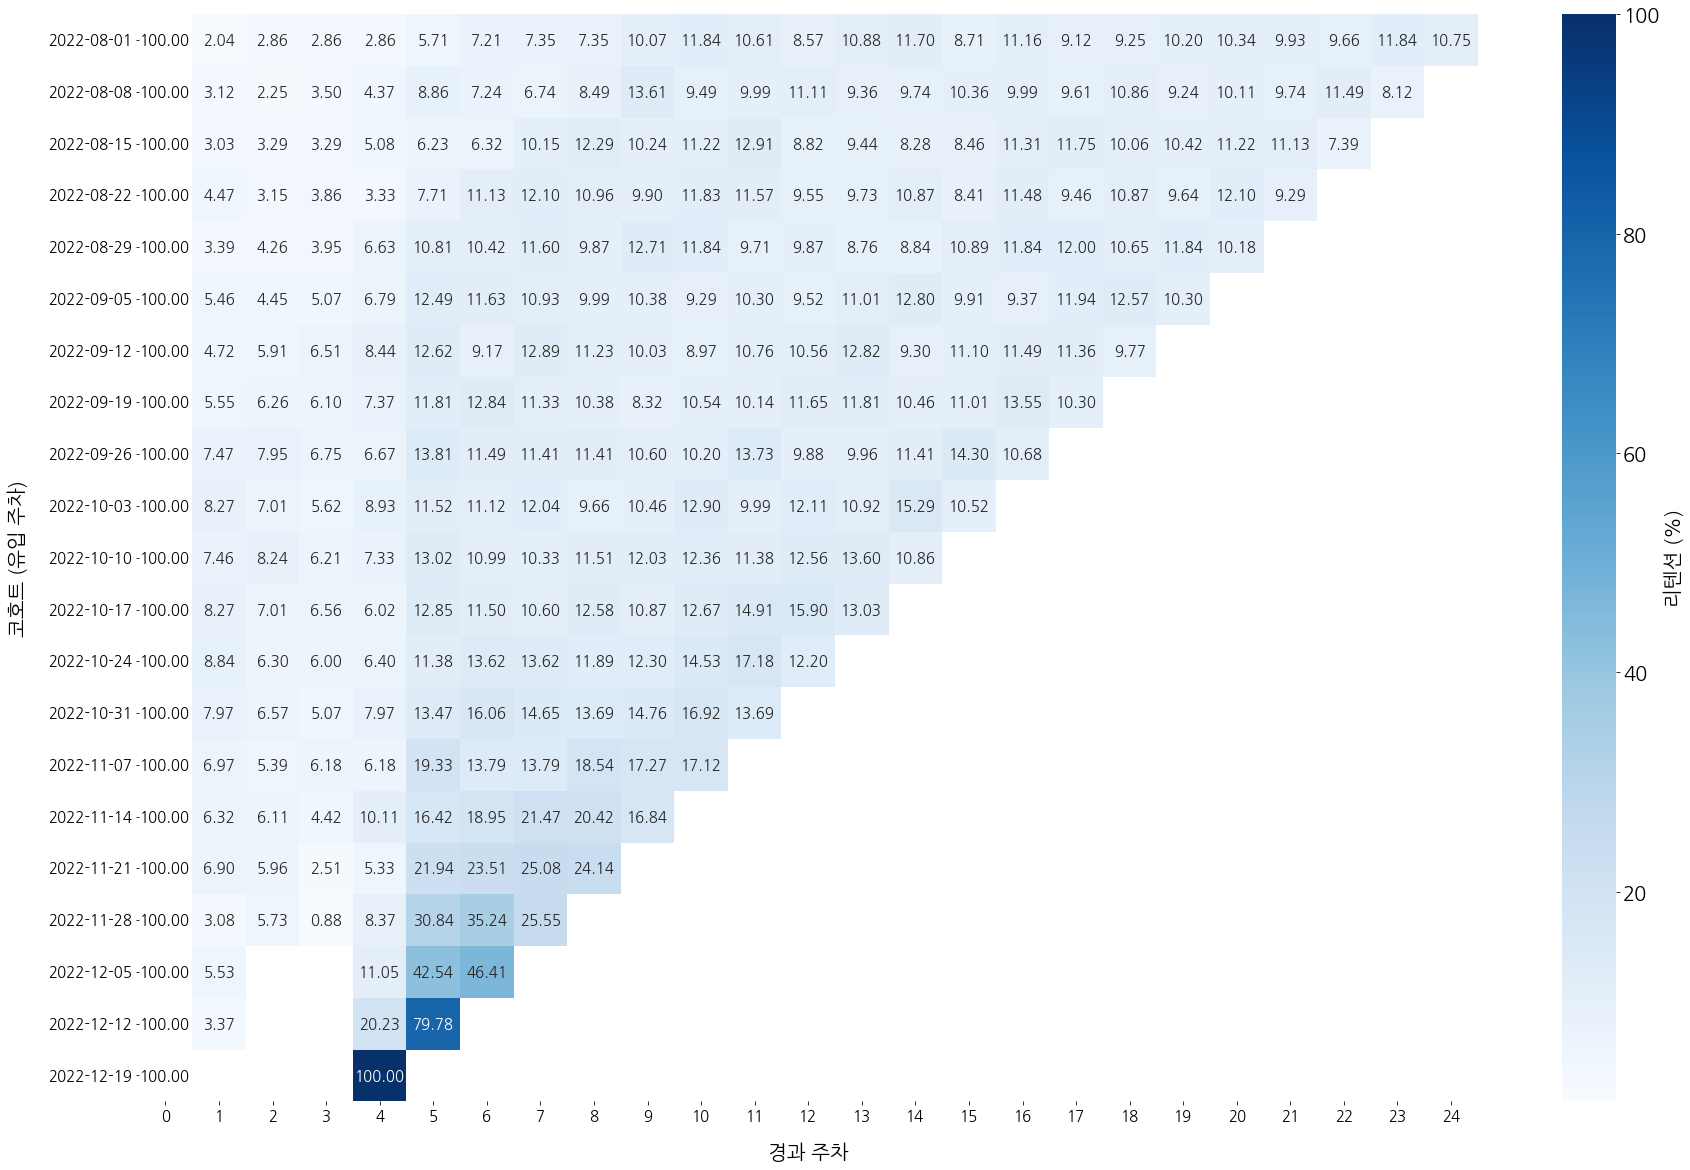

In [87]:
# 장기 재방문 유저: 리텐션

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,20), facecolor='white')

# 0주차에 대해서만 색 칠하기 제외 (True로 설정)
mask = np.zeros_like(cohort_retention_pivot_long.set_index('cohort_week'), dtype=bool)
mask[:,:1] = True

# 0주차 제외한 파트: 값 표시 제외
sns.heatmap(
    data=cohort_retention_pivot_long.set_index('cohort_week'),
    mask=mask,
    annot=False,
    cmap='Blues',
    cbar=True
)

# 0주차 제외한 파트: 값 표시 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_retention_pivot_long.set_index('cohort_week'),
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    annot_kws={'size': 15},
    cbar=False,
    alpha=0.0
)

# 0주차 글자 표기 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_retention_pivot_long.set_index('cohort_week'),
    mask=~mask,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    annot_kws={
        'size': 15,
        'color': 'black',
    },
    cbar=False,
    alpha=0.0
)

plt.xlabel("경과 주차", fontsize=20, labelpad=20)
plt.ylabel("코호트 (유입 주차)", fontsize=20, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# colorbar 설정
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('리텐션 (%)', fontsize=20)

# 차트 출력
plt.show()

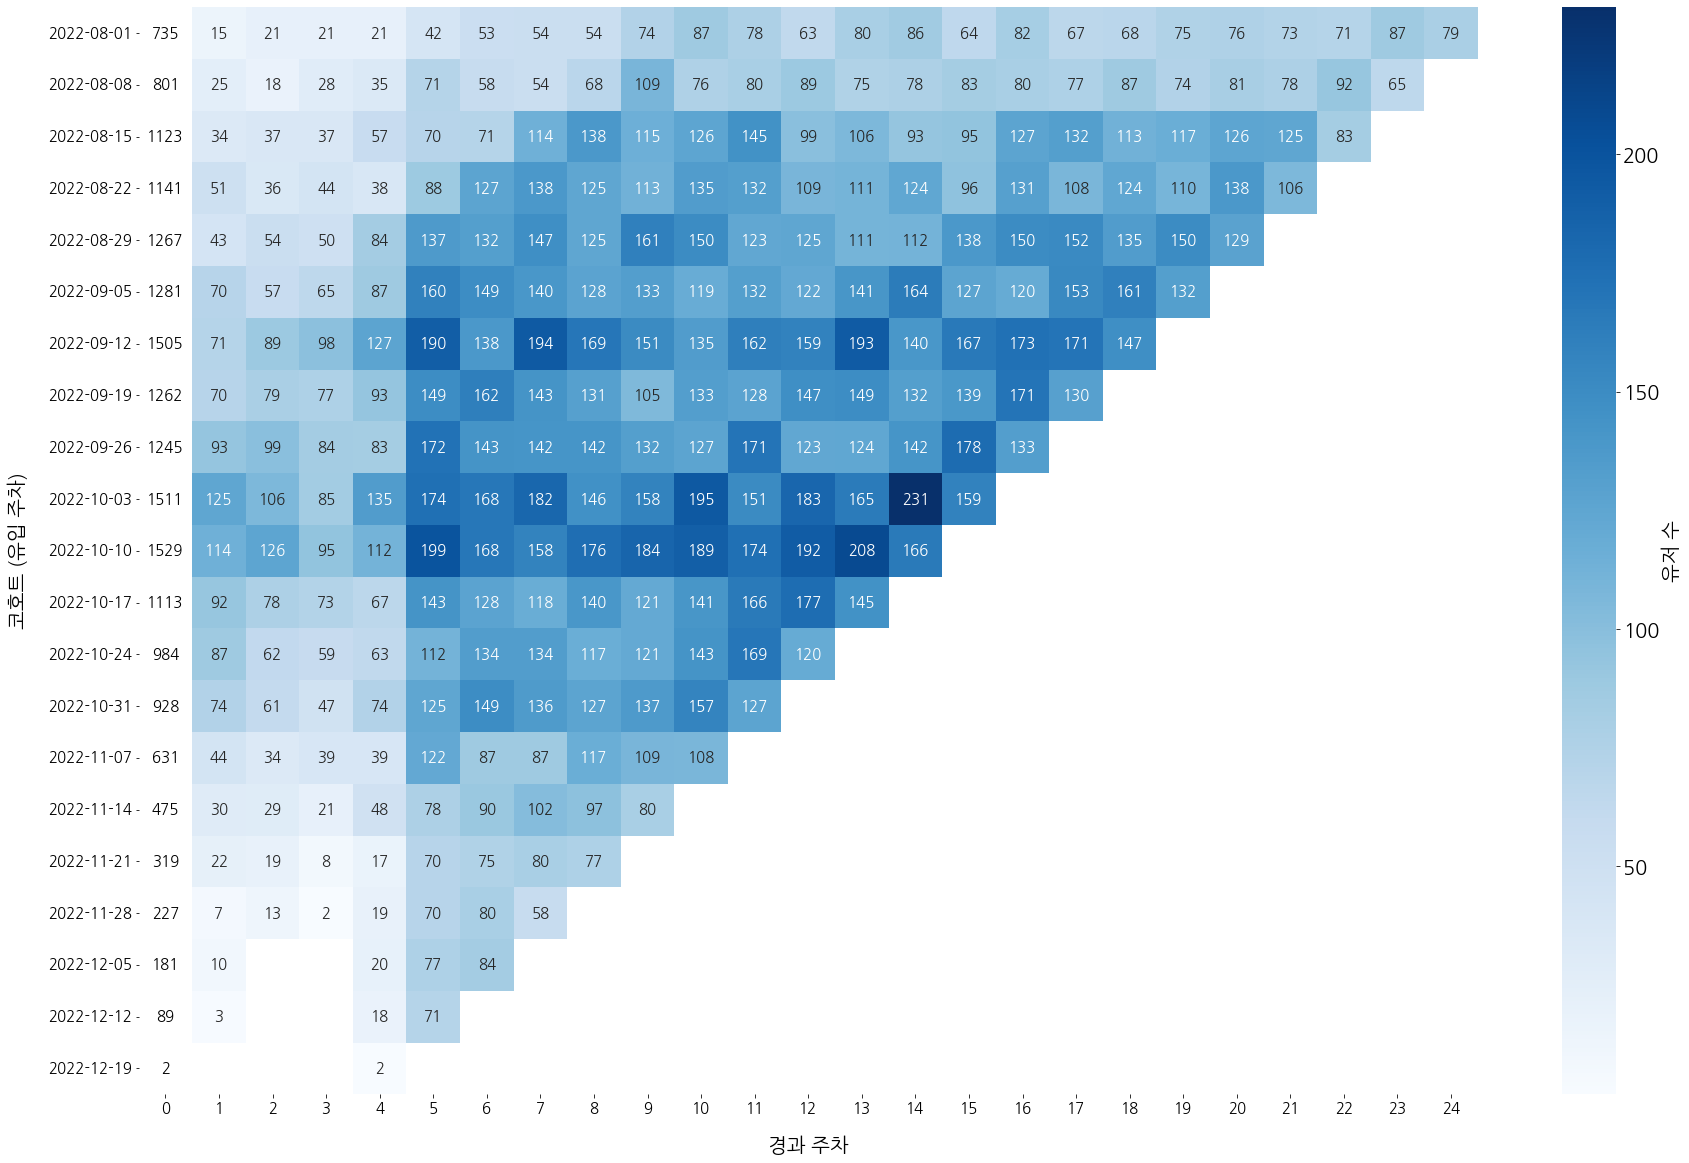

In [88]:
# 장기 재방문 유저: 유저 수

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(30,20), facecolor='white')

# 0주차에 대해서만 색 칠하기 제외 (True로 설정)
mask = np.zeros_like(cohort_au_pivot_long.set_index('cohort_week'), dtype=bool)
mask[:,:1] = True

# 0주차 제외한 파트: 값 표시 제외
sns.heatmap(
    data=cohort_au_pivot_long.set_index('cohort_week'),
    mask=mask,
    annot=False,
    cmap='Blues',
    cbar=True
)

# 0주차 제외한 파트: 값 표시 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_au_pivot_long.set_index('cohort_week'),
    mask=mask,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    annot_kws={'size': 15},
    cbar=False,
    alpha=0.0
)

# 0주차 글자 표기 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_au_pivot_long.set_index('cohort_week'),
    mask=~mask,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    annot_kws={
        'size': 15,
        'color': 'black',
    },
    cbar=False,
    alpha=0.0
)

plt.xlabel("경과 주차", fontsize=20, labelpad=20)
plt.ylabel("코호트 (유입 주차)", fontsize=20, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# colorbar 설정
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('유저 수', fontsize=20)

# 차트 출력
plt.show()

#### 통계적 검정: 그룹간 재방문율 차이

##### Kruskal-Wallis test

- 귀무가설: 단기, 중기, 장기 재방문 유저간 재방문율 차이가 없다.
- 대립가설: 단기, 중기, 장기 재방문 유저간 재방문율 차이가 있다.

In [89]:
from scipy.stats import kruskal

# 각 그룹에 대해 코호트별로 리텐션 중위수 계산
cohort_short_median = cohort_retention_short.groupby('cohort_week').agg({'cohort_retention_rate':'median'}).reset_index()
cohort_mid_median = cohort_retention_mid.groupby('cohort_week').agg({'cohort_retention_rate':'median'}).reset_index()
cohort_long_median = cohort_retention_long.groupby('cohort_week').agg({'cohort_retention_rate':'median'}).reset_index()

cohort_median_visit_interval = pd.merge(cohort_short_median, cohort_mid_median, on='cohort_week', how='outer').merge(cohort_long_median, on='cohort_week', how='outer').rename(columns={'cohort_retention_rate_x':'short', 'cohort_retention_rate_y':'mid', 'cohort_retention_rate':'long'})
cohort_median_visit_interval.fillna(0, inplace=True)

print(kruskal(cohort_median_visit_interval['short'], cohort_median_visit_interval['mid'], cohort_median_visit_interval['long']))


# 각 그룹에 대해 코호트별로 리텐션 평균 계산
cohort_short_mean = cohort_retention_short.groupby('cohort_week').agg({'cohort_retention_rate':'mean'}).reset_index()
cohort_mid_mean = cohort_retention_mid.groupby('cohort_week').agg({'cohort_retention_rate':'mean'}).reset_index()
cohort_long_mean = cohort_retention_long.groupby('cohort_week').agg({'cohort_retention_rate':'mean'}).reset_index()

cohort_mean_visit_interval = pd.merge(cohort_short_mean, cohort_mid_mean, on='cohort_week', how='outer').merge(cohort_long_mean, on='cohort_week', how='outer').rename(columns={'cohort_retention_rate_x':'short', 'cohort_retention_rate_y':'mid', 'cohort_retention_rate':'long'})
cohort_mean_visit_interval.fillna(0, inplace=True)

print(kruskal(cohort_mean_visit_interval['short'], cohort_mean_visit_interval['mid'], cohort_mean_visit_interval['long']))


KruskalResult(statistic=14.163478458888994, pvalue=0.0008403103841433449)
KruskalResult(statistic=11.860221744637855, pvalue=0.002658187253052764)


- 귀무가설: 단기, 중기, 장기 재방문 유저간 유입 주차별 유저 수 차이가 없다.
- 대립가설: 단기, 중기, 장기 재방문 유저간 유입 주차별 유저 수 차이가 있다.

In [90]:
from scipy.stats import kruskal

# 각 그룹에 대해 코호트별로 유저 수 중위수 계산
cohort_au_short_median = cohort_retention_short.groupby('cohort_week').agg({'retain_users':'median'}).reset_index()
cohort_au_mid_median = cohort_retention_mid.groupby('cohort_week').agg({'retain_users':'median'}).reset_index()
cohort_au_long_median = cohort_retention_long.groupby('cohort_week').agg({'retain_users':'median'}).reset_index()

cohort_au_median_visit_interval = pd.merge(cohort_au_short_median, cohort_au_mid_median, on='cohort_week', how='outer').merge(cohort_au_long_median, on='cohort_week', how='outer').rename(columns={'retain_users_x':'short', 'retain_users_y':'mid', 'retain_users':'long'})
cohort_au_median_visit_interval.fillna(0, inplace=True)

print(kruskal(cohort_au_median_visit_interval['short'], cohort_au_median_visit_interval['mid'], cohort_au_median_visit_interval['long']))


# 각 그룹에 대해 코호트별로 유저 수 평균 계산
cohort_au_short_mean = cohort_retention_short.groupby('cohort_week').agg({'retain_users':'mean'}).reset_index()
cohort_au_mid_mean = cohort_retention_mid.groupby('cohort_week').agg({'retain_users':'mean'}).reset_index()
cohort_au_long_mean = cohort_retention_long.groupby('cohort_week').agg({'retain_users':'mean'}).reset_index()

cohort_au_mean_visit_interval = pd.merge(cohort_au_short_mean, cohort_au_mid_mean, on='cohort_week', how='outer').merge(cohort_au_long_mean, on='cohort_week', how='outer').rename(columns={'retain_users_x':'short', 'retain_users_y':'mid', 'retain_users':'long'})
cohort_au_mean_visit_interval.fillna(0, inplace=True)

print(kruskal(cohort_au_mean_visit_interval['short'], cohort_au_mean_visit_interval['mid'], cohort_au_mean_visit_interval['long']))

KruskalResult(statistic=6.39732285706152, pvalue=0.04081680363625462)
KruskalResult(statistic=4.450721127161435, pvalue=0.1080284604832748)


- 검정 결과 p-value가 0.05보다 작으므로 대립가설 채택.
- 즉, 단기/중기/장기 재방문 유저간 주차별 유입 주차별 유저 수 차이가 유의미하다.

##### 사후검정: bonferroni
- 어떤 그룹 간 (pair) 차이가 통계적으로 유의미한지 알아보기 위해 진행

In [91]:
# 그룹별 리텐션에 대한 pairwise 사후검정

from scipy.stats import kruskal

# 단기 vs 중기
stat_short_mid, p_short_mid = kruskal(cohort_median_visit_interval['short'], cohort_median_visit_interval['mid'])
print(f"short vs. mid: H={stat_short_mid:.3f}, p={p_short_mid}")

# 단기 vs 장기
stat_short_long, p_short_long = kruskal(cohort_median_visit_interval['short'], cohort_median_visit_interval['long'])
print(f"short vs. long: H={stat_short_long:.3f}, p={p_short_long}")

# 중기 vs 장기
stat_mid_long, p_mid_long = kruskal(cohort_median_visit_interval['mid'], cohort_median_visit_interval['long'])
print(f"mid vs. long: H={stat_mid_long:.3f}, p={p_mid_long}")

# Bonferroni 보정 유의수준
alpha = 0.05 / 3
print(f"Bonferroni corrected alpha: {alpha:.4f}")


print("===========================================")

# 단기 vs 중기
stat_short_mid, p_short_mid = kruskal(cohort_mean_visit_interval['short'], cohort_mean_visit_interval['mid'])
print(f"short vs. mid: H={stat_short_mid:.3f}, p={p_short_mid}")

# 단기 vs 장기
stat_short_long, p_short_long = kruskal(cohort_mean_visit_interval['short'], cohort_mean_visit_interval['long'])
print(f"short vs. long: H={stat_short_long:.3f}, p={p_short_long}")

# 중기 vs 장기
stat_mid_long, p_mid_long = kruskal(cohort_mean_visit_interval['mid'], cohort_mean_visit_interval['long'])
print(f"mid vs. long: H={stat_mid_long:.3f}, p={p_mid_long}")

# Bonferroni 보정 유의수준
alpha = 0.05 / 3
print(f"Bonferroni corrected alpha: {alpha:.4f}")


short vs. mid: H=0.941, p=0.33195224836795867
short vs. long: H=12.477, p=0.0004120369520429386
mid vs. long: H=7.712, p=0.005486167934362739
Bonferroni corrected alpha: 0.0167
short vs. mid: H=0.941, p=0.33195224836795867
short vs. long: H=10.758, p=0.0010382621491524624
mid vs. long: H=5.987, p=0.014410082124571903
Bonferroni corrected alpha: 0.0167


- 단기 vs. 중기: p-value > 0.0167 (= 대립가설 기각)
- 단기 vs.장기: p-value < 0.0167 (= 대립가설 채택)
- 중기 vs. 장기: p-value < 0.0167 (= 대립가설 채택)
- 즉, 리텐션은 단기 ~ 중기 < 장기이다.

In [92]:
# 그룹별 유저 수에 대한 pairwise 사후검정

from scipy.stats import kruskal

# 단기 vs 중기
stat_short_mid, p_short_mid = kruskal(cohort_au_median_visit_interval['short'], cohort_au_median_visit_interval['mid'])
print(f"short vs. mid: H={stat_short_mid:.3f}, p={p_short_mid}")

# 단기 vs 장기
stat_short_long, p_short_long = kruskal(cohort_au_median_visit_interval['short'], cohort_au_median_visit_interval['long'])
print(f"short vs. long: H={stat_short_long:.3f}, p={p_short_long}")

# 중기 vs 장기
stat_mid_long, p_mid_long = kruskal(cohort_au_median_visit_interval['mid'], cohort_au_median_visit_interval['long'])
print(f"mid vs. long: H={stat_mid_long:.3f}, p={p_mid_long}")

# Bonferroni 보정 유의수준
alpha = 0.05 / 3
print(f"Bonferroni corrected alpha: {alpha:.4f}")


print("===========================================")


# 단기 vs 중기
stat_short_mid, p_short_mid = kruskal(cohort_au_mean_visit_interval['short'], cohort_au_mean_visit_interval['mid'])
print(f"short vs. mid: H={stat_short_mid:.3f}, p={p_short_mid}")

# 단기 vs 장기
stat_short_long, p_short_long = kruskal(cohort_au_mean_visit_interval['short'], cohort_au_mean_visit_interval['long'])
print(f"short vs. long: H={stat_short_long:.3f}, p={p_short_long}")

# 중기 vs 장기
stat_mid_long, p_mid_long = kruskal(cohort_au_mean_visit_interval['mid'], cohort_au_mean_visit_interval['long'])
print(f"mid vs. long: H={stat_mid_long:.3f}, p={p_mid_long}")

# Bonferroni 보정 유의수준
alpha = 0.05 / 3
print(f"Bonferroni corrected alpha: {alpha:.4f}")

short vs. mid: H=2.292, p=0.13007095013439343
short vs. long: H=2.690, p=0.1010105712012361
mid vs. long: H=4.859, p=0.02750778913278428
Bonferroni corrected alpha: 0.0167
short vs. mid: H=1.518, p=0.2179077879797761
short vs. long: H=1.379, p=0.24033319957400928
mid vs. long: H=3.809, p=0.05098248888430258
Bonferroni corrected alpha: 0.0167


- 단기 vs. 중기: p-value > 0.0167 (= 대립가설 기각)
- 단기 vs.장기: p-value > 0.0167 (= 대립가설 기각)
- 중기 vs. 장기: p-value > 0.0167 (= 대립가설 기각)

##### 사후검정: Dunn's test

In [93]:
from scikit_posthocs import posthoc_dunn

print("using median\n")

print("retenion\n", posthoc_dunn([
    cohort_median_visit_interval['short'], 
    cohort_median_visit_interval['mid'], 
    cohort_median_visit_interval['long']],
    p_adjust='bonferroni'
))

print("--------------------------------------------")

print("retain users\n", posthoc_dunn([
    cohort_au_median_visit_interval['short'], 
    cohort_au_median_visit_interval['mid'], 
    cohort_au_median_visit_interval['long']],
    p_adjust='bonferroni'
))

print("===========================================")

print("using mean\n")

print("retention\n", posthoc_dunn([
    cohort_mean_visit_interval['short'], 
    cohort_mean_visit_interval['mid'], 
    cohort_mean_visit_interval['long']],
    p_adjust='bonferroni'
))

print("--------------------------------------------")

print("retain users\n", posthoc_dunn([
    cohort_au_mean_visit_interval['short'], 
    cohort_au_mean_visit_interval['mid'], 
    cohort_au_mean_visit_interval['long']],
    p_adjust='bonferroni'
))

using median

retenion
         1         2         3
1  1.0000  1.000000  0.000900
2  1.0000  1.000000  0.019997
3  0.0009  0.019997  1.000000
--------------------------------------------
retain users
           1         2         3
1  1.000000  0.689450  0.553124
2  0.689450  1.000000  0.034391
3  0.553124  0.034391  1.000000
using mean

retention
           1         2         3
1  1.000000  1.000000  0.002548
2  1.000000  1.000000  0.048116
3  0.002548  0.048116  1.000000
--------------------------------------------
retain users
           1         2         3
1  1.000000  0.835216  0.915389
2  0.835216  1.000000  0.104729
3  0.915389  0.104729  1.000000


- bonferroni 보정이므로 각 값이 0.0167보다 작은지 비교
- 중위수 기준
    - 리텐션: 단기vs.장기 차이만 유의미함
    - 잔존 유저 수: 모두 무의미
- 평균 기준
    - 리텐션: 단기vs.장기 차이만 유의미함
    - 잔존 유저 수: 모두 무의미

##### 그룹 간 순위 계산: 리텐션
- Kruskal-Wallis test는 순위 기반 검정
- kruskal() 메소드는 개별 그룹의 순위 정보를 제공하진 않음 
- 순위 정보를 알아내기 위해 따로 계산 진행

In [94]:
import pandas as pd
from scipy.stats import rankdata

# https://gils-lab.tistory.com/94
# rankdata: 순위 매길 때 1부터 시작 / 값이 작을수록 높은 순위 / 동점에 대해 순위의 평균 (method=average)
# method=min: 공동 순위 그대로 부여. 다음 순위는 공동 순위 수만큼 밀려서 표현 (~ 빅쿼리의 RANK())
# method=average: 공동 순위 내에서도 순서대로 순위 부여. 이후 이의 평균값을 최종 순위로 부여.

# 데이터 병합
all_data = pd.concat([
    cohort_median_visit_interval['short'],
    cohort_median_visit_interval['mid'],
    cohort_median_visit_interval['long']
], ignore_index=True)


ranks = rankdata(-all_data)  # 순위 계산 (-를 붙였으므로 값이 클수록 높은 순위)

# ranks는 (순서대로) short + mid + long의 순위가 하나의 배열에 들어있다.
# 이를 인덱스로 구분해줘야 한다. 
split_indices = np.cumsum([len(cohort_median_visit_interval['short']), len(cohort_median_visit_interval['mid'])])
group_ranks = {
    "단기": ranks[:split_indices[0]],
    "중기": ranks[split_indices[0]:split_indices[1]],
    "장기": ranks[split_indices[1]:]
}

# 각 그룹별 랭킹 배열의 평균값 계산
mean_ranks = {group: np.mean(ranks) for group, ranks in group_ranks.items()}

print("[그룹별 평균 순위]")
for group, mean in mean_ranks.items():
    print(f"{group}: {mean:.1f}")

[그룹별 평균 순위]
단기: 28.7
중기: 34.3
장기: 51.0


- 순위 계산 결과 단기 > 중기 > 장기 순으로 재방문율이 높다.

##### 그룹 간 순위 계산: 유저 수

In [95]:
import pandas as pd
from scipy.stats import rankdata

# https://gils-lab.tistory.com/94
# rankdata: 순위 매길 때 1부터 시작 / 값이 작을수록 높은 순위 / 동점에 대해 순위의 평균 (method=average)
# method=min: 공동 순위 그대로 부여. 다음 순위는 공동 순위 수만큼 밀려서 표현 (~ 빅쿼리의 RANK())
# method=average: 공동 순위 내에서도 순서대로 순위 부여. 이후 이의 평균값을 최종 순위로 부여.

# 데이터 병합
all_data = pd.concat([
    cohort_au_median_visit_interval['short'],
    cohort_au_median_visit_interval['mid'],
    cohort_au_median_visit_interval['long']
], ignore_index=True)


ranks = rankdata(-all_data)  # 순위 계산 (-를 붙였으므로 값이 클수록 높은 순위)

# ranks는 (순서대로) short + mid + long의 순위가 하나의 배열에 들어있다.
# 이를 인덱스로 구분해줘야 한다. 
split_indices = np.cumsum([len(cohort_au_median_visit_interval['short']), len(cohort_au_median_visit_interval['mid'])])
group_ranks = {
    "단기": ranks[:split_indices[0]],
    "중기": ranks[split_indices[0]:split_indices[1]],
    "장기": ranks[split_indices[1]:]
}

# 각 그룹별 랭킹 배열의 평균값 계산
mean_ranks = {group: np.mean(ranks) for group, ranks in group_ranks.items()}

print("[그룹별 평균 순위]")
for group, mean in mean_ranks.items():
    print(f"{group}: {mean:.1f}")

[그룹별 평균 순위]
단기: 38.3
중기: 45.7
장기: 30.1


#### (재방문) 연휴 유입 vs. 연휴 외 유입

In [96]:
# sql = f"""
# WITH dau_list AS (
#   SELECT
#     event_date,
#     COUNT(DISTINCT user_pseudo_id) AS dau,
#   FROM advanced.app_logs_cleaned_target
#   GROUP BY event_date
# )
# , order_cnt_list_d AS (
#   -- 일일 주문 유저 수
#   SELECT
#     event_date,
#     COUNT(DISTINCT user_id) AS order_users_cnt
#   FROM advanced.app_logs_cleaned_target
#   WHERE event_name = 'click_payment'
#   GROUP BY event_date
# )
# , dau_vs_order_user AS (
#   -- DAU와 일별 주문 유저 수 비교
#   SELECT
#     d.event_date,
#     d.dau,
#     o.order_users_cnt,
#     ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
#   FROM dau_list d
#   INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
# )
# , holiday AS (
#   -- 연휴 정의
#   SELECT
#     event_date AS holiday_date,
#     DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
#   FROM dau_vs_order_user
#   WHERE order_ratio > 30
# )
# , revisit_user_logs AS (
#   -- 1) 재방문 유저 로그
#   SELECT
#     *
#   FROM advanced.app_logs_cleaned_target
#   WHERE 1=1
#   AND user_pseudo_id NOT IN (
#     SELECT user_pseudo_id
#     FROM advanced.app_logs_target_visit_seg
#     WHERE visit_interval_cat = 'one_day'
#   )
# )
# , week_diff_revisit_users AS (
#   -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
#   SELECT
#     user_pseudo_id,
#     first_date,
#     event_date,
#     DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
#   FROM (
#   SELECT DISTINCT
#     user_pseudo_id,
#     MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
#     event_date,
#   FROM revisit_user_logs
#   )
# )
# , week_retain_holiday_users AS (
#   -- 3) 주차별 유저 수 카운팅
#   SELECT
#     week_diff,
#     COUNT(DISTINCT user_pseudo_id) AS retain_users
#   FROM week_diff_revisit_users
#   WHERE user_pseudo_id IN (
#     SELECT DISTINCT user_pseudo_id
#     FROM week_diff_revisit_users
#     WHERE first_date IN (SELECT holiday_date FROM holiday)
#   )  -- 재방문 + 연휴 유입
#   GROUP BY week_diff
# )
# , week0_retain_holiday_users AS (
#   -- 4) 유입주차 유저 수 카운팅
#   SELECT
#     ANY_VALUE(week_diff) AS week_diff,
#     COUNT(DISTINCT user_pseudo_id) AS first_users
#   FROM week_diff_revisit_users
#   WHERE week_diff = 0
#   AND user_pseudo_id IN (
#     SELECT DISTINCT user_pseudo_id
#     FROM week_diff_revisit_users
#     WHERE first_date IN (SELECT holiday_date FROM holiday)
#   )  -- 재방문 + 연휴 유입
# )
# , week_retain_normal_day_users AS (
#   -- 3) 주차별 유저 수 카운팅
#   SELECT
#     week_diff,
#     COUNT(DISTINCT user_pseudo_id) AS retain_users
#   FROM week_diff_revisit_users
#   WHERE user_pseudo_id IN (
#     SELECT DISTINCT user_pseudo_id
#     FROM week_diff_revisit_users
#     WHERE first_date NOT IN (SELECT holiday_date FROM holiday)
#   )  -- 재방문 + 연휴 외 유입
#   GROUP BY week_diff
# )
# , week0_retain_normal_day_users AS (
#   -- 4) 유입주차 유저 수 카운팅
#   SELECT
#     ANY_VALUE(week_diff) AS week_diff,
#     COUNT(DISTINCT user_pseudo_id) AS first_users
#   FROM week_diff_revisit_users
#   WHERE week_diff = 0
#   AND user_pseudo_id IN (
#     SELECT DISTINCT user_pseudo_id
#     FROM week_diff_revisit_users
#     WHERE first_date NOT IN (SELECT holiday_date FROM holiday)
#   )  -- 재방문 + 연휴 외 유입
# )


# -- 주차별 리텐션 계산
# SELECT
#     'holiday' AS user_segment,
#     w.week_diff,
#     w.retain_users,
#     f.first_users AS first_users,
#     ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
# FROM week_retain_holiday_users w
# CROSS JOIN week0_retain_holiday_users f

# UNION ALL

# -- 주차별 리텐션 계산
# SELECT
#   'normal_day' AS user_segment,
#   w.week_diff,
#   w.retain_users,
#   f.first_users AS first_users,
#   ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
# FROM week_retain_normal_day_users w
# CROSS JOIN week0_retain_normal_day_users f

# ORDER BY user_segment, week_diff
# """

# query_job = client.query(sql)
# df_retention_w_revisit_holiday = query_job.to_dataframe()
# df_retention_w_revisit_holiday.head()

In [97]:
# retention_w_holiday = df_retention_w_revisit_holiday.loc[df_retention_w_revisit_holiday['user_segment']=='holiday']
# retention_w_normal_day = df_retention_w_revisit_holiday.loc[df_retention_w_revisit_holiday['user_segment']=='normal_day']

# fig = go.Figure()

# fig.add_trace(go.Scatter(x = retention_w_holiday['week_diff'],
#                          y = retention_w_holiday['retention_rate'],
#                          name = 'holiday-inflow users'
# ))

# fig.add_trace(go.Scatter(x = retention_w_normal_day['week_diff'],
#                          y = retention_w_normal_day['retention_rate'],
#                          name = 'normal_day-inflow users'
# ))


# fig.update_layout(
#     # title_text="재방문 유저의 주차별 리텐션: 연휴 유입 여부",
#     margin_l=50,
#     margin_r=20,
#     margin_b=50,
#     margin_t=50,
#     legend_yanchor="top",
#     legend_xanchor="right",
#     legend_y=0.98,
#     legend_x=0.98
# )
# fig.update_xaxes(title_text='주차')
# fig.update_yaxes(title_text='retention (%)')

# fig.show()

#### 통계적 검정: 그룹간 재방문율 차이

##### Mann-Whitney U test

- 귀무가설: 재방문+연휴 유입 유저 vs. 재방문+연휴 외 유입 유저 간 재방문율 차이가 없다.
- 대립가설: 재방문+연휴 유입 유저 vs. 재방문+연휴 외 유입 유저 간 재방문율 차이가 있다.

In [98]:
# from scipy.stats import mannwhitneyu

# mannwhitneyu(retention_w_holiday['retention_rate'], retention_w_normal_day['retention_rate'])

- 검정 결과 p-value가 0.05보다 크므로 대립가설 기각.
- 즉, 재방문+연휴 유입 유저 vs. 재방문+연휴 외 유입 유저 간 재방문율 차이가 없다.

#### (전체) 연휴 유입 vs. 연휴 외 유입

In [99]:
# sql = f"""
# WITH dau_list AS (
#   SELECT
#     event_date,
#     COUNT(DISTINCT user_pseudo_id) AS dau,
#   FROM advanced.app_logs_cleaned_target
#   GROUP BY event_date
# )
# , order_cnt_list_d AS (
#   -- 일일 주문 유저 수
#   SELECT
#     event_date,
#     COUNT(DISTINCT user_id) AS order_users_cnt
#   FROM advanced.app_logs_cleaned_target
#   WHERE event_name = 'click_payment'
#   GROUP BY event_date
# )
# , dau_vs_order_user AS (
#   -- DAU와 일별 주문 유저 수 비교
#   SELECT
#     d.event_date,
#     d.dau,
#     o.order_users_cnt,
#     ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
#   FROM dau_list d
#   INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
# )
# , holiday AS (
#   -- 연휴 정의
#   SELECT
#     event_date AS holiday_date,
#     DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
#   FROM dau_vs_order_user
#   WHERE order_ratio > 30
# )




# , holiday_inflow_logs AS (
#   -- 연휴 유입 유저 로그
#   SELECT
#     event_datetime,
#     event_date,
#     event_time,
#     event_week,
#     event_dow,
#     user_pseudo_id,
#     user_id,
#     firebase_screen,
#     event_name,
#     CONCAT(firebase_screen, ": ", event_name) AS screen_event,
#   FROM advanced.app_logs_cleaned_target
#   WHERE user_pseudo_id IN (
#     SELECT user_pseudo_id
#     FROM advanced.app_logs_cleaned_target
#     GROUP BY user_pseudo_id
#     HAVING MIN(event_date) IN (SELECT holiday_date FROM holiday)
#   )
# )

# , week_diff_holiday_users AS (
#   -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
#   SELECT
#     user_pseudo_id,
#     first_date,
#     event_date,
#     DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
#   FROM (
#   SELECT DISTINCT
#     user_pseudo_id,
#     MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
#     event_date,
#   FROM holiday_inflow_logs
#   )
# )
# , week_retain_holiday_users AS (
#   -- 3) 주차별 유저 수 카운팅
#   SELECT
#     week_diff,
#     COUNT(DISTINCT user_pseudo_id) AS retain_users
#   FROM week_diff_holiday_users
#   GROUP BY week_diff
# )
# , week0_retain_holiday_users AS (
#   -- 4) 유입주차 유저 수 카운팅
#   SELECT
#     ANY_VALUE(week_diff) AS week_diff,
#     COUNT(DISTINCT user_pseudo_id) AS first_users
#   FROM week_diff_holiday_users
#   WHERE week_diff = 0
# )



# , normalday_inflow_logs AS (
#   -- 연휴 외 유입 유저 로그
#   SELECT
#     event_datetime,
#     event_date,
#     event_time,
#     event_week,
#     event_dow,
#     user_pseudo_id,
#     user_id,
#     firebase_screen,
#     event_name,
#     CONCAT(firebase_screen, ": ", event_name) AS screen_event,
#   FROM advanced.app_logs_cleaned_target
#   WHERE user_pseudo_id IN (
#     SELECT user_pseudo_id
#     FROM advanced.app_logs_cleaned_target
#     GROUP BY user_pseudo_id
#     HAVING MIN(event_date) NOT IN (SELECT holiday_date FROM holiday)
#   )
# )

# , week_diff_normalday_users AS (
#   -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
#   SELECT
#     user_pseudo_id,
#     first_date,
#     event_date,
#     DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
#   FROM (
#   SELECT DISTINCT
#     user_pseudo_id,
#     MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
#     event_date,
#   FROM normalday_inflow_logs
#   )
# )
# , week_retain_normalday_users AS (
#   -- 3) 주차별 유저 수 카운팅
#   SELECT
#     week_diff,
#     COUNT(DISTINCT user_pseudo_id) AS retain_users
#   FROM week_diff_normalday_users
#   GROUP BY week_diff
# )
# , week0_retain_normalday_users AS (
#   -- 4) 유입주차 유저 수 카운팅
#   SELECT
#     ANY_VALUE(week_diff) AS week_diff,
#     COUNT(DISTINCT user_pseudo_id) AS first_users
#   FROM week_diff_normalday_users
#   WHERE week_diff = 0
# )


# -- 주차별 리텐션 계산
# SELECT
#     'holiday' AS user_segment,
#     w.week_diff,
#     w.retain_users,
#     f.first_users AS first_users,
#     ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
# FROM week_retain_holiday_users w
# CROSS JOIN week0_retain_holiday_users f

# UNION ALL

# -- 주차별 리텐션 계산
# SELECT
#   'normalday' AS user_segment,
#   w.week_diff,
#   w.retain_users,
#   f.first_users AS first_users,
#   ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
# FROM week_retain_normalday_users w
# CROSS JOIN week0_retain_normalday_users f

# ORDER BY user_segment, week_diff
# """

# query_job = client.query(sql)
# df_retention_w_holiday = query_job.to_dataframe()
# df_retention_w_holiday.head()

In [100]:
# retention_w_holiday_ = df_retention_w_holiday.loc[df_retention_w_holiday['user_segment']=='holiday']
# retention_w_normalday_ = df_retention_w_holiday.loc[df_retention_w_holiday['user_segment']=='normalday']

# fig = go.Figure()

# fig.add_trace(go.Scatter(x = retention_w_holiday_['week_diff'],
#                          y = retention_w_holiday_['retention_rate'],
#                          name = 'holiday-inflow users'
# ))

# fig.add_trace(go.Scatter(x = retention_w_normalday_['week_diff'],
#                          y = retention_w_normalday_['retention_rate'],
#                          name = 'normalday-inflow users'
# ))


# fig.update_layout(
#     # title_text="재방문 유저의 주차별 리텐션: 연휴 유입 여부",
#     margin_l=50,
#     margin_r=20,
#     margin_b=50,
#     margin_t=50,
#     legend_yanchor="top",
#     legend_xanchor="right",
#     legend_y=0.98,
#     legend_x=0.98
# )
# fig.update_xaxes(title_text='주차')
# fig.update_yaxes(title_text='retention (%)')

# fig.show()

#### 통계적 검정: 그룹간 재방문율 차이

##### Mann-Whitney U test

- 귀무가설: 연휴 유입 유저 vs. 연휴 외 유입 유저 간 재방문율 차이가 없다.
- 대립가설: 연휴 유입 유저 vs. 연휴 외 유입 유저 간 재방문율 차이가 있다.

In [101]:
# from scipy.stats import mannwhitneyu

# mannwhitneyu(retention_w_holiday_['retention_rate'], retention_w_normalday_['retention_rate'])

- 검정 결과 p-value가 0.05보다 작으므로 대립가설 채택.
- 즉, 연휴 유입 유저가 연휴 외 유입 유저보다 재방문율이 높다.

#### (코호트) 연휴 유입 vs. 연휴 외 유입

In [102]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)
, dau_vs_order_user AS (
  -- DAU와 일별 주문 유저 수 비교
  SELECT
    d.event_date,
    d.dau,
    o.order_users_cnt,
    ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
  FROM dau_list d
  INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
)
, holiday AS (
  -- 연휴 정의
  SELECT
    event_date AS holiday_date,
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
  FROM dau_vs_order_user
  WHERE order_ratio > 30
)




, holiday_inflow_logs AS (
  -- 연휴 유입 유저 로그
  SELECT
    event_date,
    user_pseudo_id,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_cleaned_target
    GROUP BY user_pseudo_id
    HAVING DATE_TRUNC(MIN(event_date), WEEK(MONDAY)) IN (SELECT holiday_week FROM holiday)
  )
  GROUP BY ALL
)

, week_diff_holiday_users AS (
  -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
  SELECT
    user_pseudo_id,
    first_date,
    event_date,
    DATE_TRUNC(first_date, WEEK(MONDAY)) AS cohort_week,
    DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
  FROM (
    SELECT DISTINCT
      user_pseudo_id,
      MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
      event_date,
    FROM holiday_inflow_logs
  )
)
, week_retain_holiday_users AS (
  -- 3) 주차별 유저 수 카운팅
  SELECT
    cohort_week,
    week_diff,
    COUNT(DISTINCT user_pseudo_id) AS retain_users
  FROM week_diff_holiday_users
  GROUP BY cohort_week, week_diff
)



, normalday_inflow_logs AS (
  -- 연휴 외 유입 유저 로그
  SELECT
    event_date,
    user_pseudo_id,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_cleaned_target
    GROUP BY user_pseudo_id
    HAVING DATE_TRUNC(MIN(event_date), WEEK(MONDAY)) NOT IN (SELECT holiday_week FROM holiday)
  )
  GROUP BY ALL
)

, week_diff_normalday_users AS (
  -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
  SELECT
    user_pseudo_id,
    first_date,
    event_date,
    DATE_TRUNC(first_date, WEEK(MONDAY)) AS cohort_week,
    DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
  FROM (
    SELECT DISTINCT
      user_pseudo_id,
      MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
      event_date,
    FROM normalday_inflow_logs
  )
)
, week_retain_normalday_users AS (
  -- 3) 주차별 유저 수 카운팅
  SELECT
    cohort_week,
    week_diff,
    COUNT(DISTINCT user_pseudo_id) AS retain_users
  FROM week_diff_normalday_users
  GROUP BY cohort_week, week_diff
)


-- 주차별 리텐션 계산
SELECT
  'holiday' AS user_segment,
  *,
  ROUND(SAFE_DIVIDE(retain_users, first_week_users)*100,3) AS cohort_retention_rate
FROM (
  SELECT
    cohort_week,
    week_diff,
    retain_users,
    FIRST_VALUE(retain_users) OVER (PARTITION BY cohort_week ORDER BY week_diff) AS first_week_users,
  FROM week_retain_holiday_users
)

UNION ALL

-- 주차별 리텐션 계산
SELECT
  'normalday' AS user_segment,
  *,
  ROUND(SAFE_DIVIDE(retain_users, first_week_users)*100,3) AS cohort_retention_rate
FROM (
  SELECT
    cohort_week,
    week_diff,
    retain_users,
    FIRST_VALUE(retain_users) OVER (PARTITION BY cohort_week ORDER BY week_diff) AS first_week_users,
  FROM week_retain_normalday_users
)

ORDER BY user_segment, cohort_week, week_diff
"""

query_job = client.query(sql)
cohort_retention_inflow = query_job.to_dataframe()
cohort_retention_inflow.head()

,user_segment,cohort_week,week_diff,retain_users,first_week_users,cohort_retention_rate
0,holiday,2022-08-15,0,1903,1903,100.000
1,holiday,2022-08-15,1,70,1903,3.678
2,holiday,2022-08-15,2,83,1903,4.362
3,holiday,2022-08-15,3,89,1903,4.677
4,holiday,2022-08-15,4,121,1903,6.358


In [103]:
# 피봇 테이블 생성

cohort_retention_holiday = cohort_retention_inflow.loc[cohort_retention_inflow['user_segment']=='holiday']
cohort_retention_normalday = cohort_retention_inflow.loc[cohort_retention_inflow['user_segment']=='normalday']


# 연휴 유입 유저

# active user per cohort
cohort_retention_holiday['retain_users'] = cohort_retention_holiday['retain_users'].astype(float)

cohort_au_pivot_holiday = pd.pivot_table(
    data=cohort_retention_holiday,
    index='cohort_week', 
    columns='week_diff', 
    values='retain_users'
).reset_index().rename_axis(None, axis=1)

# retention per cohort
cohort_retention_pivot_holiday = pd.pivot_table(
    data=cohort_retention_holiday, 
    index='cohort_week', 
    columns='week_diff', 
    values='cohort_retention_rate'
).reset_index().rename_axis(None, axis=1)


# 연휴 외 유입 유저

# active user per cohort
cohort_retention_normalday['retain_users'] = cohort_retention_normalday['retain_users'].astype(float)

cohort_au_pivot_normalday = pd.pivot_table(
    data=cohort_retention_normalday,
    index='cohort_week', 
    columns='week_diff', 
    values='retain_users'
).reset_index().rename_axis(None, axis=1)

# retention per cohort
cohort_retention_pivot_normalday = pd.pivot_table(
    data=cohort_retention_normalday, 
    index='cohort_week', 
    columns='week_diff', 
    values='cohort_retention_rate'
).reset_index().rename_axis(None, axis=1)

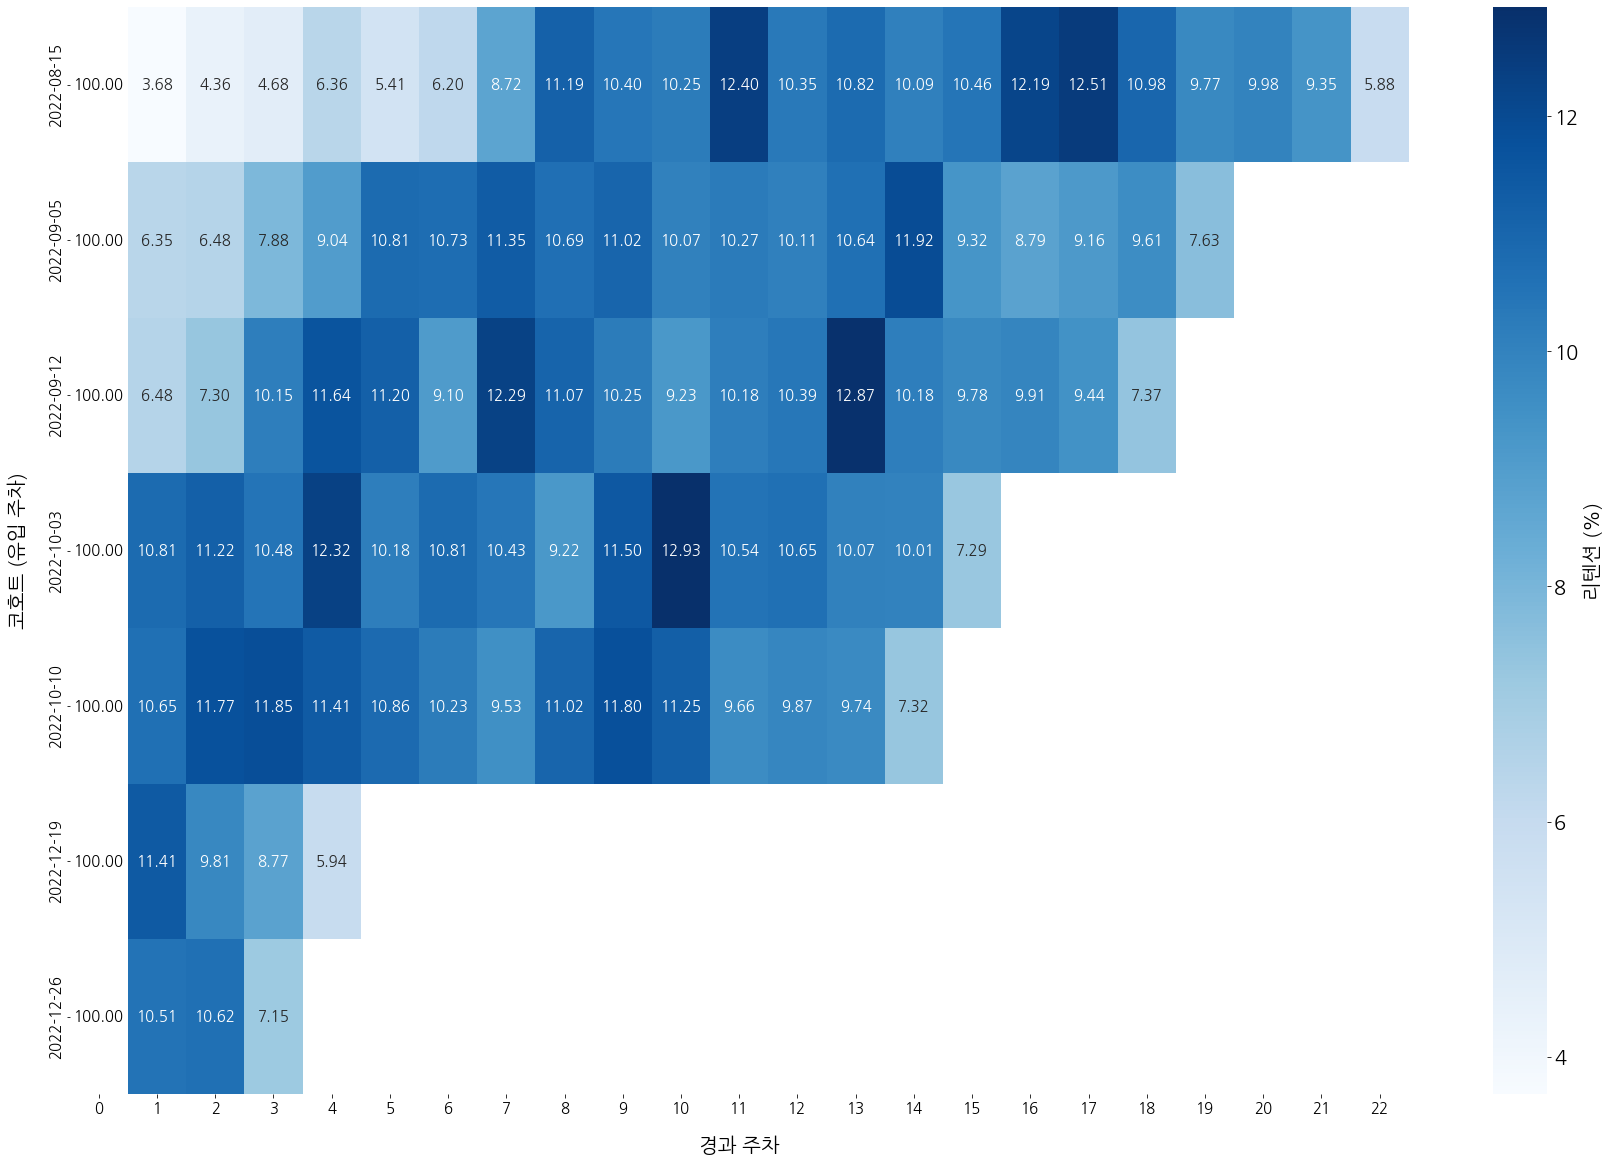

In [104]:
# 연휴 유입 유저: 리텐션

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,20), facecolor='white')

# 0주차에 대해서만 색 칠하기 제외 (True로 설정)
mask = np.zeros_like(cohort_retention_pivot_holiday.set_index('cohort_week'), dtype=bool)
mask[:,:1] = True

# 0주차 제외한 파트: 값 표시 제외
sns.heatmap(
    data=cohort_retention_pivot_holiday.set_index('cohort_week'),
    mask=mask,
    annot=False,
    cmap='Blues',
    cbar=True
)

# 0주차 제외한 파트: 값 표시 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_retention_pivot_holiday.set_index('cohort_week'),
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    annot_kws={'size': 15},
    cbar=False,
    alpha=0.0
)

# 0주차 글자 표기 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_retention_pivot_holiday.set_index('cohort_week'),
    mask=~mask,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    annot_kws={
        'size': 15,
        'color': 'black',
    },
    cbar=False,
    alpha=0.0
)

plt.xlabel("경과 주차", fontsize=20, labelpad=20)
plt.ylabel("코호트 (유입 주차)", fontsize=20, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# colorbar 설정
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('리텐션 (%)', fontsize=20)

# 차트 출력
plt.show()

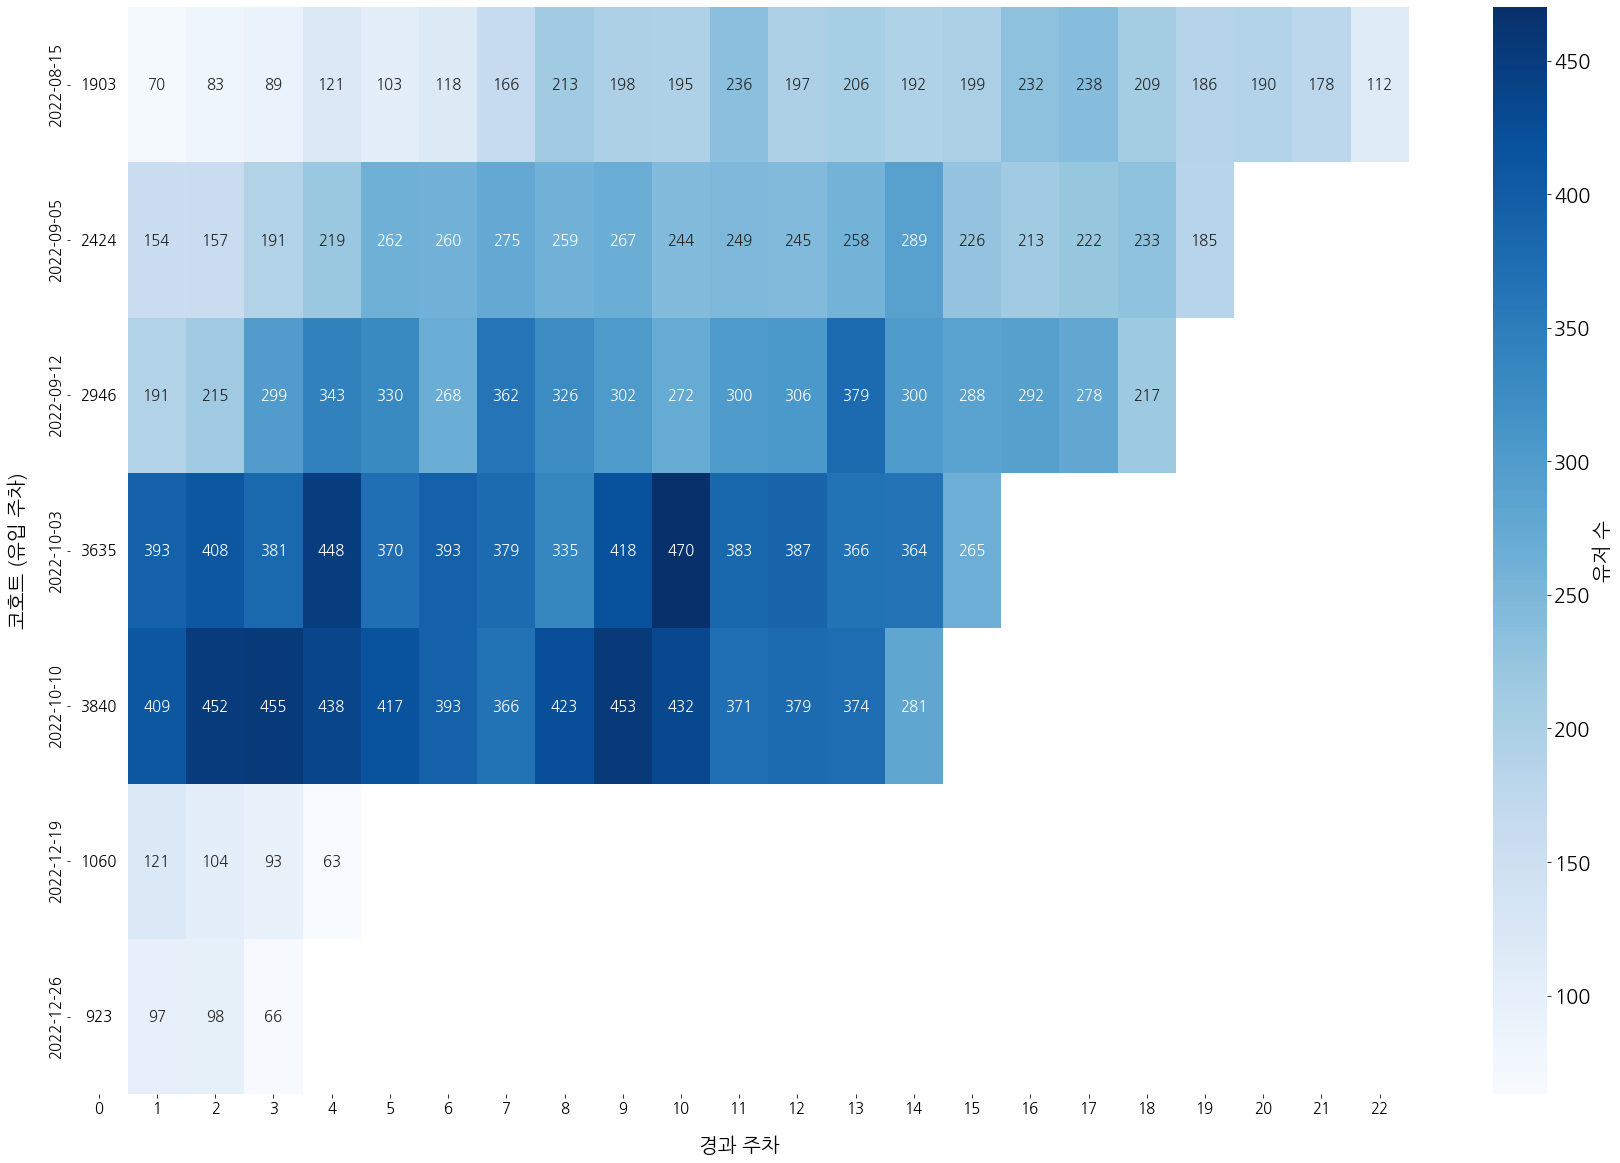

In [105]:
# 연휴 유입 유저: 유저 수

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,20), facecolor='white')

# 0주차에 대해서만 색 칠하기 제외 (True로 설정)
mask = np.zeros_like(cohort_au_pivot_holiday.set_index('cohort_week'), dtype=bool)
mask[:,:1] = True

# 0주차 제외한 파트: 값 표시 제외
sns.heatmap(
    data=cohort_au_pivot_holiday.set_index('cohort_week'),
    mask=mask,
    annot=False,
    cmap='Blues',
    cbar=True
)

# 0주차 제외한 파트: 값 표시 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_au_pivot_holiday.set_index('cohort_week'),
    mask=mask,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    annot_kws={'size': 15},
    cbar=False,
    alpha=0.0
)

# 0주차 글자 표기 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_au_pivot_holiday.set_index('cohort_week'),
    mask=~mask,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    annot_kws={
        'size': 15,
        'color': 'black',
    },
    cbar=False,
    alpha=0.0
)

plt.xlabel("경과 주차", fontsize=20, labelpad=20)
plt.ylabel("코호트 (유입 주차)", fontsize=20, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# colorbar 설정
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('유저 수', fontsize=20)

# 차트 출력
plt.show()

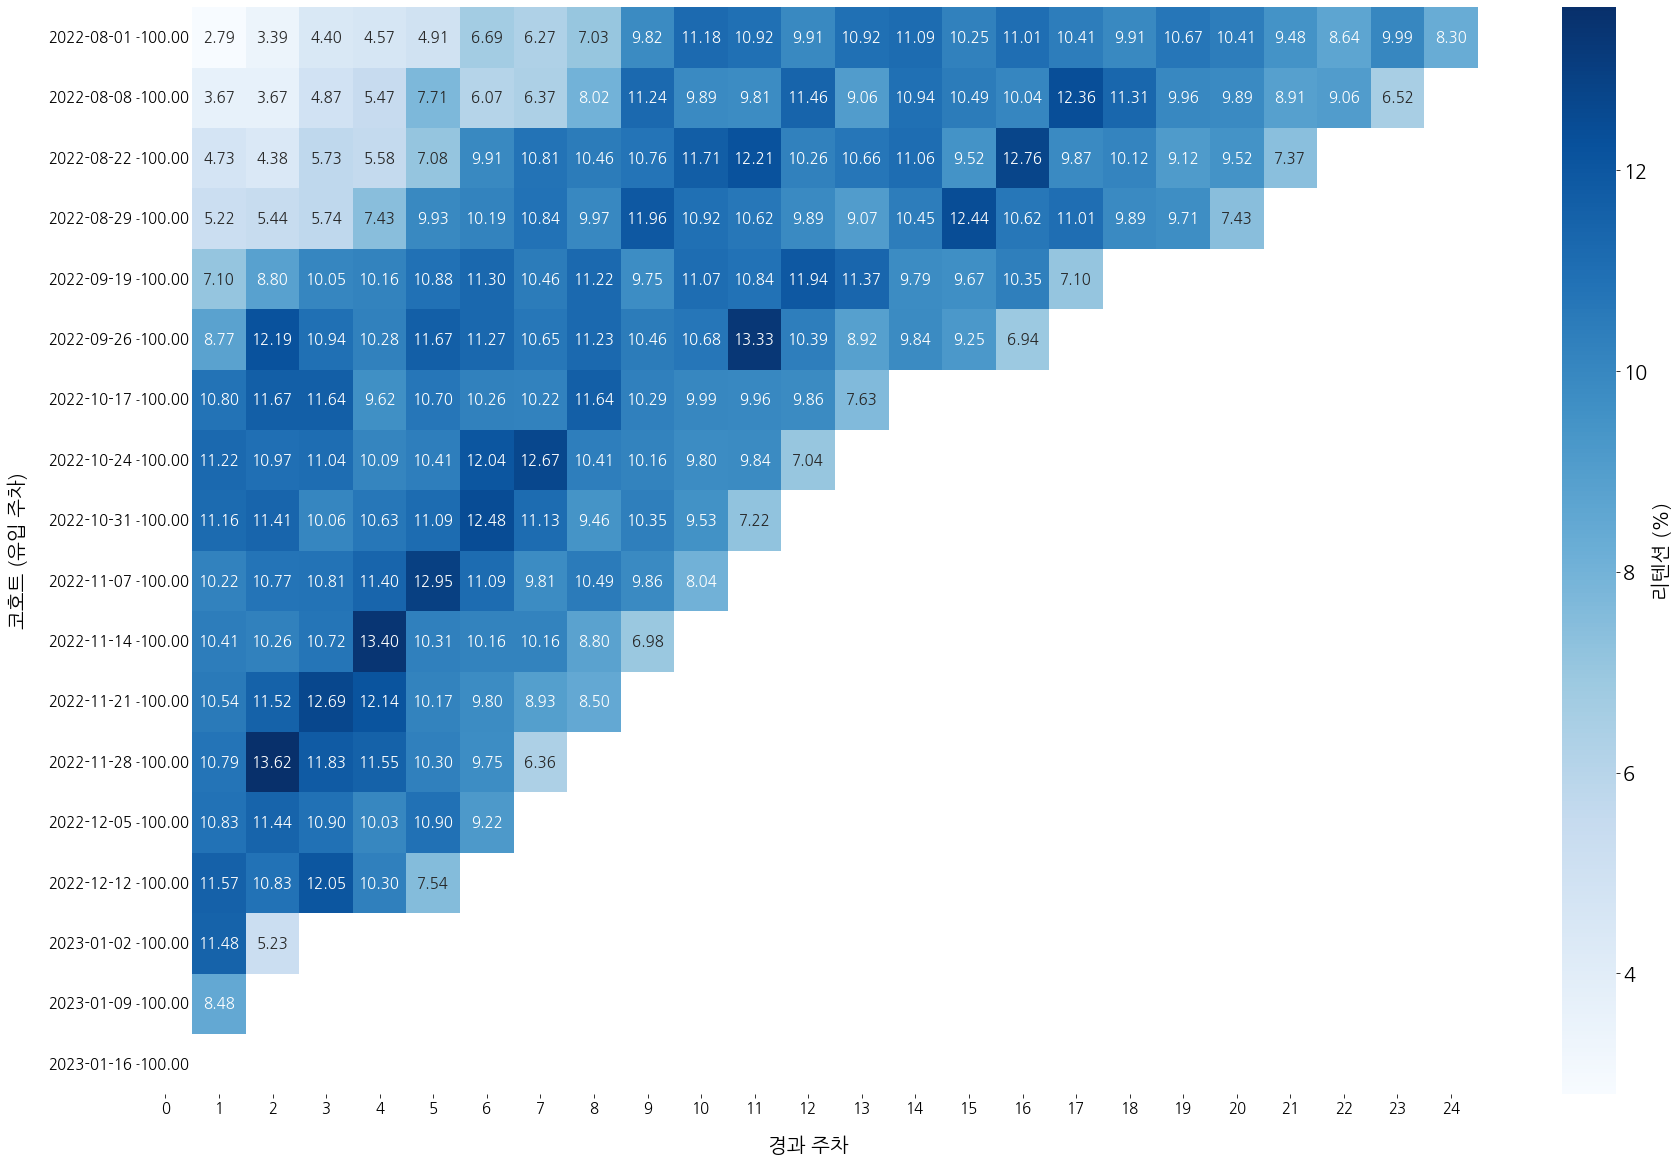

In [106]:
# 연휴 외 유입 유저: 리텐션

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(30,20), facecolor='white')

# 0주차에 대해서만 색 칠하기 제외 (True로 설정)
mask = np.zeros_like(cohort_retention_pivot_normalday.set_index('cohort_week'), dtype=bool)
mask[:,:1] = True

# 0주차 제외한 파트: 값 표시 제외
sns.heatmap(
    data=cohort_retention_pivot_normalday.set_index('cohort_week'),
    mask=mask,
    annot=False,
    cmap='Blues',
    cbar=True
)

# 0주차 제외한 파트: 값 표시 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_retention_pivot_normalday.set_index('cohort_week'),
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    annot_kws={'size': 15},
    cbar=False,
    alpha=0.0
)

# 0주차 글자 표기 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_retention_pivot_normalday.set_index('cohort_week'),
    mask=~mask,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    annot_kws={
        'size': 15,
        'color': 'black',
    },
    cbar=False,
    alpha=0.0
)

plt.xlabel("경과 주차", fontsize=20, labelpad=20)
plt.ylabel("코호트 (유입 주차)", fontsize=20, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)

# colorbar 설정
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('리텐션 (%)', fontsize=20)

# 차트 출력
plt.show()

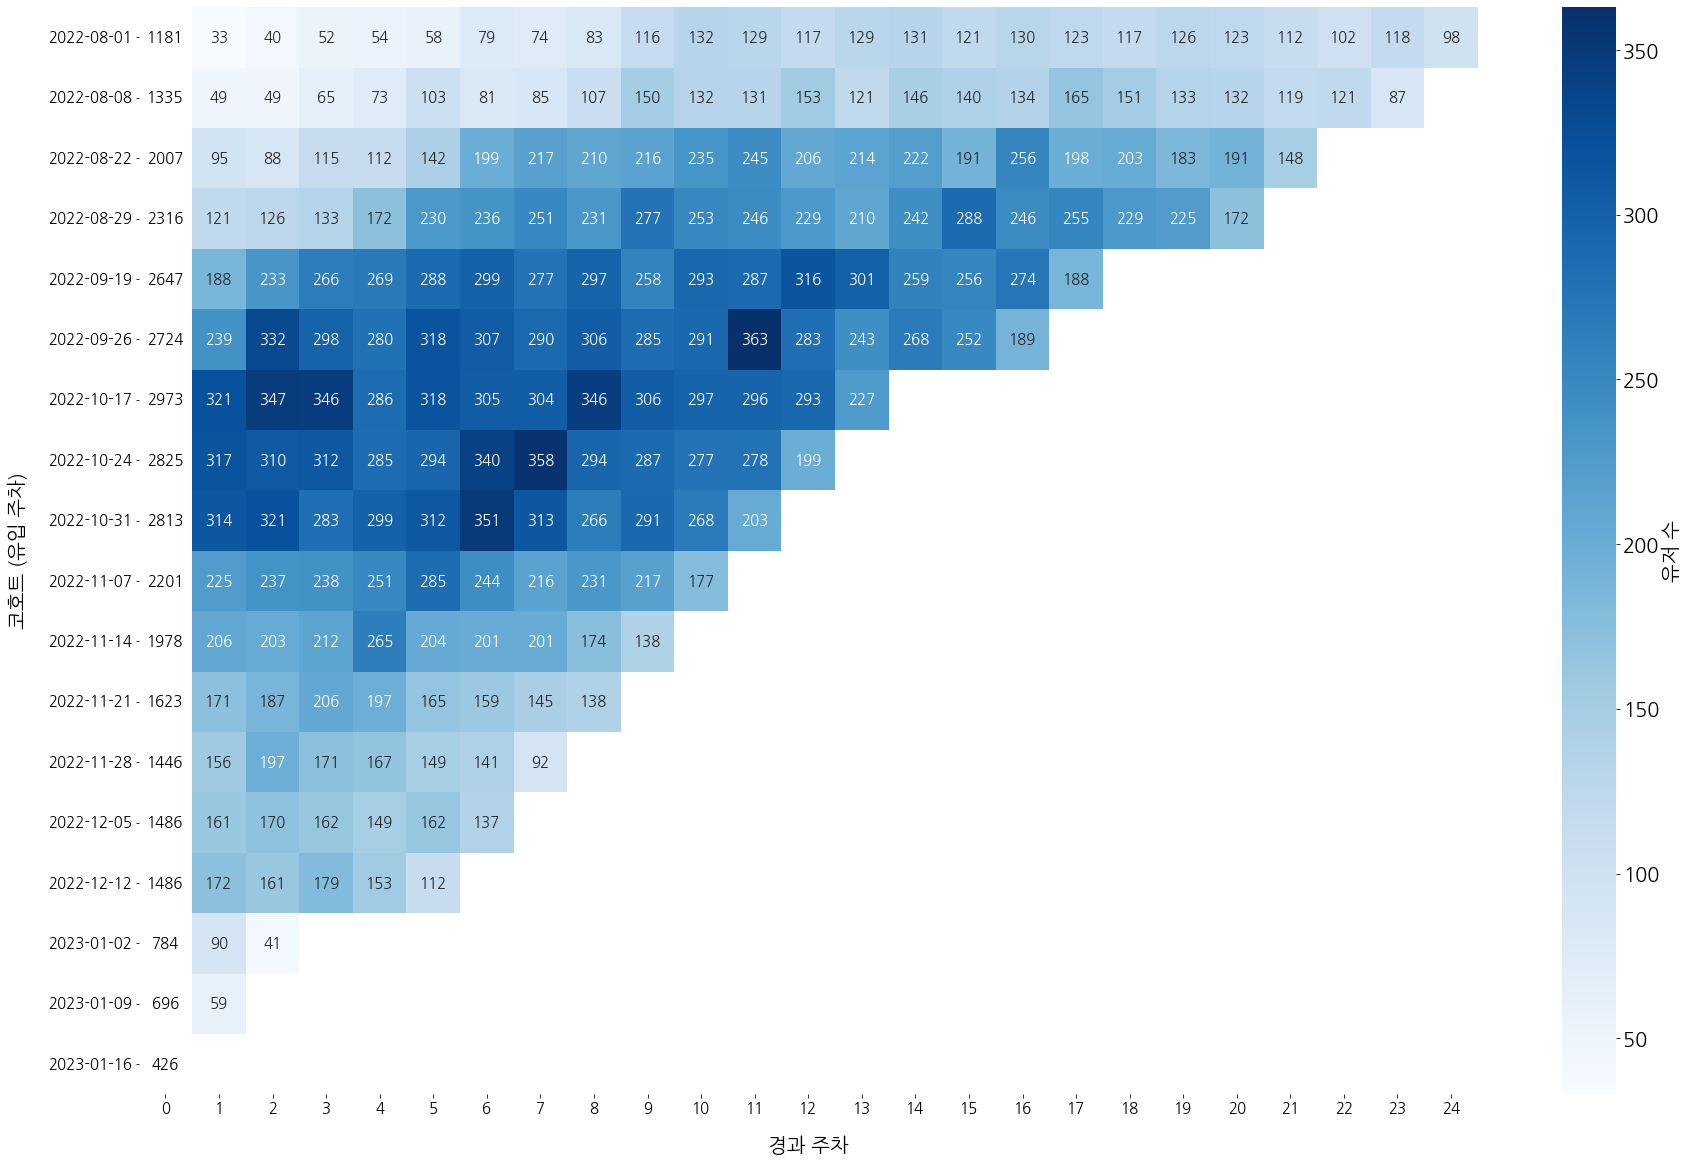

In [107]:
# 연휴 외 유입 유저: 유저 수

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(30,20), facecolor='white')


# 0주차에 대해서만 색 칠하기 제외 (True로 설정)
mask = np.zeros_like(cohort_au_pivot_normalday.set_index('cohort_week'), dtype=bool)
mask[:,:1] = True

# 0주차 제외한 파트: 값 표시 제외
sns.heatmap(
    data=cohort_au_pivot_normalday.set_index('cohort_week'),
    mask=mask,
    annot=False,
    cmap='Blues',
    cbar=True
)

# 0주차 제외한 파트: 값 표시 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_au_pivot_normalday.set_index('cohort_week'),
    mask=mask,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    annot_kws={'size': 15},
    cbar=False,
    alpha=0.0
)

# 0주차 글자 표기 (위에 덮어서 표시)
sns.heatmap(
    data=cohort_au_pivot_normalday.set_index('cohort_week'),
    mask=~mask,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    annot_kws={
        'size': 15,
        'color': 'black',
    },
    cbar=False,
    alpha=0.0
)

plt.xlabel("경과 주차", fontsize=20, labelpad=20)
plt.ylabel("코호트 (유입 주차)", fontsize=20, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)

# colorbar 설정
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('유저 수', fontsize=20)

# 차트 출력
plt.show()

#### 통계적 검정: 그룹간 재방문율 차이

##### Mann-Whitney U test

- 귀무가설: 연휴 유입 유저 vs. 연휴 외 유입 유저 간 재방문율 차이가 없다.
- 대립가설: 연휴 유입 유저 vs. 연휴 외 유입 유저 간 재방문율 차이가 있다.

In [108]:
from scipy.stats import mannwhitneyu

# 각 그룹에 대해 코호트별로 리텐션 중위수 계산

cohort_holiday_median = cohort_retention_holiday.groupby('cohort_week').agg({'cohort_retention_rate':'median'}).reset_index()
cohort_normalday_median = cohort_retention_normalday.groupby('cohort_week').agg({'cohort_retention_rate':'median'}).reset_index()

# 길이를 억지로 맞추지 않아도 검정 가능
# cohort_median_inflow = pd.merge(cohort_holiday_median, cohort_normalday_median, on='cohort_week', how='outer').rename(columns={'cohort_retention_rate_x':'holiday', 'cohort_retention_rate_y':'normalday', 'cohort_retention_rate':'retention_rate'})
# cohort_median_inflow.fillna(0, inplace=True)
# cohort_median_inflow.sort_values(by='cohort_week', inplace=True)

mannwhitneyu(cohort_holiday_median['cohort_retention_rate'], cohort_normalday_median['cohort_retention_rate'])

MannwhitneyuResult(statistic=42.0, pvalue=0.22041605991262742)

- p-value가 0.05보다 크므로 귀무가설 기각
- 즉, 연휴 유입 유저와 연휴 외 유입 유저간 재방문율 차이가 없다.

- 귀무가설: 연휴 유입 vs. 연휴 외 유입 유저 간 유저 수 차이가 없다.
- 대립가설: 연휴 유입 vs. 연휴 외 유입 유저 간 유저 수 차이가 있다.

In [109]:
from scipy.stats import mannwhitneyu

# 각 그룹에 대해 코호트별로 잔존 유저 수 중위수 계산

cohort_au_holiday_median = cohort_retention_holiday.groupby('cohort_week').agg({'retain_users':'median'}).reset_index()
cohort_au_normalday_median = cohort_retention_normalday.groupby('cohort_week').agg({'retain_users':'median'}).reset_index()

# 길이를 억지로 맞추지 않아도 검정 가능
# cohort_median_inflow = pd.merge(cohort_holiday_median, cohort_normalday_median, on='cohort_week', how='outer').rename(columns={'cohort_retention_rate_x':'holiday', 'cohort_retention_rate_y':'normalday', 'cohort_retention_rate':'retention_rate'})
# cohort_median_inflow.fillna(0, inplace=True)
# cohort_median_inflow.sort_values(by='cohort_week', inplace=True)

mannwhitneyu(cohort_au_holiday_median['retain_users'], cohort_au_normalday_median['retain_users'])

MannwhitneyuResult(statistic=68.0, pvalue=0.7853107975092231)

- p-value가 0.05보다 크므로 귀무가설 기각
- 즉, 연휴 유입 유저와 연휴 외 유입 유저간 유저 수 차이가 없다.

### 상관관계: 재방문율-주문율

1. 재방문율 (리텐션)
- 각 유입주차를 코호트로 보고 코호트 별로 리텐션을 구한다. 
- 그리고 각 코호트의 리텐션 중위수를 구한다.

2. 주문율
- 각 그룹에 대해 주차별 주문율을 계산한다.

##### 회원 전체

In [110]:
# 코호트별 리텐션 대표값 계산하기 (중위수)
# 2023-01-16주차는 경과주차가 없으므로 merge 이후 제외하자.
cohort_median = cohort_retention.groupby('cohort_week').agg({'cohort_retention_rate':'median'}).reset_index()
cohort_median

,cohort_week,cohort_retention_rate
0,2022-08-01,9.9070
1,2022-08-08,9.4385
2,2022-08-15,10.0890
3,2022-08-22,10.0150
4,2022-08-29,9.9740
5,2022-09-05,10.0865
6,2022-09-12,10.1830
7,2022-09-19,10.4080
8,2022-09-26,10.6460
9,2022-10-03,10.5910


In [111]:
import pandas as pd

# 주차 단위의 주문율은 (일별 단위보다 상대적으로) 높지 않다.
retention_order_ratio = pd.merge(cohort_median, df_order_ratio_w, how='inner', left_on='cohort_week', right_on='event_week')
retention_order_ratio = retention_order_ratio[['cohort_week','cohort_retention_rate','order_ratio']]
retention_order_ratio.rename(columns={'cohort_retention_rate':'retention_rate'}, inplace=True)
retention_order_ratio['cohort_week'] = pd.to_datetime(retention_order_ratio['cohort_week'])
retention_order_ratio

,cohort_week,retention_rate,order_ratio
0,2022-08-01,9.9070,10.161
1,2022-08-08,9.4385,7.681
2,2022-08-15,10.0890,12.846
3,2022-08-22,10.0150,10.269
4,2022-08-29,9.9740,10.222
5,2022-09-05,10.0865,22.500
6,2022-09-12,10.1830,12.401
7,2022-09-19,10.4080,9.870
8,2022-09-26,10.6460,10.410
9,2022-10-03,10.5910,16.972


In [112]:
from scipy.stats import pearsonr, spearmanr

# 피어슨 상관계수
pearson_corr, pearson_p = pearsonr(retention_order_ratio['retention_rate'], retention_order_ratio['order_ratio'])
print(pearson_corr, pearson_p)

# 스피어만 상관계수
spearman_corr, spearman_p = spearmanr(retention_order_ratio['retention_rate'], retention_order_ratio['order_ratio'])
print(spearman_corr, spearman_p)

-0.1275618283741834 0.5434220064427809
-0.21581073682535565 0.3001632373776406


- 피어슨, 스피어만 둘 다 재방문율이 증가하면 주문율이 감소하는 경향을 보인다.
- 하지만 둘 다 p-value가 0.05보다 크므로 통계적으로 유의미하지 않다.

#### 단기 vs. 중기 vs. 장기

In [113]:
# 그룹별 주차별 주문율 계산

sql = f"""
WITH short_user_logs AS (
  -- 단기 재방문 유저의 로그
  SELECT
    event_date,
    user_pseudo_id,
    event_name
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'short'
  )
  GROUP BY ALL
)
, short_wau_list AS (
  SELECT
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM short_user_logs
  GROUP BY DATE_TRUNC(event_date, WEEK(MONDAY))
)
, short_order_cnt_list_w AS (
  -- 주차별 주문 유저 수
  SELECT
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week,
    COUNT(DISTINCT user_pseudo_id) AS order_users_cnt
  FROM short_user_logs
  WHERE event_name = 'click_payment'
  GROUP BY DATE_TRUNC(event_date, WEEK(MONDAY))
)



, mid_user_logs AS (
  -- 중기 재방문 유저의 로그
  SELECT
    event_date,
    user_pseudo_id,
    event_name
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'mid'
  )
  GROUP BY ALL
)
, mid_wau_list AS (
  SELECT
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM mid_user_logs
  GROUP BY DATE_TRUNC(event_date, WEEK(MONDAY))
)
, mid_order_cnt_list_w AS (
  -- 주차별 주문 유저 수
  SELECT
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week,
    COUNT(DISTINCT user_pseudo_id) AS order_users_cnt
  FROM mid_user_logs
  WHERE event_name = 'click_payment'
  GROUP BY DATE_TRUNC(event_date, WEEK(MONDAY))
)



, long_user_logs AS (
  -- 장기 재방문 유저의 로그
  SELECT
    event_date,
    user_pseudo_id,
    event_name
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'long'
  )
  GROUP BY ALL
)
, long_wau_list AS (
  SELECT
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM long_user_logs
  GROUP BY DATE_TRUNC(event_date, WEEK(MONDAY))
)
, long_order_cnt_list_w AS (
  -- 주차별 주문 유저 수
  SELECT
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week,
    COUNT(DISTINCT user_pseudo_id) AS order_users_cnt
  FROM long_user_logs
  WHERE event_name = 'click_payment'
  GROUP BY DATE_TRUNC(event_date, WEEK(MONDAY))
)


SELECT
  w.event_week,
  'short' AS user_segment,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, w.wau) * 100, 3) AS order_ratio  -- 주문율
FROM short_wau_list w
INNER JOIN short_order_cnt_list_w o ON w.event_week = o.event_week

UNION ALL

SELECT
  w.event_week,
  'mid' AS user_segment,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, w.wau) * 100, 3) AS order_ratio  -- 주문율
FROM mid_wau_list w
INNER JOIN mid_order_cnt_list_w o ON w.event_week = o.event_week

UNION ALL

SELECT
  w.event_week,
  'long' AS user_segment,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, w.wau) * 100, 3) AS order_ratio  -- 주문율
FROM long_wau_list w
INNER JOIN long_order_cnt_list_w o ON w.event_week = o.event_week

ORDER BY user_segment, event_week ASC
"""

query_job = client.query(sql)
order_ratio_w_visit_interval = query_job.to_dataframe()
order_ratio_w_visit_interval.head()

,event_week,user_segment,order_ratio
0,2022-08-01,long,9.524
1,2022-08-08,long,6.235
2,2022-08-15,long,12.521
3,2022-08-22,long,10.738
4,2022-08-29,long,9.684


In [114]:
# 그룹별 주문율 + 리텐션


# 단기 재방문 유저
retention_order_ratio_short = pd.merge(
    cohort_short_median, 
    order_ratio_w_visit_interval.loc[order_ratio_w_visit_interval['user_segment']=='short'], 
    how='inner', 
    left_on='cohort_week', 
    right_on='event_week'
).rename(columns={'cohort_retention_rate':'retention_rate'}).drop(columns=['event_week','user_segment'])

retention_order_ratio_short['cohort_week'] = pd.to_datetime(retention_order_ratio_short['cohort_week'])


# 중기 재방문 유저
retention_order_ratio_mid = pd.merge(
    cohort_mid_median, 
    order_ratio_w_visit_interval.loc[order_ratio_w_visit_interval['user_segment']=='mid'], 
    how='inner', 
    left_on='cohort_week', 
    right_on='event_week'
).rename(columns={'cohort_retention_rate':'retention_rate'}).drop(columns=['event_week','user_segment'])

retention_order_ratio_mid['cohort_week'] = pd.to_datetime(retention_order_ratio_mid['cohort_week'])


# 장기 재방문 유저
retention_order_ratio_long = pd.merge(
    cohort_long_median, 
    order_ratio_w_visit_interval.loc[order_ratio_w_visit_interval['user_segment']=='long'], 
    how='inner', 
    left_on='cohort_week', 
    right_on='event_week'
).rename(columns={'cohort_retention_rate':'retention_rate'}).drop(columns=['event_week','user_segment'])

retention_order_ratio_long['cohort_week'] = pd.to_datetime(retention_order_ratio_long['cohort_week'])

In [115]:
from scipy.stats import pearsonr, spearmanr

# 단기 재방문 유저
pearson_corr, pearson_p = pearsonr(retention_order_ratio_short['retention_rate'], retention_order_ratio_short['order_ratio'])
spearman_corr, spearman_p = spearmanr(retention_order_ratio_short['retention_rate'], retention_order_ratio_short['order_ratio'])
print(pearson_corr, pearson_p)
print(spearman_corr, spearman_p)


# 중기 재방문 유저
pearson_corr, pearson_p = pearsonr(retention_order_ratio_mid['retention_rate'], retention_order_ratio_mid['order_ratio'])
spearman_corr, spearman_p = spearmanr(retention_order_ratio_mid['retention_rate'], retention_order_ratio_mid['order_ratio'])
print(pearson_corr, pearson_p)
print(spearman_corr, spearman_p)


# 장기 재방문 유저
pearson_corr, pearson_p = pearsonr(retention_order_ratio_long['retention_rate'], retention_order_ratio_long['order_ratio'])
spearman_corr, spearman_p = spearmanr(retention_order_ratio_long['retention_rate'], retention_order_ratio_long['order_ratio'])
print(pearson_corr, pearson_p)
print(spearman_corr, spearman_p)

-0.15868296209678245 0.4486816795363001
-0.2169230769230769 0.29761825514652124
-0.010805854194222236 0.9609716652337392
-0.09980237154150197 0.6504928119104102
0.11963392256822658 0.6054891561139899
-0.12337662337662336 0.5941682580055345


- 모든 그룹에 대해 재방문율과 주문율의 상관관계가 없다.

#### [여기부터] (전체) 연휴 유입 vs. 연휴 외 유입

In [116]:
# 그룹별 주차별 주문율 계산

sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)
, dau_vs_order_user AS (
  -- DAU와 일별 주문 유저 수 비교
  SELECT
    d.event_date,
    d.dau,
    o.order_users_cnt,
    ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
  FROM dau_list d
  INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
)
, holiday AS (
  -- 연휴 정의
  SELECT
    event_date AS holiday_date,
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
  FROM dau_vs_order_user
  WHERE order_ratio > 30
)


, holiday_inflow_logs AS (
  -- 연휴 유입 유저 로그
  SELECT
    event_date,
    user_pseudo_id,
    event_name
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_cleaned_target
    GROUP BY user_pseudo_id
    HAVING DATE_TRUNC(MIN(event_date), WEEK(MONDAY)) IN (SELECT holiday_week FROM holiday)
  )
  GROUP BY ALL
)
, holiday_wau_list AS (
  SELECT
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM holiday_inflow_logs
  GROUP BY DATE_TRUNC(event_date, WEEK(MONDAY))
)
, holiday_order_cnt_list_w AS (
  -- 주차별 주문 유저 수
  SELECT
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week,
    COUNT(DISTINCT user_pseudo_id) AS order_users_cnt
  FROM holiday_inflow_logs
  WHERE event_name = 'click_payment'
  GROUP BY DATE_TRUNC(event_date, WEEK(MONDAY))
)




, normalday_inflow_logs AS (
  -- 연휴 외 유입 유저 로그
  SELECT
    event_date,
    user_pseudo_id,
    event_name
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_cleaned_target
    GROUP BY user_pseudo_id
    HAVING DATE_TRUNC(MIN(event_date), WEEK(MONDAY)) NOT IN (SELECT holiday_week FROM holiday)
  )
  GROUP BY ALL
)
, normalday_wau_list AS (
  SELECT
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM normalday_inflow_logs
  GROUP BY DATE_TRUNC(event_date, WEEK(MONDAY))
)
, normalday_order_cnt_list_w AS (
  -- 주차별 주문 유저 수
  SELECT
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week,
    COUNT(DISTINCT user_pseudo_id) AS order_users_cnt
  FROM normalday_inflow_logs
  WHERE event_name = 'click_payment'
  GROUP BY DATE_TRUNC(event_date, WEEK(MONDAY))
)


SELECT
  w.event_week,
  'holiday' AS user_segment,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, w.wau) * 100, 3) AS order_ratio  -- 주문율
FROM holiday_wau_list w
INNER JOIN holiday_order_cnt_list_w o ON w.event_week = o.event_week

UNION ALL

SELECT
  w.event_week,
  'normalday' AS user_segment,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, w.wau) * 100, 3) AS order_ratio  -- 주문율
FROM normalday_wau_list w
INNER JOIN normalday_order_cnt_list_w o ON w.event_week = o.event_week


ORDER BY user_segment, event_week ASC
"""

query_job = client.query(sql)
order_ratio_w_inflow = query_job.to_dataframe()
order_ratio_w_inflow.head()

,event_week,user_segment,order_ratio
0,2022-08-15,holiday,12.927
1,2022-08-22,holiday,9.091
2,2022-08-29,holiday,6.818
3,2022-09-05,holiday,22.351
4,2022-09-12,holiday,12.515


In [127]:
# 주문율은 모든 주차에 대해 값이 있다.
# 주문율과 주차를 동일하게 하기 위해 코호트 리텐션에 대해 캘린더 주차별 (즉 대각선) 중위수를 계산한다.


# 연휴 유입 유저
cohort_retention_holiday['cohort_week'] = pd.to_datetime(cohort_retention_holiday['cohort_week'])
cohort_retention_holiday['calendar_week'] = cohort_retention_holiday['cohort_week'] + pd.to_timedelta(cohort_retention_holiday['week_diff'] * 7, unit='D')

a = cohort_retention_holiday.groupby('calendar_week').agg({'cohort_retention_rate':'median'}).reset_index()

order_ratio_w_inflow['event_week'] = pd.to_datetime(order_ratio_w_inflow['event_week'])
b = order_ratio_w_inflow.loc[order_ratio_w_inflow['user_segment']=='holiday'][['event_week', 'order_ratio']]

retention_order_ratio_holiday = pd.merge(
    a,
    b,
    how='inner',
    left_on='calendar_week',
    right_on='event_week'
)[['event_week','cohort_retention_rate','order_ratio']].rename(columns={'cohort_retention_rate':'retention_rate'})



# 연휴 외 유입 유저
cohort_retention_normalday['cohort_week'] = pd.to_datetime(cohort_retention_normalday['cohort_week'])
cohort_retention_normalday['calendar_week'] = cohort_retention_normalday['cohort_week'] + pd.to_timedelta(cohort_retention_normalday['week_diff'] * 7, unit='D')

c = cohort_retention_normalday.groupby('calendar_week').agg({'cohort_retention_rate':'median'}).reset_index()

order_ratio_w_inflow['event_week'] = pd.to_datetime(order_ratio_w_inflow['event_week'])
d = order_ratio_w_inflow.loc[order_ratio_w_inflow['user_segment']=='normalday'][['event_week', 'order_ratio']]

retention_order_ratio_normalday = pd.merge(
    c,
    d,
    how='inner',
    left_on='calendar_week',
    right_on='event_week'
)[['event_week','cohort_retention_rate','order_ratio']].rename(columns={'cohort_retention_rate':'retention_rate'})

In [129]:
# 세그먼트별로 상관관계 알아보기
from scipy.stats import pearsonr, spearmanr

# 연휴 유입 유저
pearson_corr, pearson_p = pearsonr(
    retention_order_ratio_holiday['retention_rate'], 
    retention_order_ratio_holiday['order_ratio']
)
print(pearson_corr, pearson_p)

spearman_corr, spearman_p = spearmanr(
    retention_order_ratio_holiday['retention_rate'], 
    retention_order_ratio_holiday['order_ratio']
)
print(spearman_corr, spearman_p)


# 연휴 외 유입 유저
pearson_corr, pearson_p = pearsonr(
    retention_order_ratio_normalday['retention_rate'], 
    retention_order_ratio_normalday['order_ratio']
)
print(pearson_corr, pearson_p)

spearman_corr, spearman_p = spearmanr(
    retention_order_ratio_normalday['retention_rate'], 
    retention_order_ratio_normalday['order_ratio']
)
print(spearman_corr, spearman_p)

0.419686971057782 0.04619030238593024
0.15612648221343872 0.4768477376528467
-0.18955646144240793 0.3641287600685055
-0.41692307692307695 0.03813664539997255


- pearson 기준 연휴 유입의 경우 재방문율이 증가하면 주문율이 증가한다.
- spearman 기준 연휴 외 유저의 경우 재방문율이 증가하면 주문율이 떨어진다.